In [1]:
import pandas as pd
import os

# Define the directory where your data files are located
# Assuming the script is in the same folder as your Excel files.
data_dir = '.'

# Define the input file names
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls') # EIA files are often .xls even if downloaded as Excel
file_gasoline = os.path.join(data_dir, 'WGTSTUS1w.xls')
file_crude = os.path.join(data_dir, 'WTTSTUS1w.xls') # Assuming WTTSTUS1w is Total Crude or Total Petroleum

# Define the output cleaned CSV file name
output_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')

def load_and_clean_eia_data(filepath, product_name):
    """
    Loads EIA data from an Excel file, cleans it, and returns a DataFrame.
    Assumes EIA data usually has metadata rows at the top before the actual data.
    The actual data usually starts around row 3 or 4.
    """
    try:
        # Try to read the Excel file, skipping initial metadata rows
        # We'll inspect a few rows first to find the correct header
        temp_df = pd.read_excel(filepath, header=None, nrows=10)

        # Look for the row that contains 'Date' or 'Week Ended' and the data column name
        # EIA files often have 'Date' or 'Week Ending' as the first column of actual data
        # and the series ID (e.g., WDISTUS1w) as the second column header.

        # A common pattern is that the data starts on row 2 (0-indexed) or 3,
        # with the series ID being the column name for the values.
        # Let's try reading from row 2 (header=2) and see if 'Date' or 'Week Ended' appears.

        # It's crucial to inspect the actual Excel file to determine the correct 'header' row.
        # For typical EIA data, the header is often on row 2 (0-indexed), meaning 3rd row in Excel.
        # The first column is usually 'Date' or 'Week Ended', and the second is the series ID.

        # Let's assume the actual data header is on the 3rd row (index 2)
        df = pd.read_excel(filepath, header=2)

        # Rename columns for clarity
        # The first column is usually the date, the second is the value.
        # The column name for the value is often the series ID itself or a descriptive name.
        # Let's use the actual series ID as the product value column name if it's not 'Value'

        # Get the original column names
        original_cols = df.columns.tolist()

        # Assuming the first column is date and the second is the value
        # We need to confirm the name of the date column, it could be 'Date', 'Week Ended', etc.
        # And the value column which should correspond to the product_name

        # Standardize date column name to 'Date'
        # Try to find a date-like column name
        date_col = next((col for col in original_cols if 'date' in str(col).lower() or 'week ended' in str(col).lower()), original_cols[0])

        # Standardize value column name to 'Value'
        # The value column might be named after the series ID (e.g., WDISTUS1w)
        # Or it might be a more generic 'Value'
        value_col = original_cols[1] # Assume the second column is the value

        # Rename the columns
        df = df.rename(columns={date_col: 'Date', value_col: 'Value'})

        # Convert 'Date' column to datetime objects
        df['Date'] = pd.to_datetime(df['Date'])

        # Add a 'Product' column to identify the type of inventory
        df['Product'] = product_name

        # Select only the relevant columns and sort by date
        df = df[['Date', 'Product', 'Value']].sort_values(by='Date')

        # Handle potential non-numeric values in 'Value' (e.g., 'NA' or empty strings)
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

        # Handle missing values: Forward fill (propagates last valid observation forward)
        # This is a common strategy for time series data.
        df['Value'] = df['Value'].fillna(method='ffill')

        # If there are still NaNs at the beginning, fill with 0 or drop. For inventory, ffill is usually best.
        # Or you could interpolate: df['Value'].interpolate(method='linear', inplace=True)

        print(f"Successfully loaded and cleaned {filepath} for {product_name}.")
        print(f"Shape: {df.shape}")
        print(f"Missing values after cleaning:\n{df.isnull().sum()}")
        print(f"First 5 rows for {product_name}:\n{df.head()}")
        print(f"Last 5 rows for {product_name}:\n{df.tail()}")

        return df

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame() # Return empty DataFrame on error
    except Exception as e:
        print(f"An error occurred while processing {filepath}: {e}")
        return pd.DataFrame()

# Load and clean each dataset
print("--- Processing Distillate Data ---")
df_distillate = load_and_clean_eia_data(file_distillate, 'Distillate Fuel Oil')

print("\n--- Processing Gasoline Data ---")
df_gasoline = load_and_clean_eia_data(file_gasoline, 'Motor Gasoline')

print("\n--- Processing Crude Oil Data ---")
df_crude = load_and_clean_eia_data(file_crude, 'Crude Oil') # Assuming WTTSTUS1w is crude oil

# Combine all DataFrames
# Filter out empty DataFrames in case of loading errors
all_dfs = [df for df in [df_distillate, df_gasoline, df_crude] if not df.empty]

if all_dfs:
    combined_df = pd.concat(all_dfs).sort_values(by=['Date', 'Product']).reset_index(drop=True)

    # Optional: Check for duplicate dates/products (though unlikely after concat)
    combined_df.drop_duplicates(subset=['Date', 'Product'], inplace=True)

    # Save the combined, cleaned data to CSV
    combined_df.to_csv(output_file, index=False)
    print(f"\nCombined and cleaned data saved to {output_file}")
    print(f"Final combined DataFrame shape: {combined_df.shape}")
    print(f"Unique products in combined data: {combined_df['Product'].unique()}")
    print(f"Combined data first 5 rows:\n{combined_df.head()}")
    print(f"Combined data last 5 rows:\n{combined_df.tail()}")
else:
    print("\nNo data was successfully loaded and combined.")

--- Processing Distillate Data ---
Successfully loaded and cleaned ./WDISTUS1w.xls for Distillate Fuel Oil.
Shape: (12, 3)
Missing values after cleaning:
Date       12
Product     0
Value      12
dtype: int64
First 5 rows for Distillate Fuel Oil:
  Date              Product  Value
0  NaT  Distillate Fuel Oil    NaN
1  NaT  Distillate Fuel Oil    NaN
2  NaT  Distillate Fuel Oil    NaN
3  NaT  Distillate Fuel Oil    NaN
4  NaT  Distillate Fuel Oil    NaN
Last 5 rows for Distillate Fuel Oil:
   Date              Product  Value
7   NaT  Distillate Fuel Oil    NaN
8   NaT  Distillate Fuel Oil    NaN
9   NaT  Distillate Fuel Oil    NaN
10  NaT  Distillate Fuel Oil    NaN
11  NaT  Distillate Fuel Oil    NaN

--- Processing Gasoline Data ---
Successfully loaded and cleaned ./WGTSTUS1w.xls for Motor Gasoline.
Shape: (12, 3)
Missing values after cleaning:
Date       12
Product     0
Value      12
dtype: int64
First 5 rows for Motor Gasoline:
  Date         Product  Value
0  NaT  Motor Gasoline  

<ipython-input-1-e779ba3a1552>:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Value'] = df['Value'].fillna(method='ffill')
<ipython-input-1-e779ba3a1552>:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Value'] = df['Value'].fillna(method='ffill')
<ipython-input-1-e779ba3a1552>:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Value'] = df['Value'].fillna(method='ffill')


In [2]:
df = pd.read_excel(filepath, header=2)

NameError: name 'filepath' is not defined

In [3]:
python eia_data_preprocessing.py

SyntaxError: invalid syntax (<ipython-input-3-81338274d7e0>, line 1)

In [4]:
# Install openpyxl if not already present (needed for .xls files)
!pip install openpyxl

import pandas as pd
import os

# --- Define file paths in Colab ---
# Assuming your uploaded files are in the default /content/ directory
data_dir = '/content/'

# Define the input file names based on what you uploaded
# (Confirm these filenames exactly match what you see in Colab's file browser)
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls')
file_gasoline = os.path.join(data_dir, 'WGTSTUS1w.xls')
file_crude = os.path.join(data_dir, 'WTTSTUS1w.xls')

# Define the output cleaned CSV file name
output_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')

print(f"Files expected: {file_distillate}, {file_gasoline}, {file_crude}")
print(f"Output will be saved to: {output_file}")

Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls
Output will be saved to: /content/cleaned_eia_inventory.csv


In [5]:
YOUR_HEADER_ROW_INDEX = 2

Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls
Output cleaned data will be saved to: /content/cleaned_eia_inventory.csv
Visualizations will be saved to: /content/visualizations

--- Processing Distillate Data ---
Successfully loaded and cleaned /content/WDISTUS1w.xls for Distillate Fuel Oil.
Shape: (0, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64
First 5 rows for Distillate Fuel Oil:
Empty DataFrame
Columns: [Date, Product, Value]
Index: []
Last 5 rows for Distillate Fuel Oil:
Empty DataFrame
Columns: [Date, Product, Value]
Index: []

--- Processing Gasoline Data ---
Successfully loaded and cleaned /content/WGTSTUS1w.xls for Motor Gasoline.
Shape: (0, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64
First 5 rows for Motor Gasoline:
Empty DataFrame
Columns: [Date, Product, Value]
Index: []
Last 5 rows for Motor Gasoline:
Empty DataFrame
Columns: [Date, Product, Value]
In

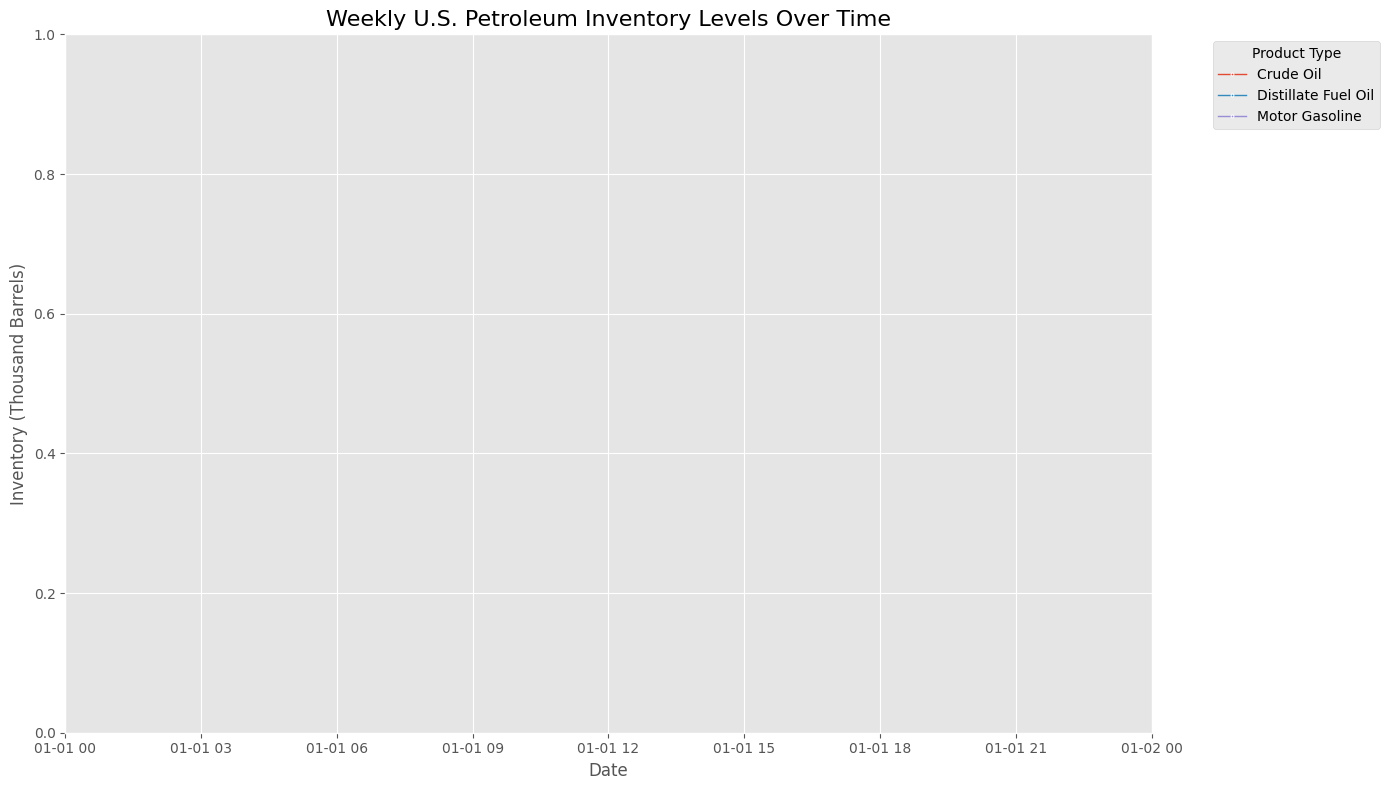

Saved 'all_products_inventory_trend.png'


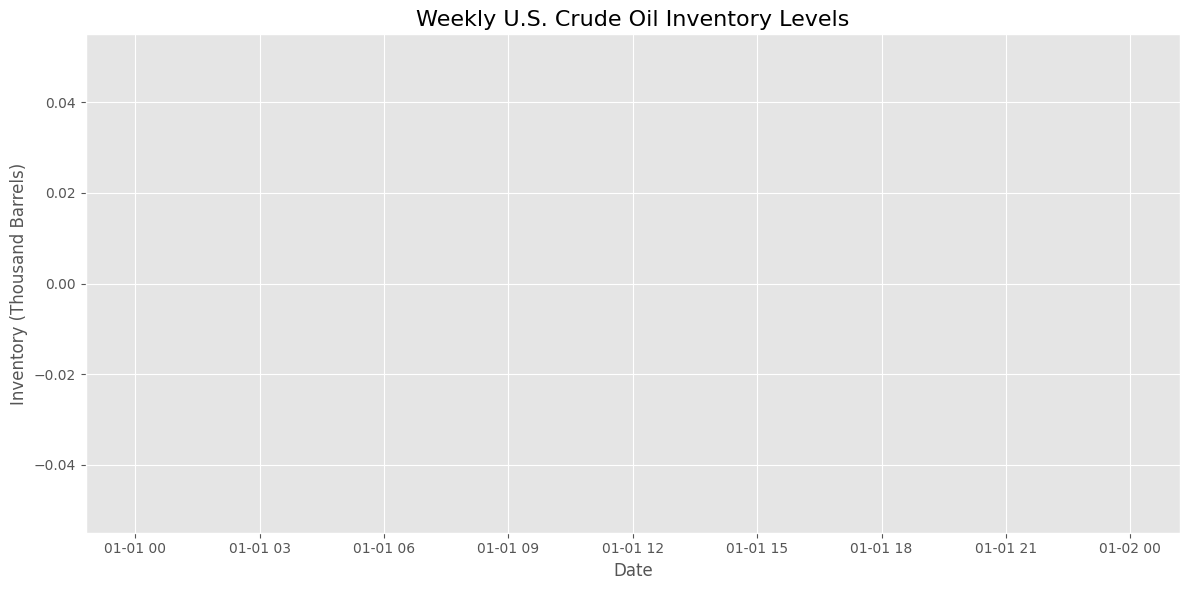

Saved 'crude_oil_inventory_trend.png'


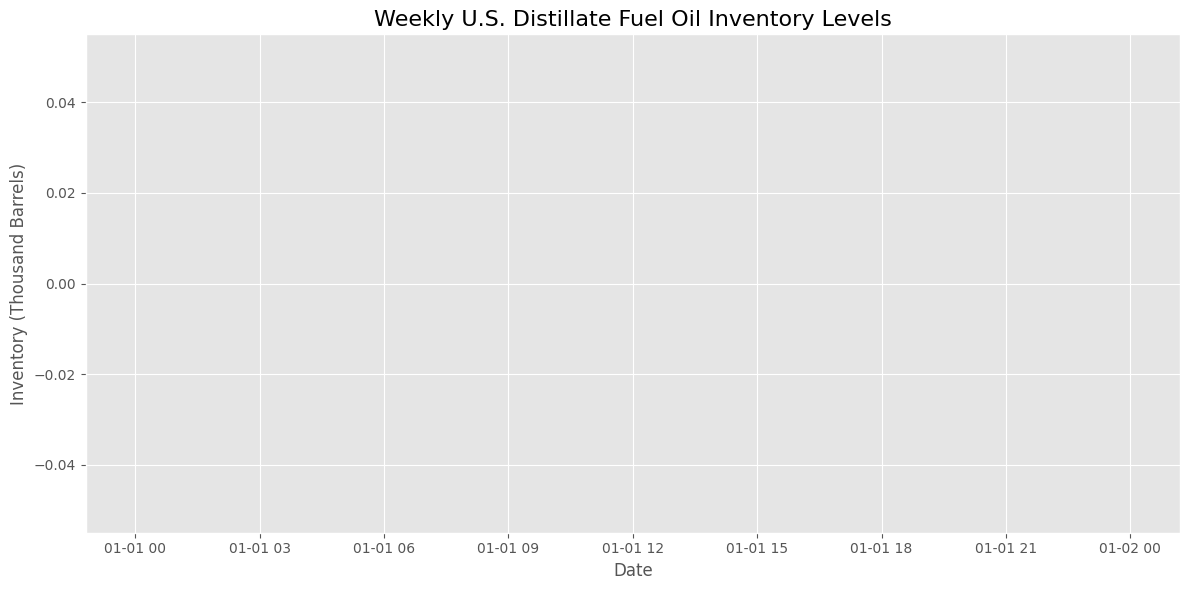

Saved 'distillate_fuel_oil_inventory_trend.png'


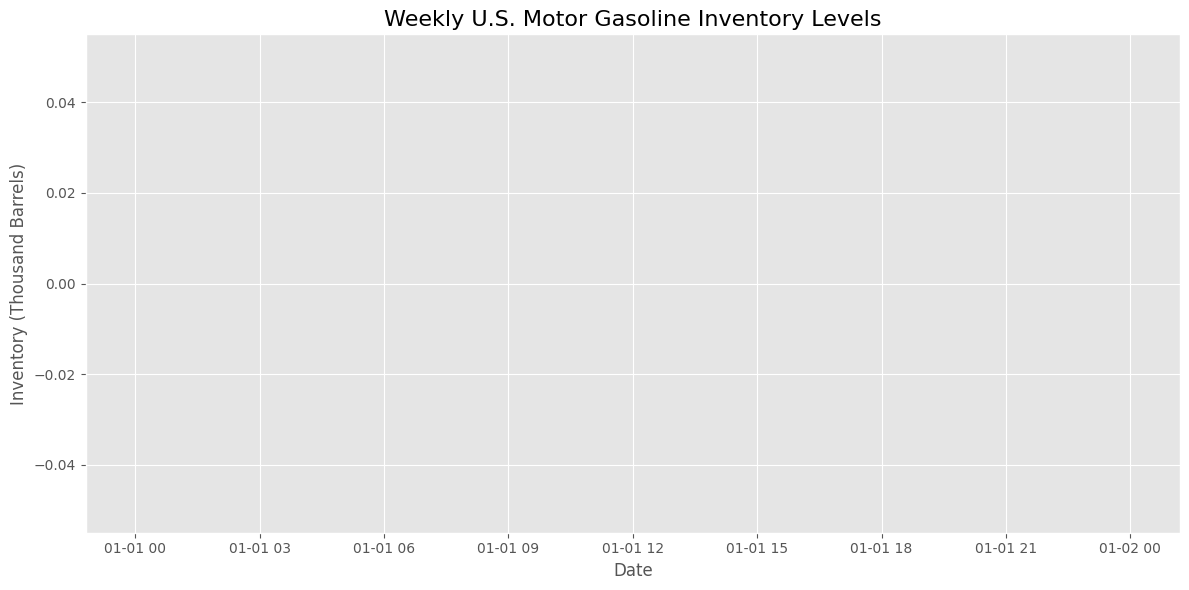

Saved 'motor_gasoline_inventory_trend.png'
An error occurred during EDA: cannot convert NA to integer


In [6]:
# --- Colab Cell 1: Install Libraries & Setup Paths ---
# This section ensures necessary libraries are installed and defines file paths for Colab.

# Install openpyxl if not already present (needed for .xls files)
!pip install openpyxl matplotlib seaborn

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths in Colab
# Assuming your uploaded files are in the default /content/ directory
data_dir = '/content/'

# Define the input file names based on what you uploaded
# (Confirm these filenames exactly match what you see in Colab's file browser)
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls')
file_gasoline = os.path.join(data_dir, 'WGTSTUS1w.xls')
file_crude = os.path.join(data_dir, 'WTTSTUS1w.xls')

# Define the output cleaned CSV file name
output_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')
# Define the output directory for visualizations within Colab
output_viz_dir = os.path.join(data_dir, 'visualizations')

# Create the visualizations directory if it doesn't exist
os.makedirs(output_viz_dir, exist_ok=True)

print(f"Files expected: {file_distillate}, {file_gasoline}, {file_crude}")
print(f"Output cleaned data will be saved to: {output_file}")
print(f"Visualizations will be saved to: {output_viz_dir}")

# --- Colab Cell 2: Data Preprocessing Logic ---
# This section contains the function to load and clean EIA data, and then applies it.

def load_and_clean_eia_data(filepath, product_name, header_row_index):
    """
    Loads EIA data from an Excel file, cleans it, and returns a DataFrame.
    'header_row_index' is the 0-indexed row number where the actual column headers are located.
    """
    try:
        # Load the data, skipping rows until the header
        # Based on your input, the header is on the 3rd row (0-indexed: 2)
        df = pd.read_excel(filepath, header=header_row_index)

        # --- Robust Column Renaming ---
        original_cols = df.columns.tolist()

        # Identify the Date column: Look for 'Date', 'Week Ended', or the first column
        date_col = None
        for col in original_cols:
            if isinstance(col, str) and ('date' in col.lower() or 'week ended' in col.lower() or 'observation date' in col.lower()):
                date_col = col
                break
        if date_col is None and original_cols: # Fallback to first column if no explicit date col found
            date_col = original_cols[0]

        # Identify the Value column: It's usually the second column, often named after the series ID
        value_col = None
        if len(original_cols) > 1:
            value_col = original_cols[1]

        if date_col is None or value_col is None:
            print(f"Warning: Could not identify Date ('{date_col}') or Value ('{value_col}') columns in {filepath}. Available columns: {original_cols}")
            return pd.DataFrame() # Return empty DataFrame if columns are not found

        # Rename columns for clarity
        df = df.rename(columns={date_col: 'Date', value_col: 'Value'})

        # Convert 'Date' column to datetime objects
        # Use errors='coerce' to turn unparseable dates into NaT
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Add a 'Product' column to identify the type of inventory
        df['Product'] = product_name

        # Handle potential non-numeric values in 'Value' (e.g., 'NA' or empty strings)
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

        # Drop rows where both Date and Value are NaN (likely empty rows from Excel's skipped metadata)
        df.dropna(subset=['Date', 'Value'], how='all', inplace=True)

        # Handle missing values in 'Value': Forward fill (propagates last valid observation forward)
        df['Value'] = df['Value'].ffill()

        # Drop any rows where 'Date' is still NaT after conversion (failed parsing)
        df.dropna(subset=['Date'], inplace=True)

        # Select only the relevant columns and sort by date
        df = df[['Date', 'Product', 'Value']].sort_values(by='Date').reset_index(drop=True)

        print(f"Successfully loaded and cleaned {filepath} for {product_name}.")
        print(f"Shape: {df.shape}")
        print(f"Missing values after cleaning:\n{df.isnull().sum()}")
        print(f"First 5 rows for {product_name}:\n{df.head()}")
        print(f"Last 5 rows for {product_name}:\n{df.tail()}")

        return df

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}. Please ensure it's uploaded to Colab.")
        return pd.DataFrame() # Return empty DataFrame on error
    except Exception as e:
        print(f"An error occurred while processing {filepath}: {e}")
        return pd.DataFrame()

# --- Call the function for each dataset ---
# Using the confirmed header_row_index = 2 (3rd row in Excel)
HEADER_ROW_INDEX = 2

print("\n--- Processing Distillate Data ---")
df_distillate = load_and_clean_eia_data(file_distillate, 'Distillate Fuel Oil', HEADER_ROW_INDEX)

print("\n--- Processing Gasoline Data ---")
df_gasoline = load_and_clean_eia_data(file_gasoline, 'Motor Gasoline', HEADER_ROW_INDEX)

print("\n--- Processing Crude Oil Data ---")
df_crude = load_and_clean_eia_data(file_crude, 'Crude Oil', HEADER_ROW_INDEX)

# --- Combine all DataFrames ---
all_dfs = [df for df in [df_distillate, df_gasoline, df_crude] if not df.empty]

if all_dfs:
    combined_df = pd.concat(all_dfs).sort_values(by=['Date', 'Product']).reset_index(drop=True)

    # Optional: Check for duplicate dates/products
    combined_df.drop_duplicates(subset=['Date', 'Product'], inplace=True)

    # Save the combined, cleaned data to CSV in Colab's content directory
    combined_df.to_csv(output_file, index=False)
    print(f"\nCombined and cleaned data saved to {output_file}")
    print(f"Final combined DataFrame shape: {combined_df.shape}")
    print(f"Unique products in combined data: {combined_df['Product'].unique()}")
    print(f"Combined data first 5 rows:\n{combined_df.head()}")
    print(f"Combined data last 5 rows:\n{combined_df.tail()}")
else:
    print("\nNo data was successfully loaded and combined.")

# --- Colab Cell 3: Exploratory Data Analysis Logic ---
# This section performs EDA using the combined, cleaned data.

try:
    # Load the cleaned data (if not already in memory from previous step)
    # This ensures the EDA section can run independently if needed.
    if 'combined_df' not in locals() or combined_df.empty:
        df = pd.read_csv(cleaned_data_file)
        df['Date'] = pd.to_datetime(df['Date']) # Ensure Date is datetime type
    else:
        df = combined_df.copy() # Use the DataFrame directly if already processed

    print(f"\n--- Starting Exploratory Data Analysis ---")
    print(f"Data shape for EDA: {df.shape}")
    print(f"Unique products for EDA: {df['Product'].unique()}")
    print("\nDataFrame Info (for EDA):")
    df.info()
    print("\nDescriptive Statistics (for EDA):")
    print(df.describe())

    # --- Time Series Analysis ---
    plt.style.use('ggplot') # A nice style for plots

    # Plot 1: Historical Trends for All Products
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df, x='Date', y='Value', hue='Product', marker='o', markersize=2, linewidth=1)
    plt.title('Weekly U.S. Petroleum Inventory Levels Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
    plt.grid(True)
    plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'all_products_inventory_trend.png'))
    plt.show()
    print("Saved 'all_products_inventory_trend.png'")

    # Plot 2: Individual Trends
    products = df['Product'].unique()
    for product in products:
        product_df = df[df['Product'] == product].sort_values(by='Date')
        if not product_df.empty: # Only plot if data exists for the product
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=product_df, x='Date', y='Value', color='skyblue')
            plt.title(f'Weekly U.S. {product} Inventory Levels', fontsize=16)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(output_viz_dir, f'{product.lower().replace(" ", "_")}_inventory_trend.png'))
            plt.show()
            print(f"Saved '{product.lower().replace(' ', '_')}_inventory_trend.png'")
        else:
            print(f"No data to plot for {product}.")


    # Plot 3: Annual Seasonal Patterns (Example: Crude Oil)
    # Extract Year and Week of Year
    df['Year'] = df['Date'].dt.year
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week.astype(int)

    # Focus on Crude Oil for seasonality example
    crude_oil_df = df[df['Product'] == 'Crude Oil']

    if not crude_oil_df.empty:
        plt.figure(figsize=(14, 8))
        sns.lineplot(data=crude_oil_df, x='Week_of_Year', y='Value', hue='Year', palette='viridis', legend='full')
        plt.title('Seasonal Pattern of U.S. Crude Oil Inventory (by Week of Year)', fontsize=16)
        plt.xlabel('Week of Year', fontsize=12)
        plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
        plt.grid(True)
        plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(output_viz_dir, 'crude_oil_seasonal_pattern.png'))
        plt.show()
        print("Saved 'crude_oil_seasonal_pattern.png'")
    else:
        print("Crude Oil data not found for seasonal analysis (check 'Product' name consistency).")

    # Plot 4: Box Plot of Inventory by Year (to see distribution changes)
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Year', y='Value', hue='Product', palette='muted')
    plt.title('Distribution of Weekly Inventory Levels by Year and Product', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'inventory_distribution_by_year.png'))
    plt.show()
    print("Saved 'inventory_distribution_by_year.png'")

    print("\nExploratory Data Analysis complete. Check the 'visualizations' folder (in Colab's file browser) for plots.")

except FileNotFoundError:
    print(f"Error: Cleaned data file not found at {cleaned_data_file}. Please ensure data preprocessing ran successfully.")
except Exception as e:
    print(f"An error occurred during EDA: {e}")

In [7]:
import pandas as pd
import os

data_dir = '/content/'
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls')

print(f"Inspecting: {file_distillate}")

# Try reading with no header, just to see the raw content of the first few rows
print("\n--- Reading with header=None (first 10 rows) ---")
try:
    df_raw = pd.read_excel(file_distillate, header=None, nrows=10)
    print(df_raw)
except Exception as e:
    print(f"Error reading raw: {e}")

# Try reading assuming header=0 (first row is header)
print("\n--- Reading with header=0 (first 5 rows) ---")
try:
    df_header0 = pd.read_excel(file_distillate, header=0, nrows=5)
    print(df_header0)
except Exception as e:
    print(f"Error reading header=0: {e}")

# Try reading assuming header=1 (second row is header)
print("\n--- Reading with header=1 (first 5 rows) ---")
try:
    df_header1 = pd.read_excel(file_distillate, header=1, nrows=5)
    print(df_header1)
except Exception as e:
    print(f"Error reading header=1: {e}")

# Try reading assuming header=2 (third row is header) - as you currently have
print("\n--- Reading with header=2 (first 5 rows) ---")
try:
    df_header2 = pd.read_excel(file_distillate, header=2, nrows=5)
    print(df_header2)
except Exception as e:
    print(f"Error reading header=2: {e}")

# Try reading assuming header=3 (fourth row is header)
print("\n--- Reading with header=3 (first 5 rows) ---")
try:
    df_header3 = pd.read_excel(file_distillate, header=3, nrows=5)
    print(df_header3)
except Exception as e:
    print(f"Error reading header=3: {e}")

Inspecting: /content/WDISTUS1w.xls

--- Reading with header=None (first 10 rows) ---
    0                                                  1  \
0 NaN                                                NaN   
1 NaN                                  Workbook Contents   
2 NaN  Weekly U.S. Ending Stocks of Distillate Fuel O...   
3 NaN                                                NaN   
4 NaN     Click worksheet name or tab at bottom for data   
5 NaN                                     Worksheet Name   
6 NaN                                             Data 1   
7 NaN                                                NaN   
8 NaN                                      Release Date:   
9 NaN                                 Next Release Date:   

                                                   2            3          4  \
0                                                NaN          NaN        NaN   
1                                                NaN          NaN        NaN   
2             

In [8]:
import pandas as pd
import os

data_dir = '/content/'
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls') # We'll use this file for inspection

print(f"Inspecting '{file_distillate}' on sheet 'Data 1'")

# Try reading with no header, just to see the raw content of the first few rows from 'Data 1'
print("\n--- Reading 'Data 1' with header=None (first 10 rows) ---")
try:
    df_raw = pd.read_excel(file_distillate, sheet_name='Data 1', header=None, nrows=10)
    print(df_raw)
except Exception as e:
    print(f"Error reading raw: {e}")

# Try reading assuming header=0 (first row is header on 'Data 1')
print("\n--- Reading 'Data 1' with header=0 (first 5 rows) ---")
try:
    df_header0 = pd.read_excel(file_distillate, sheet_name='Data 1', header=0, nrows=5)
    print(df_header0)
except Exception as e:
    print(f"Error reading header=0: {e}")

# Try reading assuming header=1 (second row is header on 'Data 1')
print("\n--- Reading 'Data 1' with header=1 (first 5 rows) ---")
try:
    df_header1 = pd.read_excel(file_distillate, sheet_name='Data 1', header=1, nrows=5)
    print(df_header1)
except Exception as e:
    print(f"Error reading header=1: {e}")

# Try reading assuming header=2 (third row is header on 'Data 1')
print("\n--- Reading 'Data 1' with header=2 (first 5 rows) ---")
try:
    df_header2 = pd.read_excel(file_distillate, sheet_name='Data 1', header=2, nrows=5)
    print(df_header2)
except Exception as e:
    print(f"Error reading header=2: {e}")

# Try reading assuming header=3 (fourth row is header on 'Data 1')
print("\n--- Reading 'Data 1' with header=3 (first 5 rows) ---")
try:
    df_header3 = pd.read_excel(file_distillate, sheet_name='Data 1', header=3, nrows=5)
    print(df_header3)
except Exception as e:
    print(f"Error reading header=3: {e}")

Inspecting '/content/WDISTUS1w.xls' on sheet 'Data 1'

--- Reading 'Data 1' with header=None (first 10 rows) ---
                     0                                                  1
0     Back to Contents  Data 1: Weekly U.S. Ending Stocks of Distillat...
1            Sourcekey                                           WDISTUS1
2                 Date  Weekly U.S. Ending Stocks of Distillate Fuel O...
3  1982-08-20 00:00:00                                             149415
4  1982-08-27 00:00:00                                             154589
5  1982-09-24 00:00:00                                             158684
6  1982-10-01 00:00:00                                             154461
7  1982-10-08 00:00:00                                             158242
8  1982-10-15 00:00:00                                             161578
9  1982-10-22 00:00:00                                             162934

--- Reading 'Data 1' with header=0 (first 5 rows) ---
      Back to Cont

Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls
Output cleaned data will be saved to: /content/cleaned_eia_inventory.csv
Visualizations will be saved to: /content/visualizations

--- Processing Distillate Data ---
Successfully loaded and cleaned /content/WDISTUS1w.xls for Distillate Fuel Oil.
Shape: (2225, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64
First 5 rows for Distillate Fuel Oil:
        Date              Product   Value
0 1982-08-20  Distillate Fuel Oil  149415
1 1982-08-27  Distillate Fuel Oil  154589
2 1982-09-24  Distillate Fuel Oil  158684
3 1982-10-01  Distillate Fuel Oil  154461
4 1982-10-08  Distillate Fuel Oil  158242
Last 5 rows for Distillate Fuel Oil:
           Date              Product   Value
2220 2025-04-18  Distillate Fuel Oil  106878
2221 2025-04-25  Distillate Fuel Oil  107815
2222 2025-05-02  Distillate Fuel Oil  106708
2223 2025-05-09  Distillate Fuel Oil  103553
2224 2025-05-16

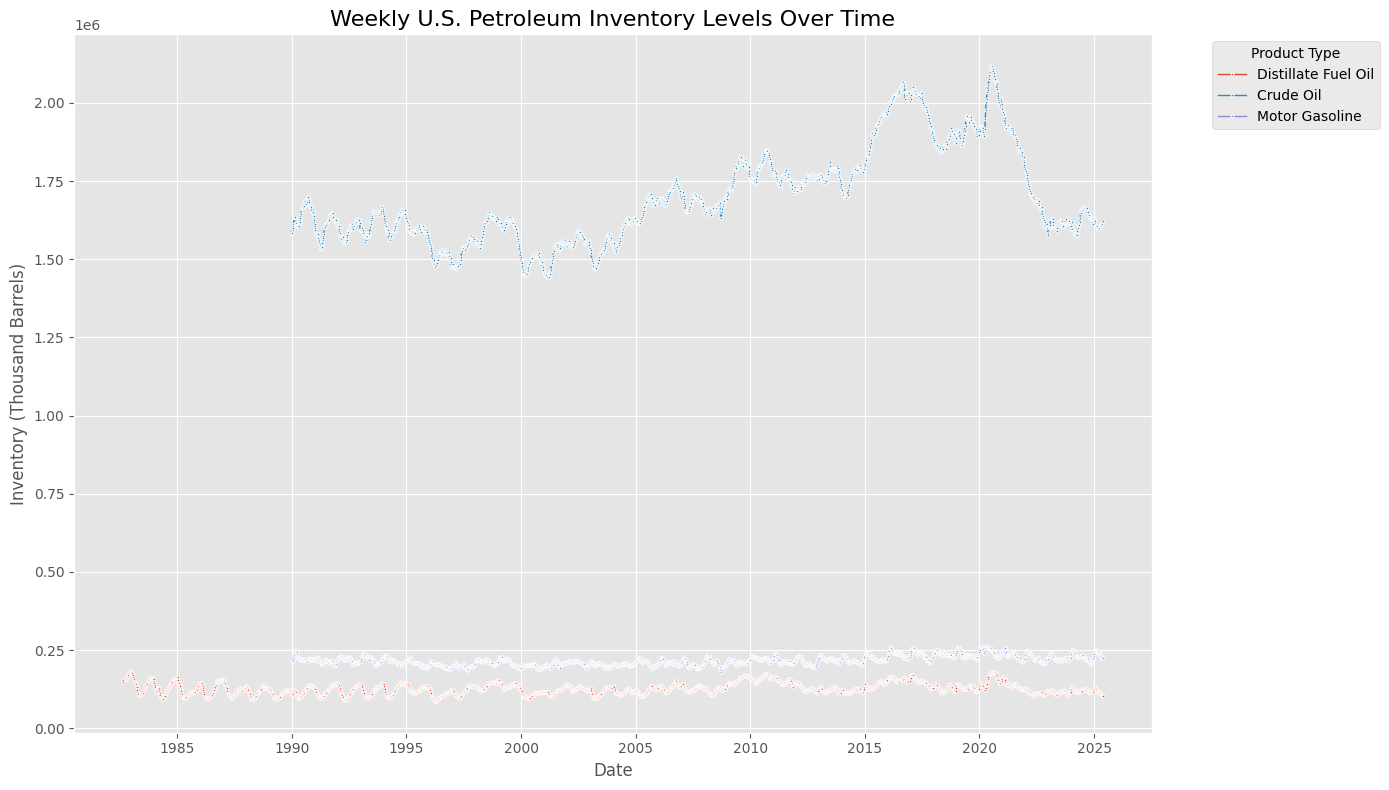

Saved 'all_products_inventory_trend.png'


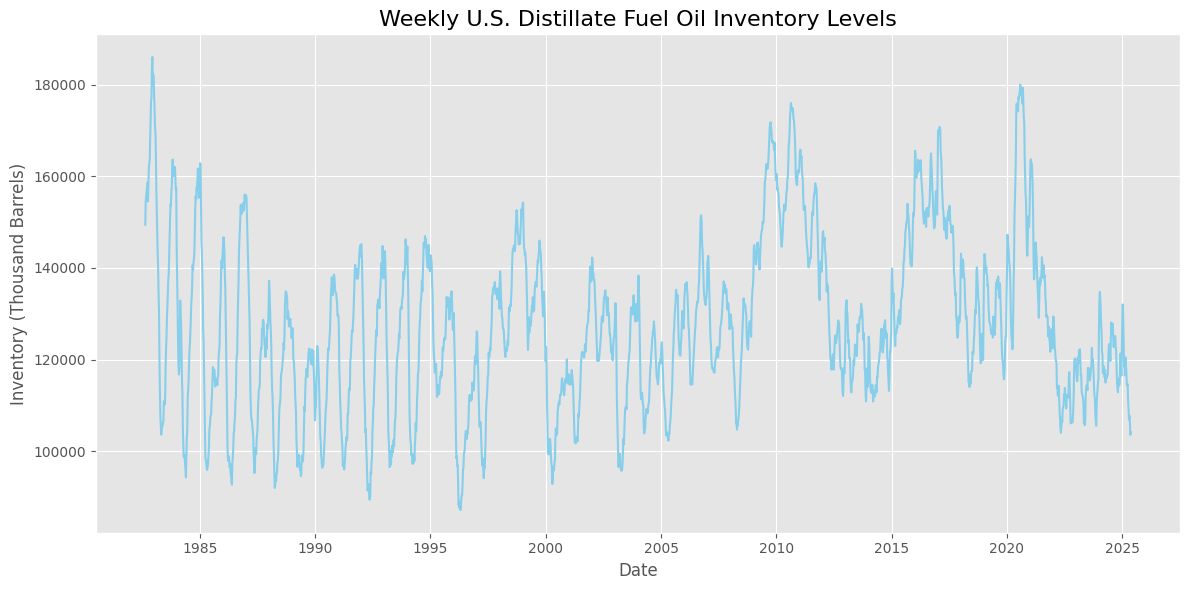

Saved 'distillate_fuel_oil_inventory_trend.png'


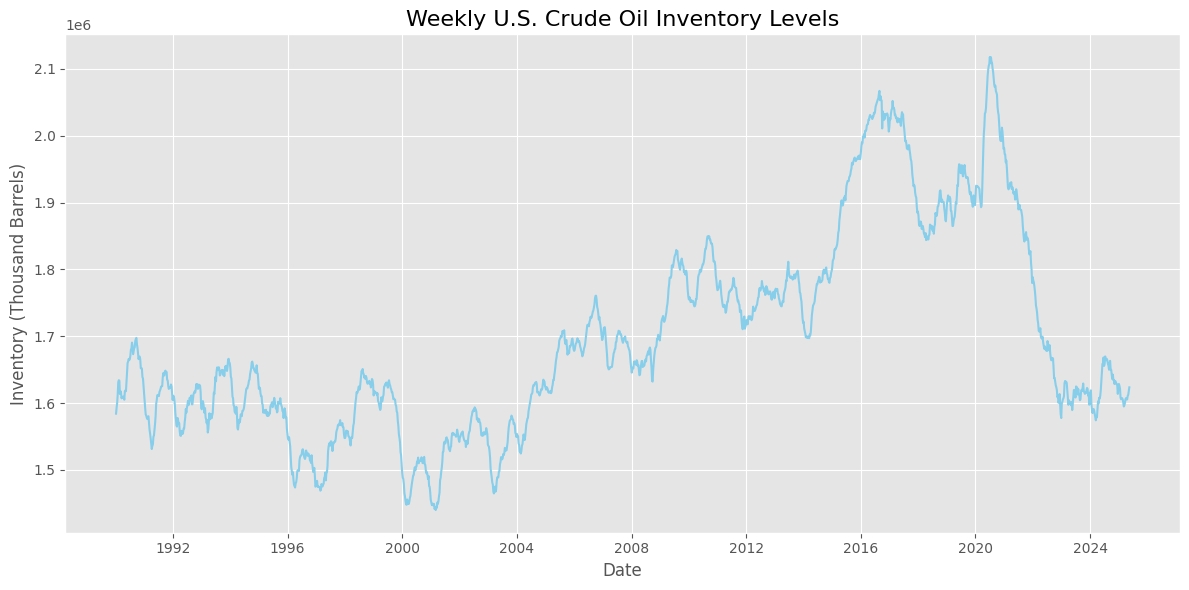

Saved 'crude_oil_inventory_trend.png'


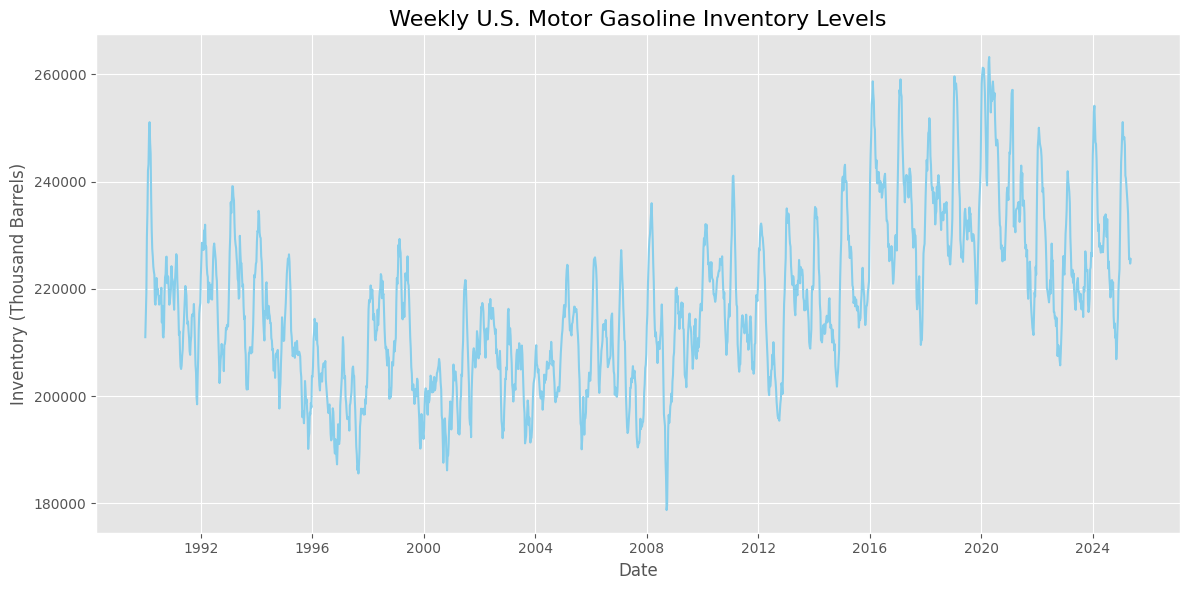

Saved 'motor_gasoline_inventory_trend.png'


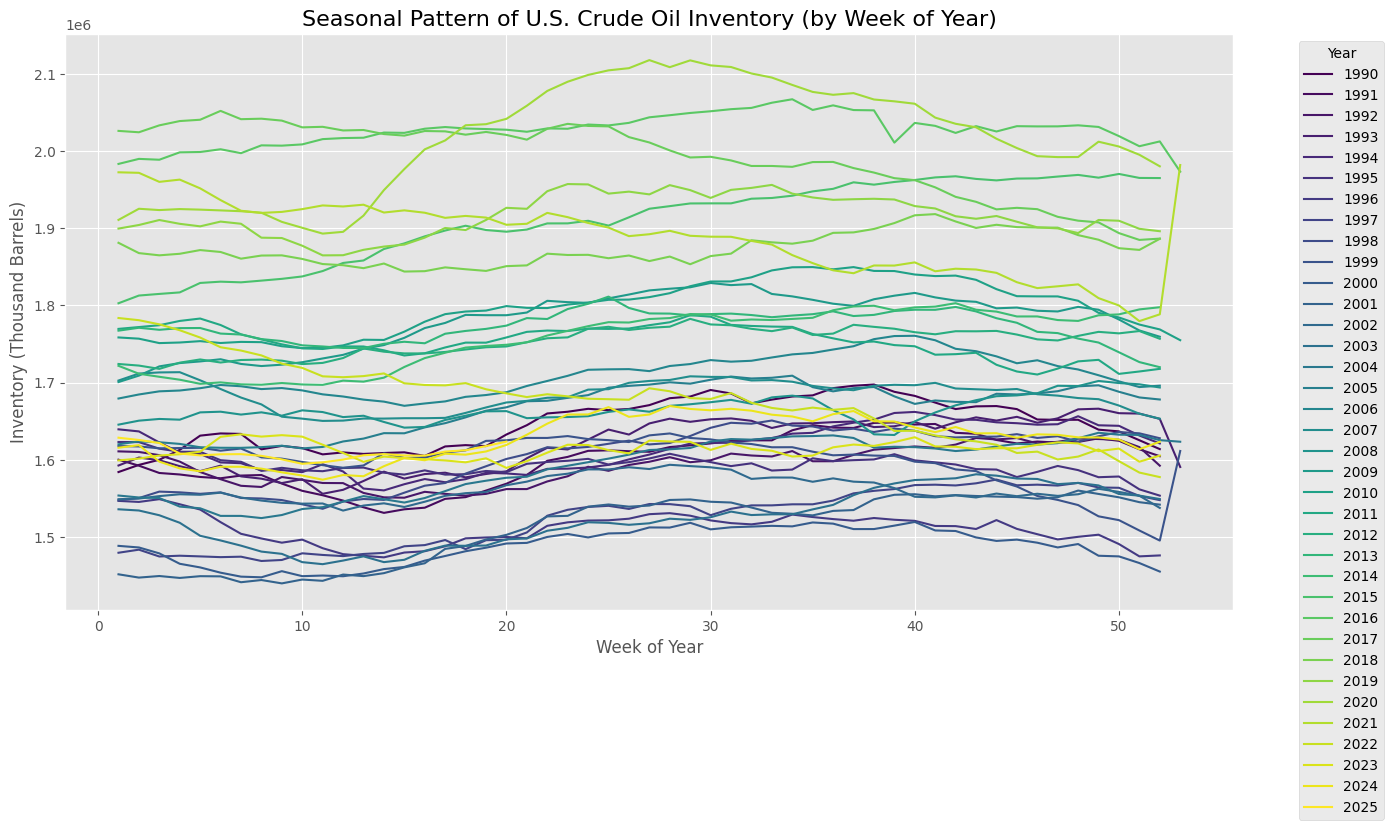

Saved 'crude_oil_seasonal_pattern.png'


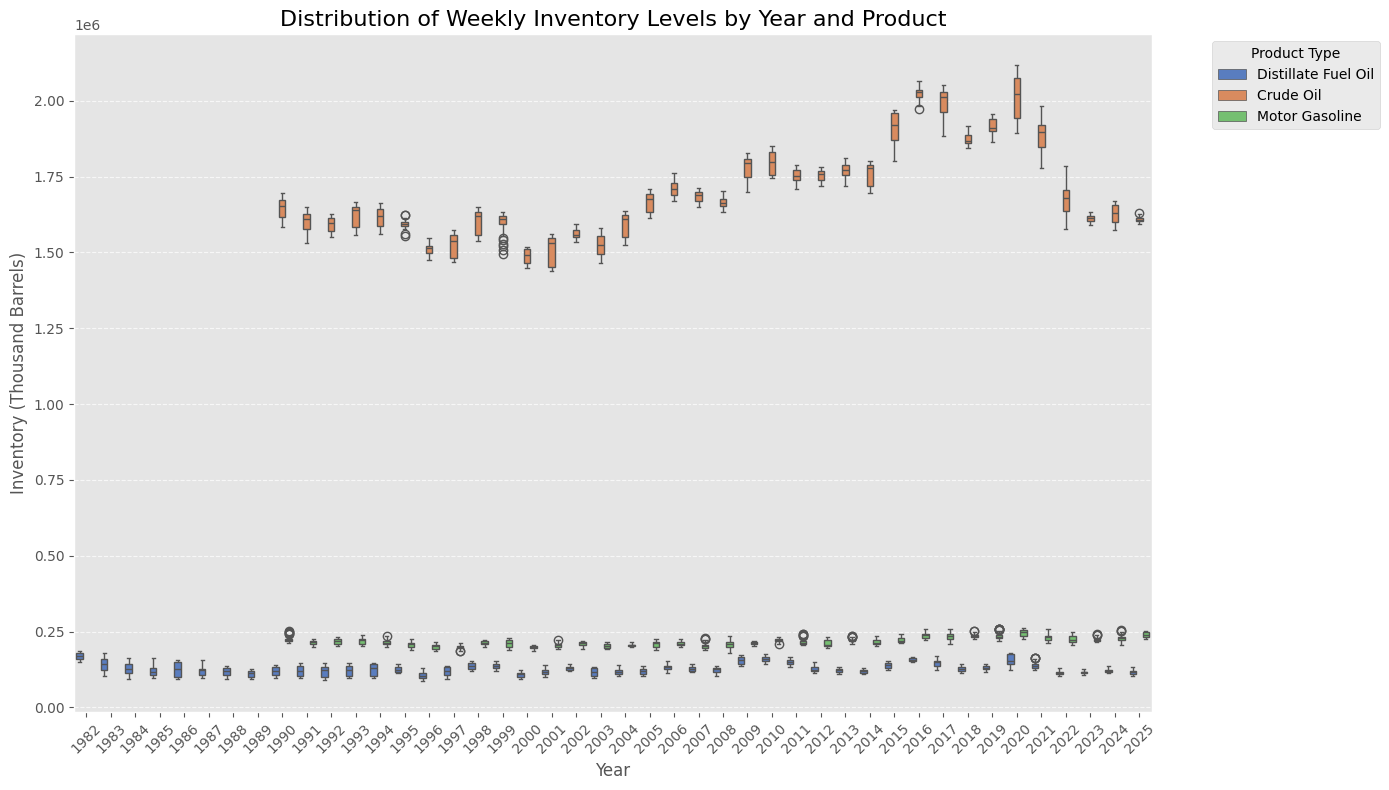

Saved 'inventory_distribution_by_year.png'

Exploratory Data Analysis complete. Check the 'visualizations' folder (in Colab's file browser) for plots.


In [9]:
# --- Colab Cell 1: Install Libraries & Setup Paths ---
# This section ensures necessary libraries are installed and defines file paths for Colab.

# Install openpyxl if not already present (needed for .xls files)
!pip install openpyxl matplotlib seaborn

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths in Colab
# Assuming your uploaded files are in the default /content/ directory
data_dir = '/content/'

# Define the input file names based on what you uploaded
# (Confirm these filenames exactly match what you see in Colab's file browser)
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls')
file_gasoline = os.path.join(data_dir, 'WGTSTUS1w.xls')
file_crude = os.path.join(data_dir, 'WTTSTUS1w.xls')

# Define the output cleaned CSV file name
output_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')
# Define the output directory for visualizations within Colab
output_viz_dir = os.path.join(data_dir, 'visualizations')

# Create the visualizations directory if it doesn't exist
os.makedirs(output_viz_dir, exist_ok=True)

print(f"Files expected: {file_distillate}, {file_gasoline}, {file_crude}")
print(f"Output cleaned data will be saved to: {output_file}")
print(f"Visualizations will be saved to: {output_viz_dir}")

# --- Colab Cell 2: Data Preprocessing Logic ---
# This section contains the function to load and clean EIA data, and then applies it.

def load_and_clean_eia_data(filepath, product_name, header_row_index, sheet_name):
    """
    Loads EIA data from an Excel file, cleans it, and returns a DataFrame.
    'header_row_index' is the 0-indexed row number where the actual column headers are located.
    'sheet_name' is the name of the Excel sheet containing the data.
    """
    try:
        # Load the data from the specified sheet and header row
        df = pd.read_excel(filepath, sheet_name=sheet_name, header=header_row_index)

        # --- Robust Column Renaming ---
        original_cols = df.columns.tolist()

        # Identify the Date column: Look for 'Date', 'Week Ended', or the first column
        date_col = None
        for col in original_cols:
            if isinstance(col, str) and ('date' in col.lower() or 'week ended' in col.lower() or 'observation date' in col.lower()):
                date_col = col
                break
        if date_col is None and original_cols: # Fallback to first column if no explicit date col found
            date_col = original_cols[0]

        # Identify the Value column: It's usually the second column, often named after the series ID
        value_col = None
        if len(original_cols) > 1:
            value_col = original_cols[1]

        if date_col is None or value_col is None:
            print(f"Warning: Could not identify Date ('{date_col}') or Value ('{value_col}') columns in {filepath}. Available columns: {original_cols}")
            return pd.DataFrame() # Return empty DataFrame if columns are not found

        # Rename columns for clarity
        df = df.rename(columns={date_col: 'Date', value_col: 'Value'})

        # Convert 'Date' column to datetime objects
        # Use errors='coerce' to turn unparseable dates into NaT
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Add a 'Product' column to identify the type of inventory
        df['Product'] = product_name

        # Handle potential non-numeric values in 'Value' (e.g., 'NA' or empty strings)
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

        # Drop rows where both Date and Value are NaN (likely empty rows from Excel's skipped metadata)
        df.dropna(subset=['Date', 'Value'], how='all', inplace=True)

        # Handle missing values in 'Value': Forward fill (propagates last valid observation forward)
        df['Value'] = df['Value'].ffill()

        # Drop any rows where 'Date' is still NaT after conversion (failed parsing)
        df.dropna(subset=['Date'], inplace=True)

        # Select only the relevant columns and sort by date
        df = df[['Date', 'Product', 'Value']].sort_values(by='Date').reset_index(drop=True)

        print(f"Successfully loaded and cleaned {filepath} for {product_name}.")
        print(f"Shape: {df.shape}")
        print(f"Missing values after cleaning:\n{df.isnull().sum()}")
        print(f"First 5 rows for {product_name}:\n{df.head()}")
        print(f"Last 5 rows for {product_name}:\n{df.tail()}")

        return df

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}. Please ensure it's uploaded to Colab.")
        return pd.DataFrame() # Return empty DataFrame on error
    except Exception as e:
        print(f"An error occurred while processing {filepath}: {e}")
        return pd.DataFrame()

# --- Call the function for each dataset with the identified parameters ---
# CONFIRMED: Sheet name is 'Data 1'
SHEET_NAME = 'Data 1'
# CONFIRMED: Header row is the 3rd row, so header_row_index = 2
HEADER_ROW_INDEX = 2

print("\n--- Processing Distillate Data ---")
df_distillate = load_and_clean_eia_data(file_distillate, 'Distillate Fuel Oil', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Gasoline Data ---")
df_gasoline = load_and_clean_eia_data(file_gasoline, 'Motor Gasoline', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Crude Oil Data ---")
df_crude = load_and_clean_eia_data(file_crude, 'Crude Oil', HEADER_ROW_INDEX, SHEET_NAME)

# --- Combine all DataFrames ---
all_dfs = [df for df in [df_distillate, df_gasoline, df_crude] if not df.empty]

if all_dfs:
    combined_df = pd.concat(all_dfs).sort_values(by=['Date', 'Product']).reset_index(drop=True)

    # Optional: Check for duplicate dates/products
    combined_df.drop_duplicates(subset=['Date', 'Product'], inplace=True)

    # Save the combined, cleaned data to CSV in Colab's content directory
    combined_df.to_csv(output_file, index=False)
    print(f"\nCombined and cleaned data saved to {output_file}")
    print(f"Final combined DataFrame shape: {combined_df.shape}")
    print(f"Unique products in combined data: {combined_df['Product'].unique()}")
    print(f"Combined data first 5 rows:\n{combined_df.head()}")
    print(f"Combined data last 5 rows:\n{combined_df.tail()}")
else:
    print("\nNo data was successfully loaded and combined.")

# --- Colab Cell 3: Exploratory Data Analysis Logic ---
# This section performs EDA using the combined, cleaned data.

try:
    # Load the cleaned data (if not already in memory from previous step)
    # This ensures the EDA section can run independently if needed.
    if 'combined_df' not in locals() or combined_df.empty:
        df = pd.read_csv(cleaned_data_file)
        df['Date'] = pd.to_datetime(df['Date']) # Ensure Date is datetime type
    else:
        df = combined_df.copy() # Use the DataFrame directly if already processed

    print(f"\n--- Starting Exploratory Data Analysis ---")
    print(f"Data shape for EDA: {df.shape}")
    print(f"Unique products for EDA: {df['Product'].unique()}")
    print("\nDataFrame Info (for EDA):")
    df.info()
    print("\nDescriptive Statistics (for EDA):")
    print(df.describe())

    # --- Time Series Analysis ---
    plt.style.use('ggplot') # A nice style for plots

    # Plot 1: Historical Trends for All Products
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df, x='Date', y='Value', hue='Product', marker='o', markersize=2, linewidth=1)
    plt.title('Weekly U.S. Petroleum Inventory Levels Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
    plt.grid(True)
    plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'all_products_inventory_trend.png'))
    plt.show()
    print("Saved 'all_products_inventory_trend.png'")

    # Plot 2: Individual Trends
    products = df['Product'].unique()
    for product in products:
        product_df = df[df['Product'] == product].sort_values(by='Date')
        if not product_df.empty: # Only plot if data exists for the product
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=product_df, x='Date', y='Value', color='skyblue')
            plt.title(f'Weekly U.S. {product} Inventory Levels', fontsize=16)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(output_viz_dir, f'{product.lower().replace(" ", "_")}_inventory_trend.png'))
            plt.show()
            print(f"Saved '{product.lower().replace(' ', '_')}_inventory_trend.png'")
        else:
            print(f"No data to plot for {product}.")


    # Plot 3: Annual Seasonal Patterns (Example: Crude Oil)
    # Extract Year and Week of Year
    df['Year'] = df['Date'].dt.year
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week.astype(int)

    # Focus on Crude Oil for seasonality example
    crude_oil_df = df[df['Product'] == 'Crude Oil']

    if not crude_oil_df.empty:
        plt.figure(figsize=(14, 8))
        sns.lineplot(data=crude_oil_df, x='Week_of_Year', y='Value', hue='Year', palette='viridis', legend='full')
        plt.title('Seasonal Pattern of U.S. Crude Oil Inventory (by Week of Year)', fontsize=16)
        plt.xlabel('Week of Year', fontsize=12)
        plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
        plt.grid(True)
        plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(output_viz_dir, 'crude_oil_seasonal_pattern.png'))
        plt.show()
        print("Saved 'crude_oil_seasonal_pattern.png'")
    else:
        print("Crude Oil data not found for seasonal analysis (check 'Product' name consistency).")

    # Plot 4: Box Plot of Inventory by Year (to see distribution changes)
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Year', y='Value', hue='Product', palette='muted')
    plt.title('Distribution of Weekly Inventory Levels by Year and Product', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'inventory_distribution_by_year.png'))
    plt.show()
    print("Saved 'inventory_distribution_by_year.png'")

    print("\nExploratory Data Analysis complete. Check the 'visualizations' folder (in Colab's file browser) for plots.")

except FileNotFoundError:
    print(f"Error: Cleaned data file not found at {cleaned_data_file}. Please ensure data preprocessing ran successfully.")
except Exception as e:
    print(f"An error occurred during EDA: {e}")


--- Starting Exploratory Data Analysis ---
Data shape for EDA: (5917, 3)
Unique products for EDA: ['Distillate Fuel Oil' 'Crude Oil' 'Motor Gasoline']

DataFrame Info (for EDA):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5917 entries, 0 to 5916
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     5917 non-null   datetime64[ns]
 1   Product  5917 non-null   object        
 2   Value    5917 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 138.8+ KB

Descriptive Statistics (for EDA):
                                Date         Value
count                           5917  5.917000e+03
mean   2006-04-29 13:32:06.854825088  6.454808e+05
min              1982-08-20 00:00:00  8.715300e+04
25%              1997-01-10 00:00:00  1.336390e+05
50%              2006-06-23 00:00:00  2.116350e+05
75%              2015-12-04 00:00:00  1.571761e+06
max              2025-05-16

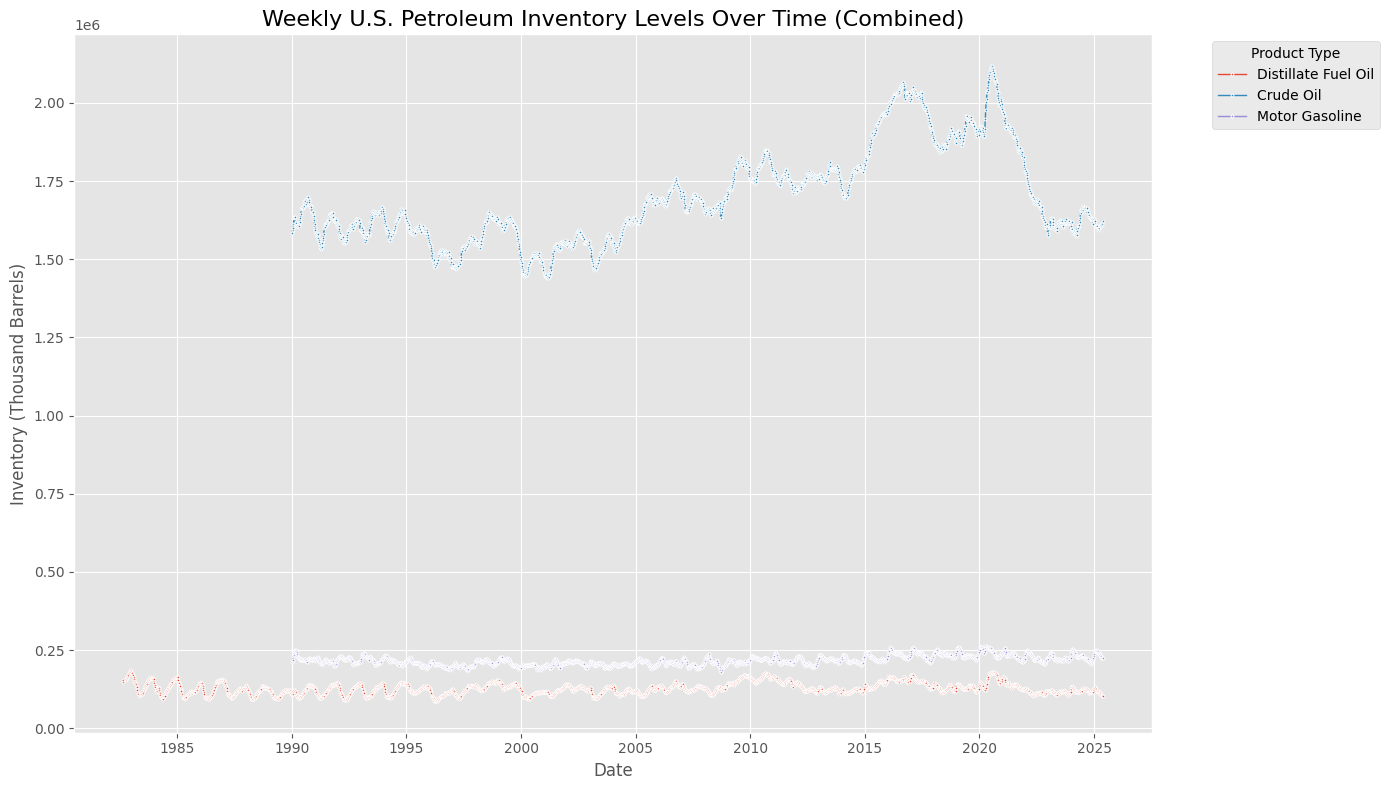

Saved 'all_products_inventory_trend_combined.png'


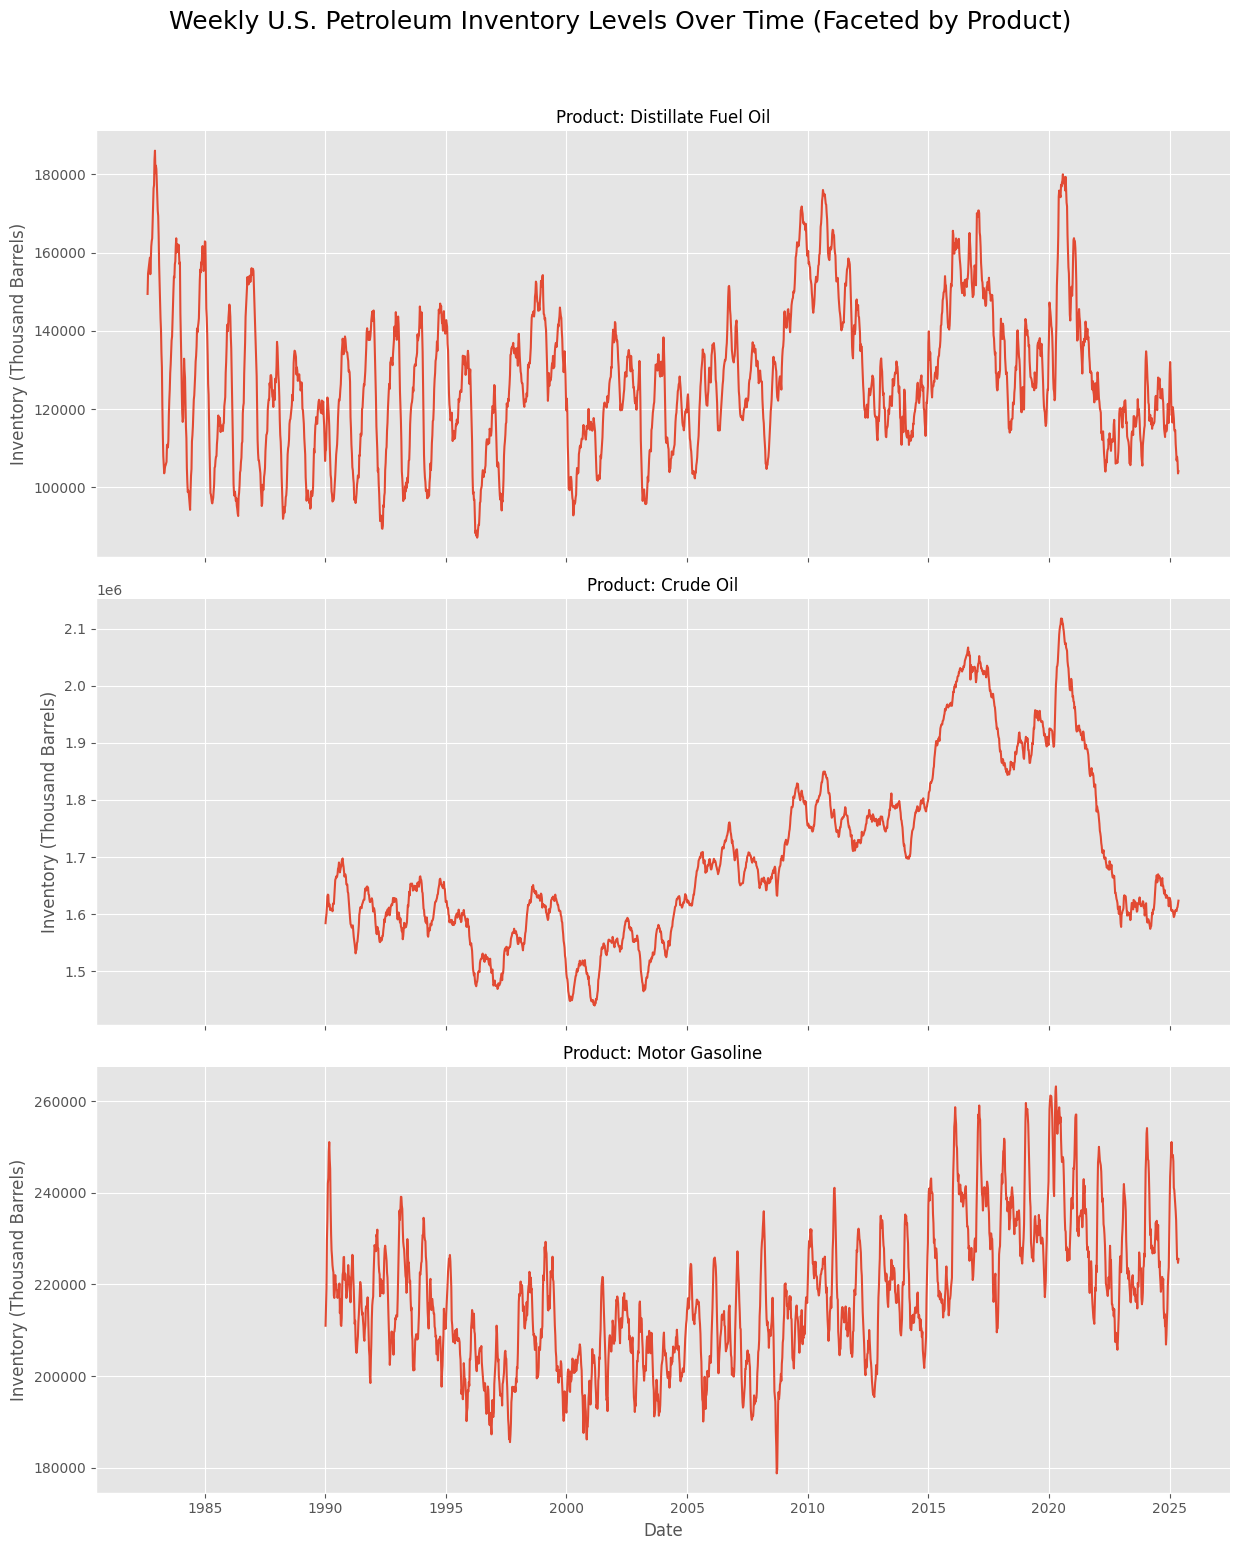

Saved 'all_products_inventory_trend_faceted.png'


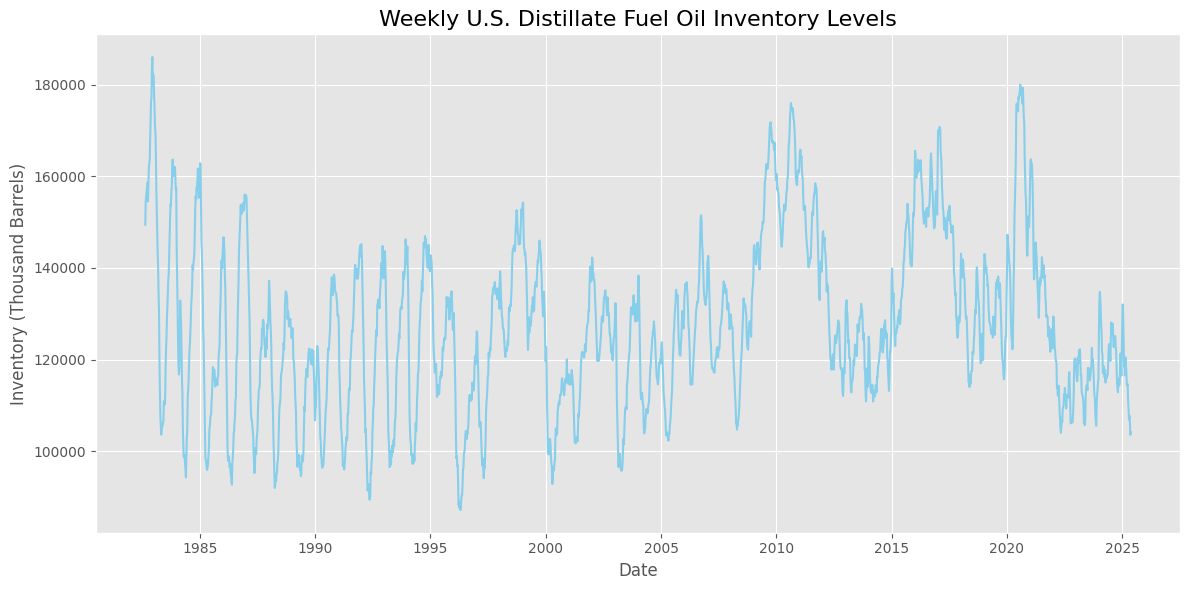

Saved 'distillate_fuel_oil_inventory_trend.png'


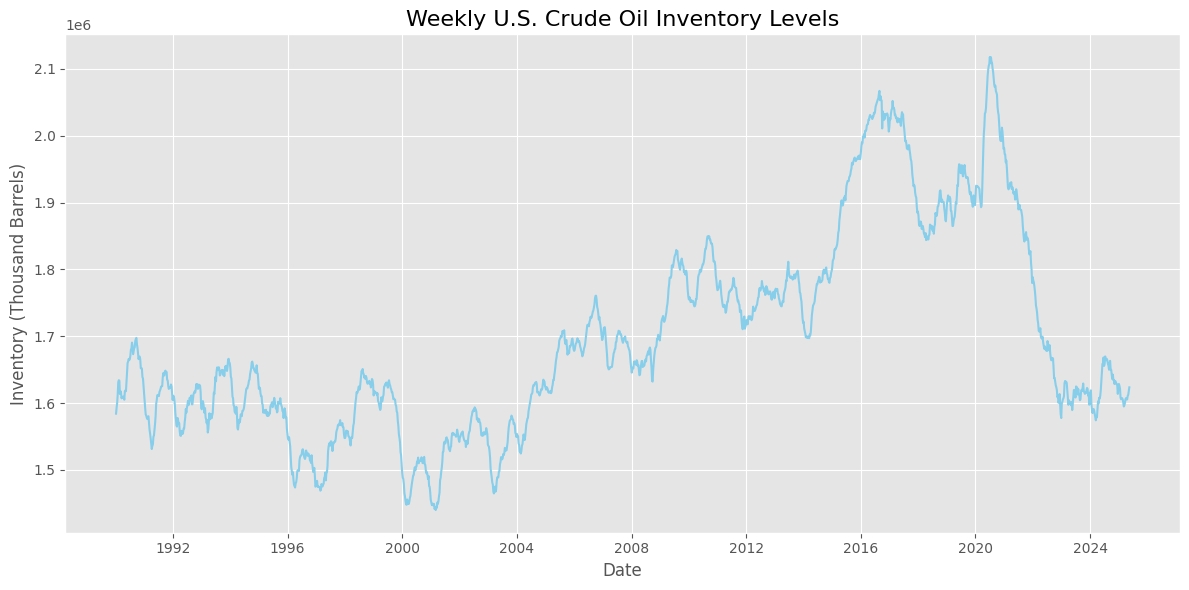

Saved 'crude_oil_inventory_trend.png'


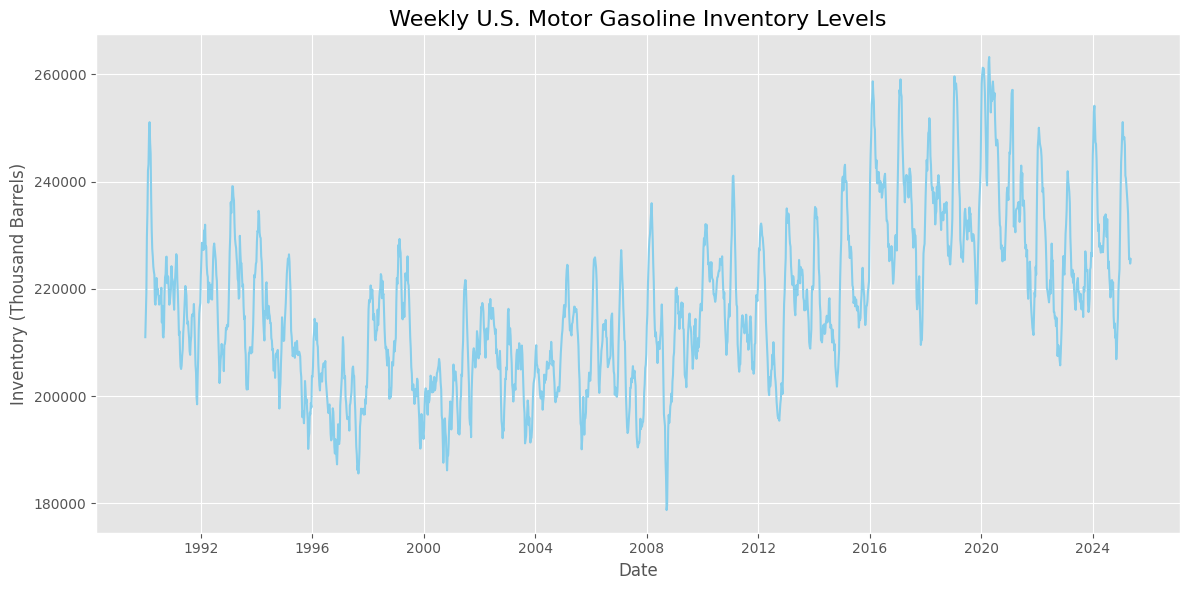

Saved 'motor_gasoline_inventory_trend.png'


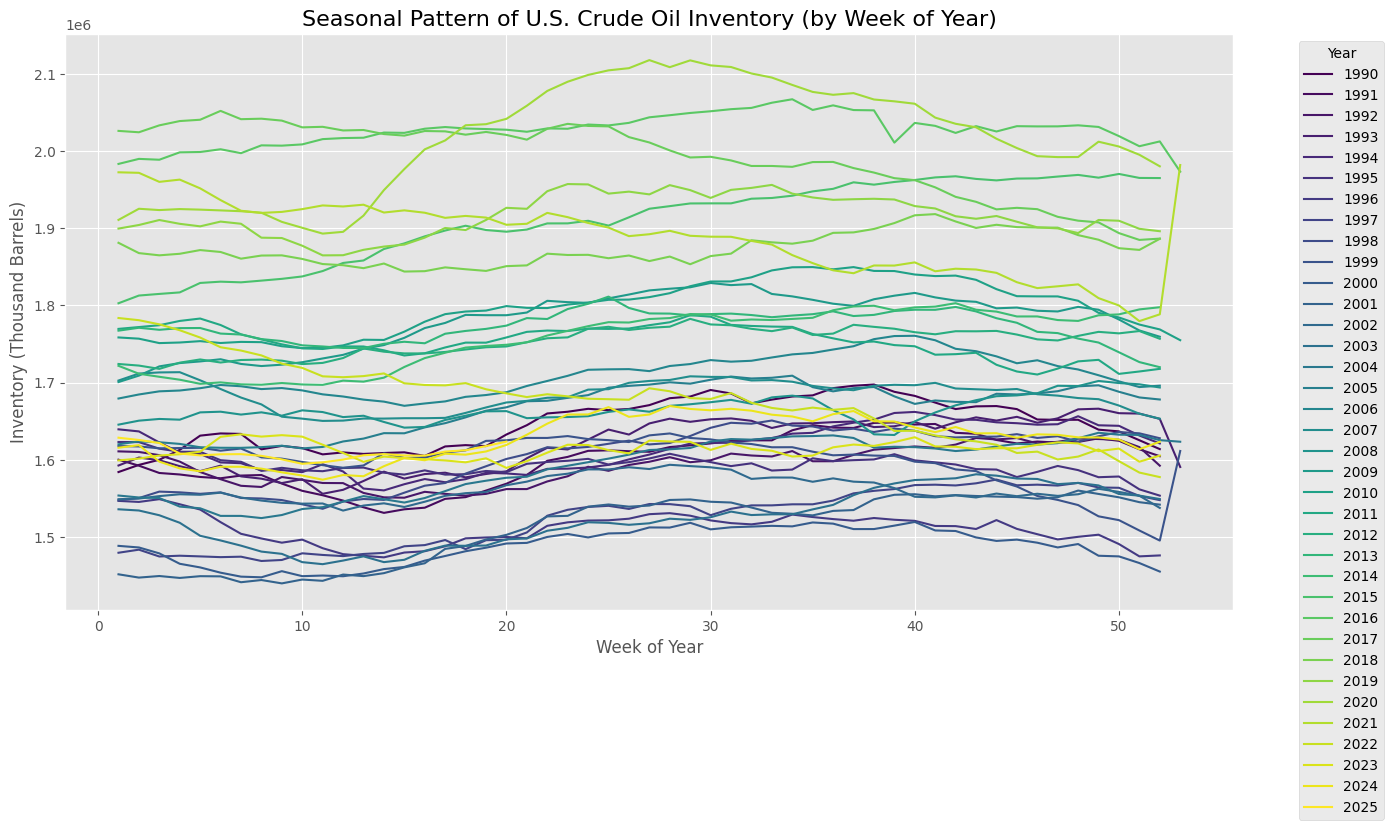

Saved 'crude_oil_seasonal_pattern.png'


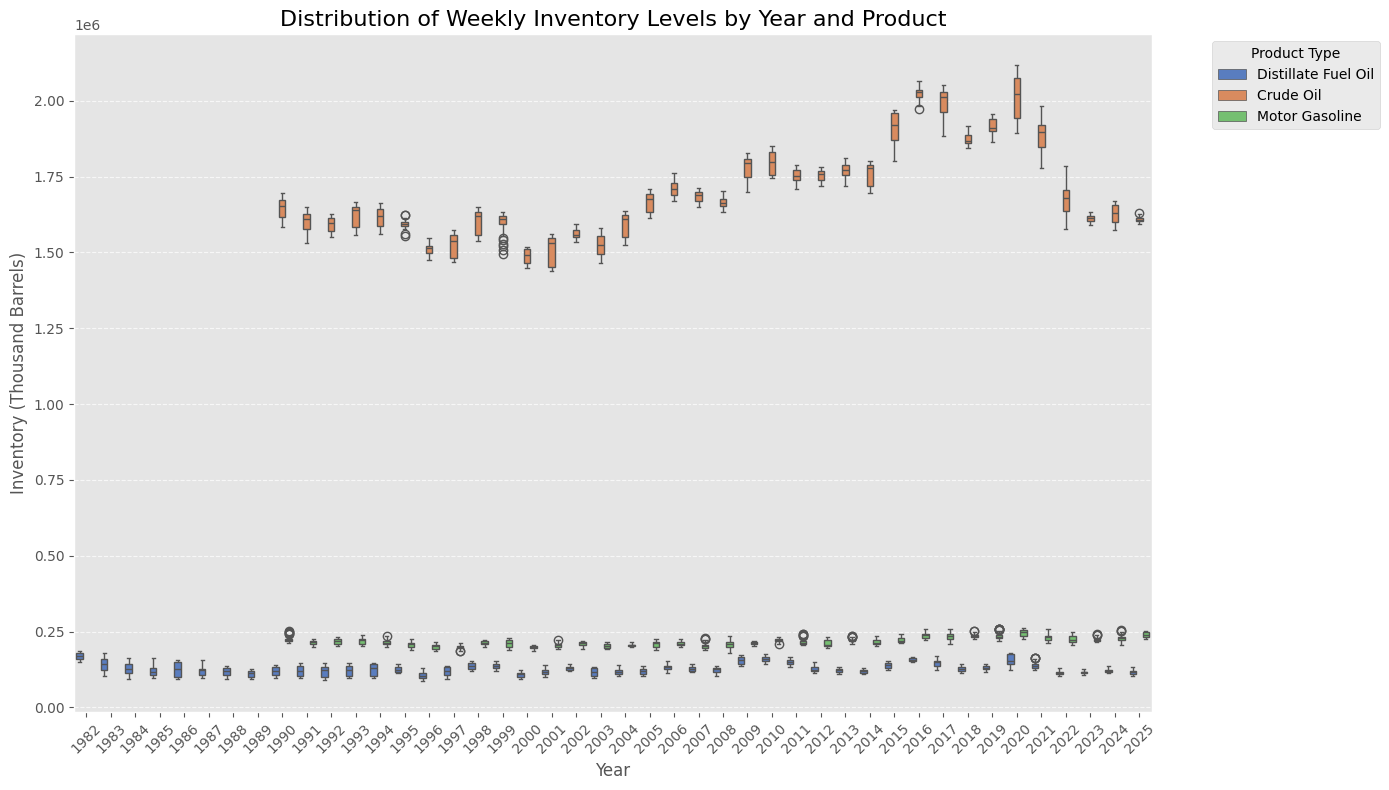

Saved 'inventory_distribution_by_year.png'

Exploratory Data Analysis complete. Check the 'visualizations' folder (in Colab's file browser) for plots.


In [10]:
# --- Colab Cell 3: Exploratory Data Analysis Logic (Revised) ---
# This section performs EDA using the combined, cleaned data.

try:
    # Load the cleaned data (if not already in memory from previous step)
    if 'combined_df' not in locals() or combined_df.empty:
        df = pd.read_csv(output_file) # Changed to output_file consistent with path
        df['Date'] = pd.to_datetime(df['Date']) # Ensure Date is datetime type
    else:
        df = combined_df.copy() # Use the DataFrame directly if already processed

    print(f"\n--- Starting Exploratory Data Analysis ---")
    print(f"Data shape for EDA: {df.shape}")
    print(f"Unique products for EDA: {df['Product'].unique()}")
    print("\nDataFrame Info (for EDA):")
    df.info()
    print("\nDescriptive Statistics (for EDA):")
    print(df.describe())

    # --- Time Series Analysis ---
    plt.style.use('ggplot') # A nice style for plots

    # Plot 1: Historical Trends for All Products (Original combined view)
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df, x='Date', y='Value', hue='Product', marker='o', markersize=2, linewidth=1)
    plt.title('Weekly U.S. Petroleum Inventory Levels Over Time (Combined)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
    plt.grid(True)
    plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'all_products_inventory_trend_combined.png'))
    plt.show()
    print("Saved 'all_products_inventory_trend_combined.png'")


    # Plot 1.5: Historical Trends for All Products (Faceted - easier to see individual trends)
    # Using relplot for faceting
    g = sns.relplot(
        data=df,
        x='Date',
        y='Value',
        col='Product',
        kind='line',
        col_wrap=1,  # Puts each product in its own row
        height=5, aspect=2.5, # Adjust height and aspect ratio for readability
        facet_kws={'sharey': False, 'sharex': True} # Each subplot gets its own y-axis scale
    )
    g.fig.suptitle('Weekly U.S. Petroleum Inventory Levels Over Time (Faceted by Product)',
                   y=1.03, # Adjust title position
                   fontsize=18)
    g.set_axis_labels('Date', 'Inventory (Thousand Barrels)')
    g.set_titles("Product: {col_name}")
    g.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'all_products_inventory_trend_faceted.png'))
    plt.show()
    print("Saved 'all_products_inventory_trend_faceted.png'")

    # Plot 2: Individual Trends (Original, still useful for detailed focus)
    products = df['Product'].unique()
    for product in products:
        product_df = df[df['Product'] == product].sort_values(by='Date')
        if not product_df.empty:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=product_df, x='Date', y='Value', color='skyblue')
            plt.title(f'Weekly U.S. {product} Inventory Levels', fontsize=16)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(output_viz_dir, f'{product.lower().replace(" ", "_")}_inventory_trend.png'))
            plt.show()
            print(f"Saved '{product.lower().replace(' ', '_')}_inventory_trend.png'")
        else:
            print(f"No data to plot for {product}.")


    # Plot 3: Annual Seasonal Patterns (Example: Crude Oil)
    df['Year'] = df['Date'].dt.year
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week.astype(int)

    crude_oil_df = df[df['Product'] == 'Crude Oil']

    if not crude_oil_df.empty:
        plt.figure(figsize=(14, 8))
        sns.lineplot(data=crude_oil_df, x='Week_of_Year', y='Value', hue='Year', palette='viridis', legend='full')
        plt.title('Seasonal Pattern of U.S. Crude Oil Inventory (by Week of Year)', fontsize=16)
        plt.xlabel('Week of Year', fontsize=12)
        plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
        plt.grid(True)
        plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(output_viz_dir, 'crude_oil_seasonal_pattern.png'))
        plt.show()
        print("Saved 'crude_oil_seasonal_pattern.png'")
    else:
        print("Crude Oil data not found for seasonal analysis (check 'Product' name consistency).")

    # Plot 4: Box Plot of Inventory by Year (to see distribution changes)
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Year', y='Value', hue='Product', palette='muted')
    plt.title('Distribution of Weekly Inventory Levels by Year and Product', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'inventory_distribution_by_year.png'))
    plt.show()
    print("Saved 'inventory_distribution_by_year.png'")

    print("\nExploratory Data Analysis complete. Check the 'visualizations' folder (in Colab's file browser) for plots.")

except FileNotFoundError:
    print(f"Error: Cleaned data file not found at {output_file}. Please ensure data preprocessing ran successfully.")
except Exception as e:
    print(f"An error occurred during EDA: {e}")


--- Starting Exploratory Data Analysis ---
Data shape for EDA: (5917, 3)
Unique products for EDA: ['Distillate Fuel Oil' 'Crude Oil' 'Motor Gasoline']

DataFrame Info (for EDA):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5917 entries, 0 to 5916
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     5917 non-null   datetime64[ns]
 1   Product  5917 non-null   object        
 2   Value    5917 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 138.8+ KB

Descriptive Statistics (for EDA):
                                Date         Value
count                           5917  5.917000e+03
mean   2006-04-29 13:32:06.854825088  6.454808e+05
min              1982-08-20 00:00:00  8.715300e+04
25%              1997-01-10 00:00:00  1.336390e+05
50%              2006-06-23 00:00:00  2.116350e+05
75%              2015-12-04 00:00:00  1.571761e+06
max              2025-05-16

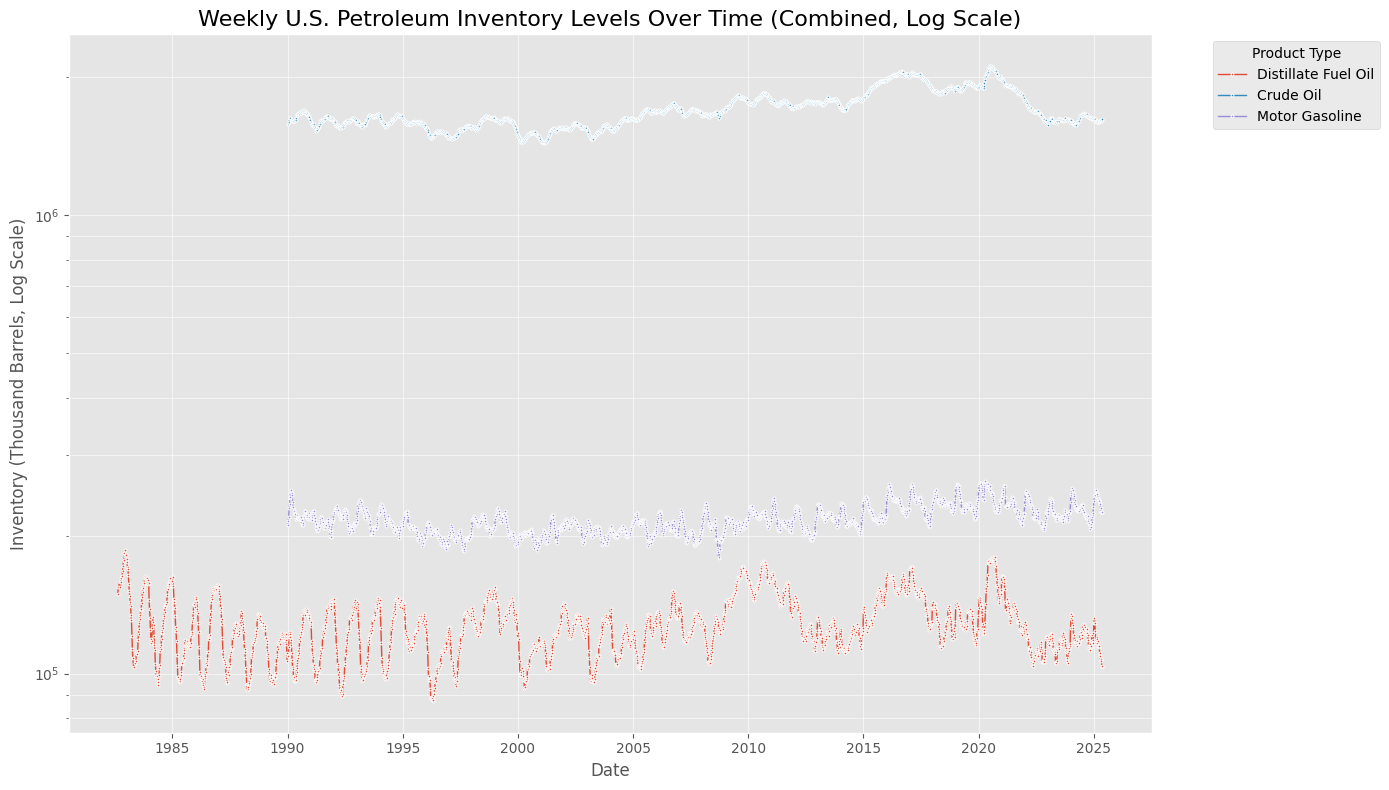

Saved 'all_products_inventory_trend_combined_log_scale.png'


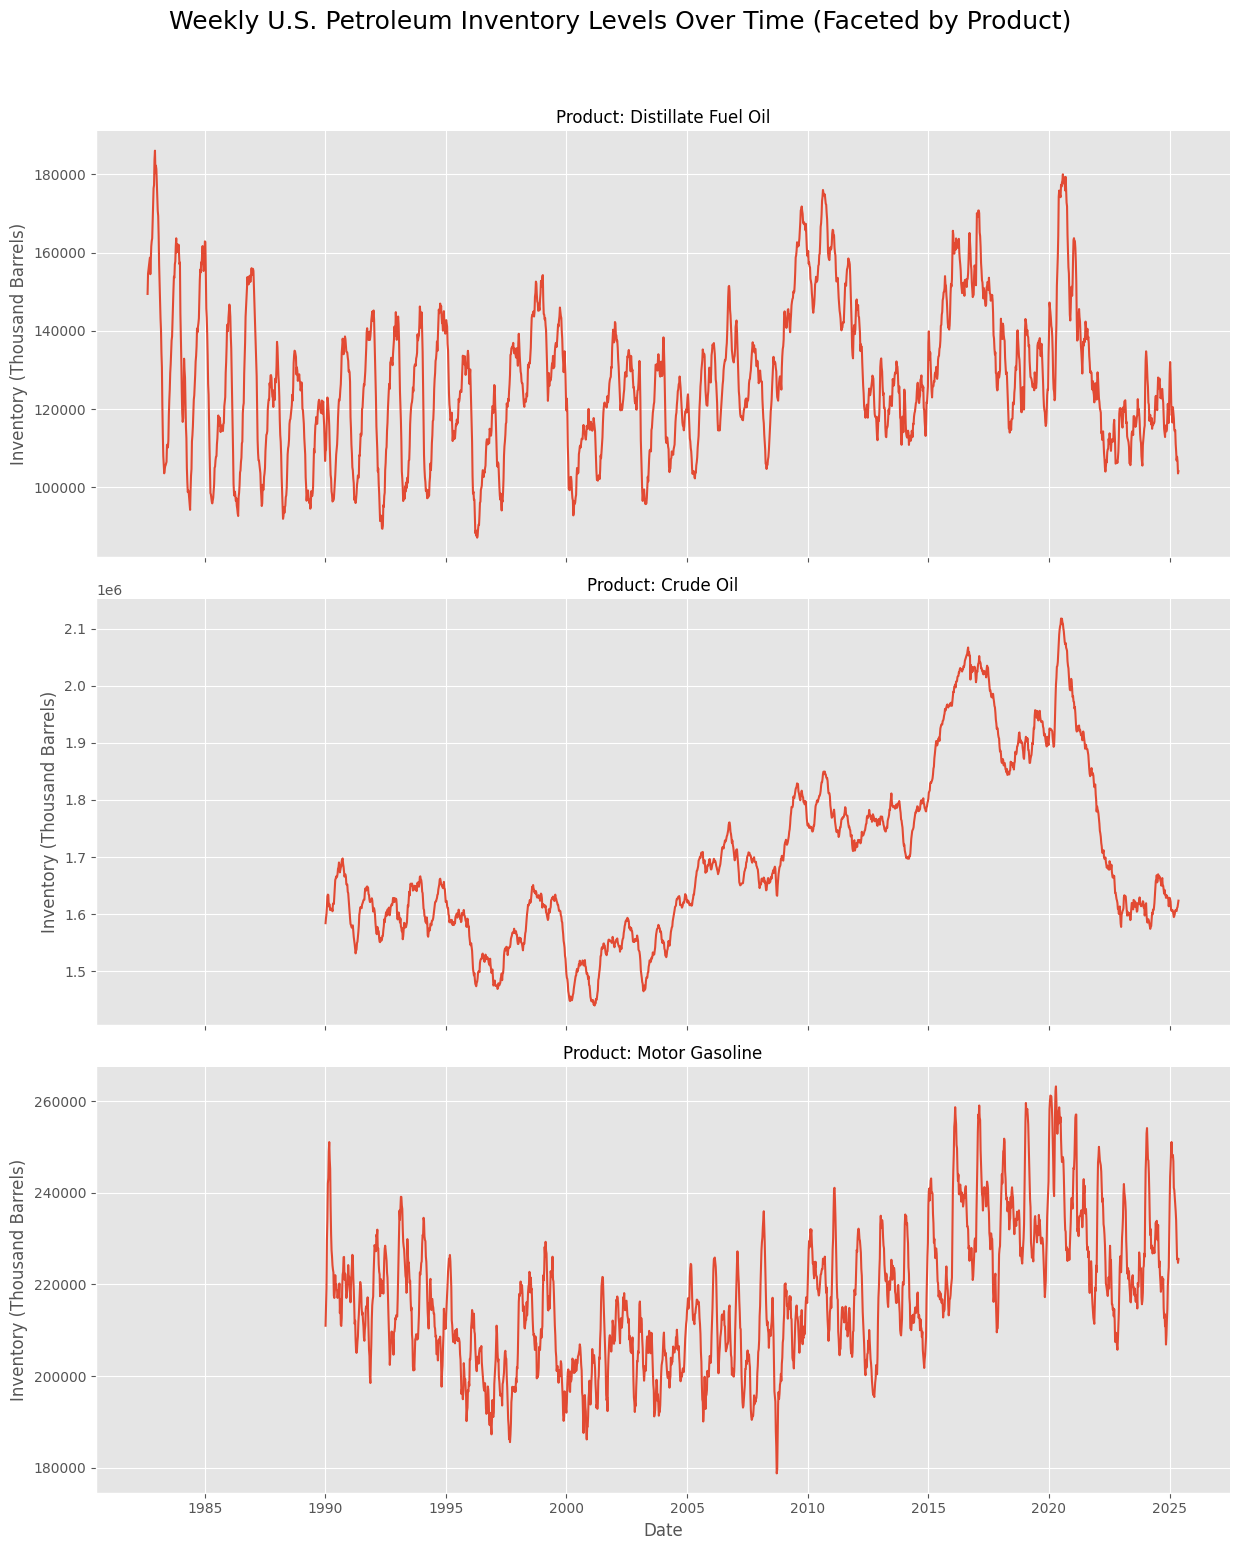

Saved 'all_products_inventory_trend_faceted.png'


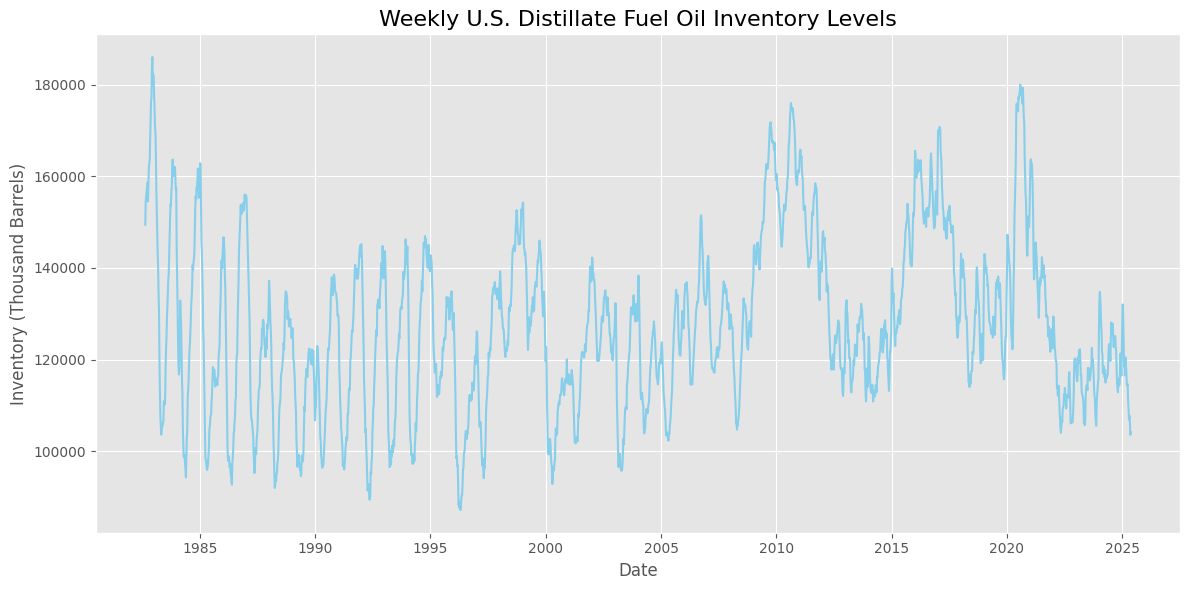

Saved 'distillate_fuel_oil_inventory_trend.png'


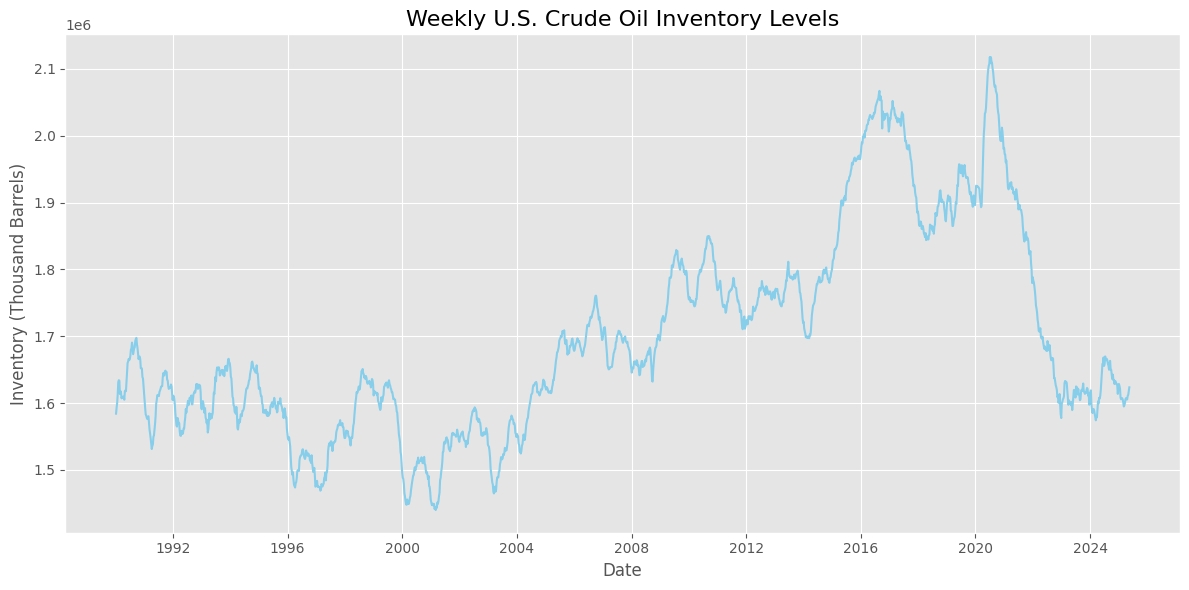

Saved 'crude_oil_inventory_trend.png'


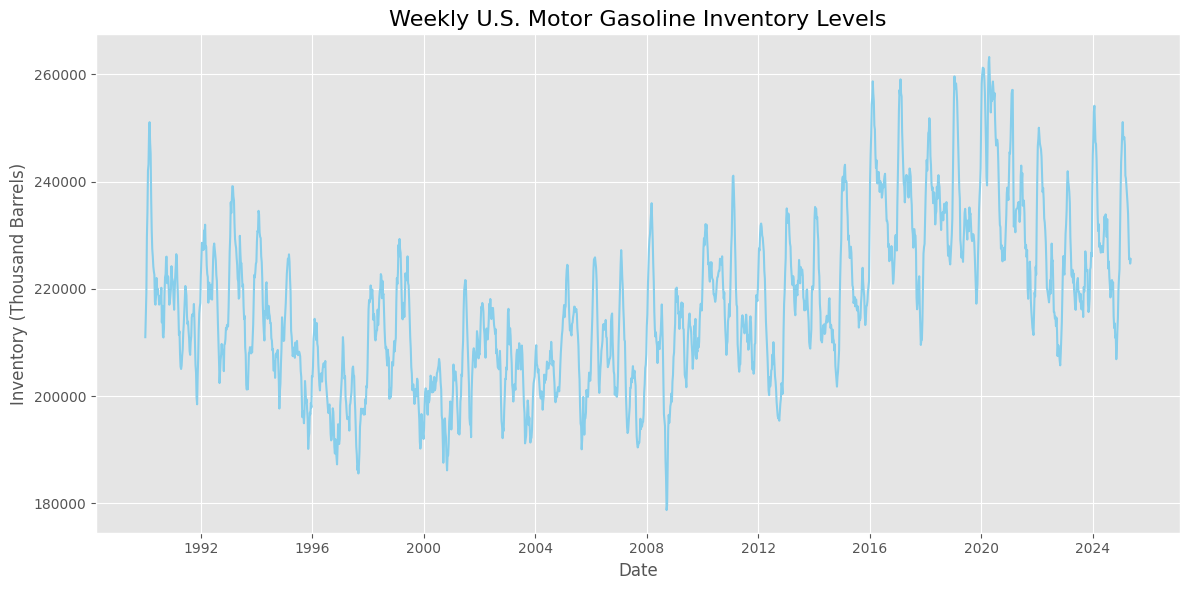

Saved 'motor_gasoline_inventory_trend.png'


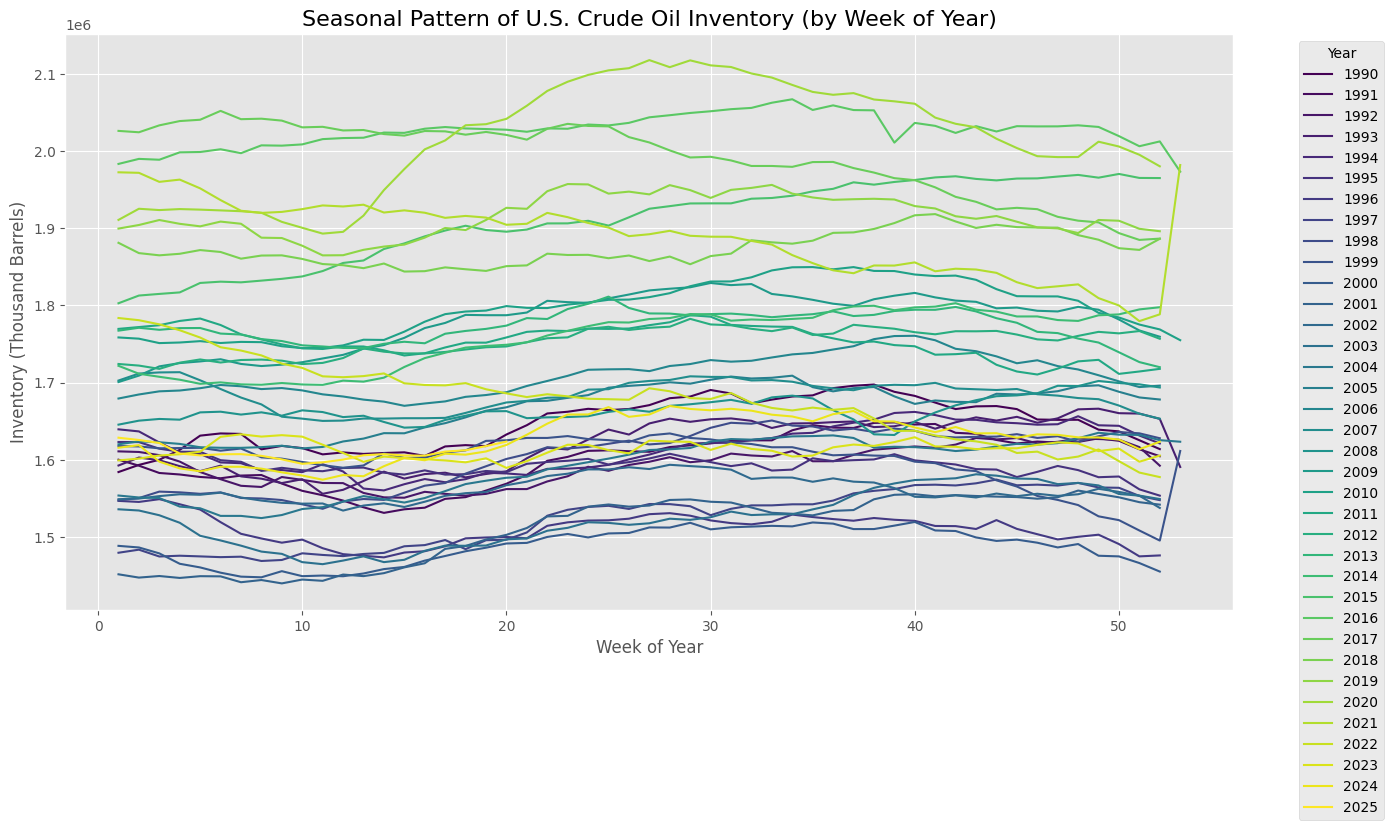

Saved 'crude_oil_seasonal_pattern.png'


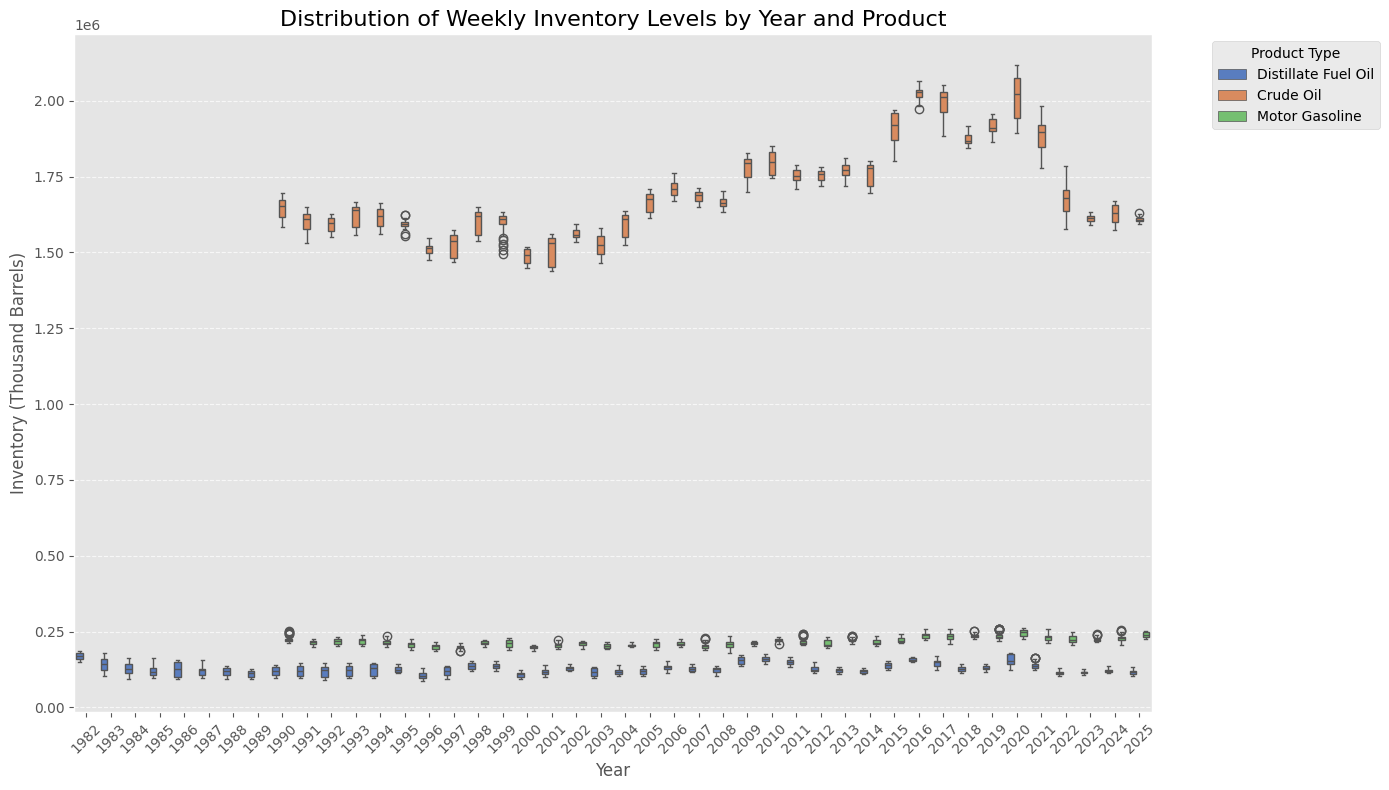

Saved 'inventory_distribution_by_year.png'

Exploratory Data Analysis complete. Check the 'visualizations' folder (in Colab's file browser) for plots.


In [11]:
# --- Colab Cell 3: Exploratory Data Analysis Logic (Revised with Log Scale) ---
# This section performs EDA using the combined, cleaned data.

try:
    # Load the cleaned data (if not already in memory from previous step)
    if 'combined_df' not in locals() or combined_df.empty:
        df = pd.read_csv(output_file) # Changed to output_file consistent with path
        df['Date'] = pd.to_datetime(df['Date']) # Ensure Date is datetime type
    else:
        df = combined_df.copy() # Use the DataFrame directly if already processed

    print(f"\n--- Starting Exploratory Data Analysis ---")
    print(f"Data shape for EDA: {df.shape}")
    print(f"Unique products for EDA: {df['Product'].unique()}")
    print("\nDataFrame Info (for EDA):")
    df.info()
    print("\nDescriptive Statistics (for EDA):")
    print(df.describe())

    # --- Time Series Analysis ---
    plt.style.use('ggplot') # A nice style for plots

    # Plot 1: Historical Trends for All Products (Combined with Logarithmic Y-axis)
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df, x='Date', y='Value', hue='Product', marker='o', markersize=2, linewidth=1)
    plt.title('Weekly U.S. Petroleum Inventory Levels Over Time (Combined, Log Scale)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Inventory (Thousand Barrels, Log Scale)', fontsize=12)
    plt.yscale('log') # <--- KEY CHANGE: Set y-axis to logarithmic scale
    plt.grid(True, which="both", ls="-", alpha=0.6) # Improve grid for log scale
    plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'all_products_inventory_trend_combined_log_scale.png'))
    plt.show()
    print("Saved 'all_products_inventory_trend_combined_log_scale.png'")


    # Plot 1.5: Historical Trends for All Products (Faceted - easier to see individual trends)
    # Using relplot for faceting
    g = sns.relplot(
        data=df,
        x='Date',
        y='Value',
        col='Product',
        kind='line',
        col_wrap=1,  # Puts each product in its own row
        height=5, aspect=2.5, # Adjust height and aspect ratio for readability
        facet_kws={'sharey': False, 'sharex': True} # Each subplot gets its own y-axis scale
    )
    g.fig.suptitle('Weekly U.S. Petroleum Inventory Levels Over Time (Faceted by Product)',
                   y=1.03, # Adjust title position
                   fontsize=18)
    g.set_axis_labels('Date', 'Inventory (Thousand Barrels)')
    g.set_titles("Product: {col_name}")
    g.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'all_products_inventory_trend_faceted.png'))
    plt.show()
    print("Saved 'all_products_inventory_trend_faceted.png'")

    # Plot 2: Individual Trends (Original, still useful for detailed focus)
    products = df['Product'].unique()
    for product in products:
        product_df = df[df['Product'] == product].sort_values(by='Date')
        if not product_df.empty:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=product_df, x='Date', y='Value', color='skyblue')
            plt.title(f'Weekly U.S. {product} Inventory Levels', fontsize=16)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(output_viz_dir, f'{product.lower().replace(" ", "_")}_inventory_trend.png'))
            plt.show()
            print(f"Saved '{product.lower().replace(' ', '_')}_inventory_trend.png'")
        else:
            print(f"No data to plot for {product}.")


    # Plot 3: Annual Seasonal Patterns (Example: Crude Oil)
    df['Year'] = df['Date'].dt.year
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week.astype(int)

    crude_oil_df = df[df['Product'] == 'Crude Oil']

    if not crude_oil_df.empty:
        plt.figure(figsize=(14, 8))
        sns.lineplot(data=crude_oil_df, x='Week_of_Year', y='Value', hue='Year', palette='viridis', legend='full')
        plt.title('Seasonal Pattern of U.S. Crude Oil Inventory (by Week of Year)', fontsize=16)
        plt.xlabel('Week of Year', fontsize=12)
        plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
        plt.grid(True)
        plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(output_viz_dir, 'crude_oil_seasonal_pattern.png'))
        plt.show()
        print("Saved 'crude_oil_seasonal_pattern.png'")
    else:
        print("Crude Oil data not found for seasonal analysis (check 'Product' name consistency).")

    # Plot 4: Box Plot of Inventory by Year (to see distribution changes)
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Year', y='Value', hue='Product', palette='muted')
    plt.title('Distribution of Weekly Inventory Levels by Year and Product', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Inventory (Thousand Barrels)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_viz_dir, 'inventory_distribution_by_year.png'))
    plt.show()
    print("Saved 'inventory_distribution_by_year.png'")

    print("\nExploratory Data Analysis complete. Check the 'visualizations' folder (in Colab's file browser) for plots.")

except FileNotFoundError:
    print(f"Error: Cleaned data file not found at {output_file}. Please ensure data preprocessing ran successfully.")
except Exception as e:
    print(f"An error occurred during EDA: {e}")

In [12]:
# Install statsmodels for SARIMA and prophet for Meta Prophet
!pip install statsmodels pystan prophet

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import os
import logging # For Prophet verbosity

# Suppress Prophet's verbose output
logging.getLogger('prophet').setLevel(logging.WARNING)

# Define the path to your cleaned CSV
data_dir = '/content/'
cleaned_data_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')
output_viz_dir = os.path.join(data_dir, 'visualizations')
os.makedirs(output_viz_dir, exist_ok=True) # Ensure directory exists

# Load the combined cleaned data
try:
    df = pd.read_csv(cleaned_data_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    print("Cleaned data loaded successfully for forecasting.")
    print(df.head())
    print(df.info())

except FileNotFoundError:
    print(f"Error: Cleaned data file not found at {cleaned_data_file}. Please ensure Phase 2 ran successfully.")
    exit() # Exit if data not found

# Separate data for each product
products = df['Product'].unique()
product_dfs = {product: df[df['Product'] == product].drop(columns='Product') for product in products}

print("\nData separated by product:")
for product, data_df in product_dfs.items():
    print(f"{product} data shape: {data_df.shape}")
    print(data_df.head())

Cleaned data loaded successfully for forecasting.
                        Product   Value
Date                                   
1982-08-20  Distillate Fuel Oil  149415
1982-08-27  Distillate Fuel Oil  154589
1982-09-24  Distillate Fuel Oil  158684
1982-10-01  Distillate Fuel Oil  154461
1982-10-08  Distillate Fuel Oil  158242
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5917 entries, 1982-08-20 to 2025-05-16
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Product  5917 non-null   object
 1   Value    5917 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 138.7+ KB
None

Data separated by product:
Distillate Fuel Oil data shape: (2225, 1)
             Value
Date              
1982-08-20  149415
1982-08-27  154589
1982-09-24  158684
1982-10-01  154461
1982-10-08  158242
Crude Oil data shape: (1846, 1)
              Value
Date               
1990-01-05  1584183
1990-01-12  1593418
1990-01-19  1600074
1990-0


--- Time Series Decomposition for Crude Oil ---


<ipython-input-14-8c611a0bee80>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crude_oil_resampled = crude_oil_df['Value'].asfreq('W-FRI').fillna(method='ffill')


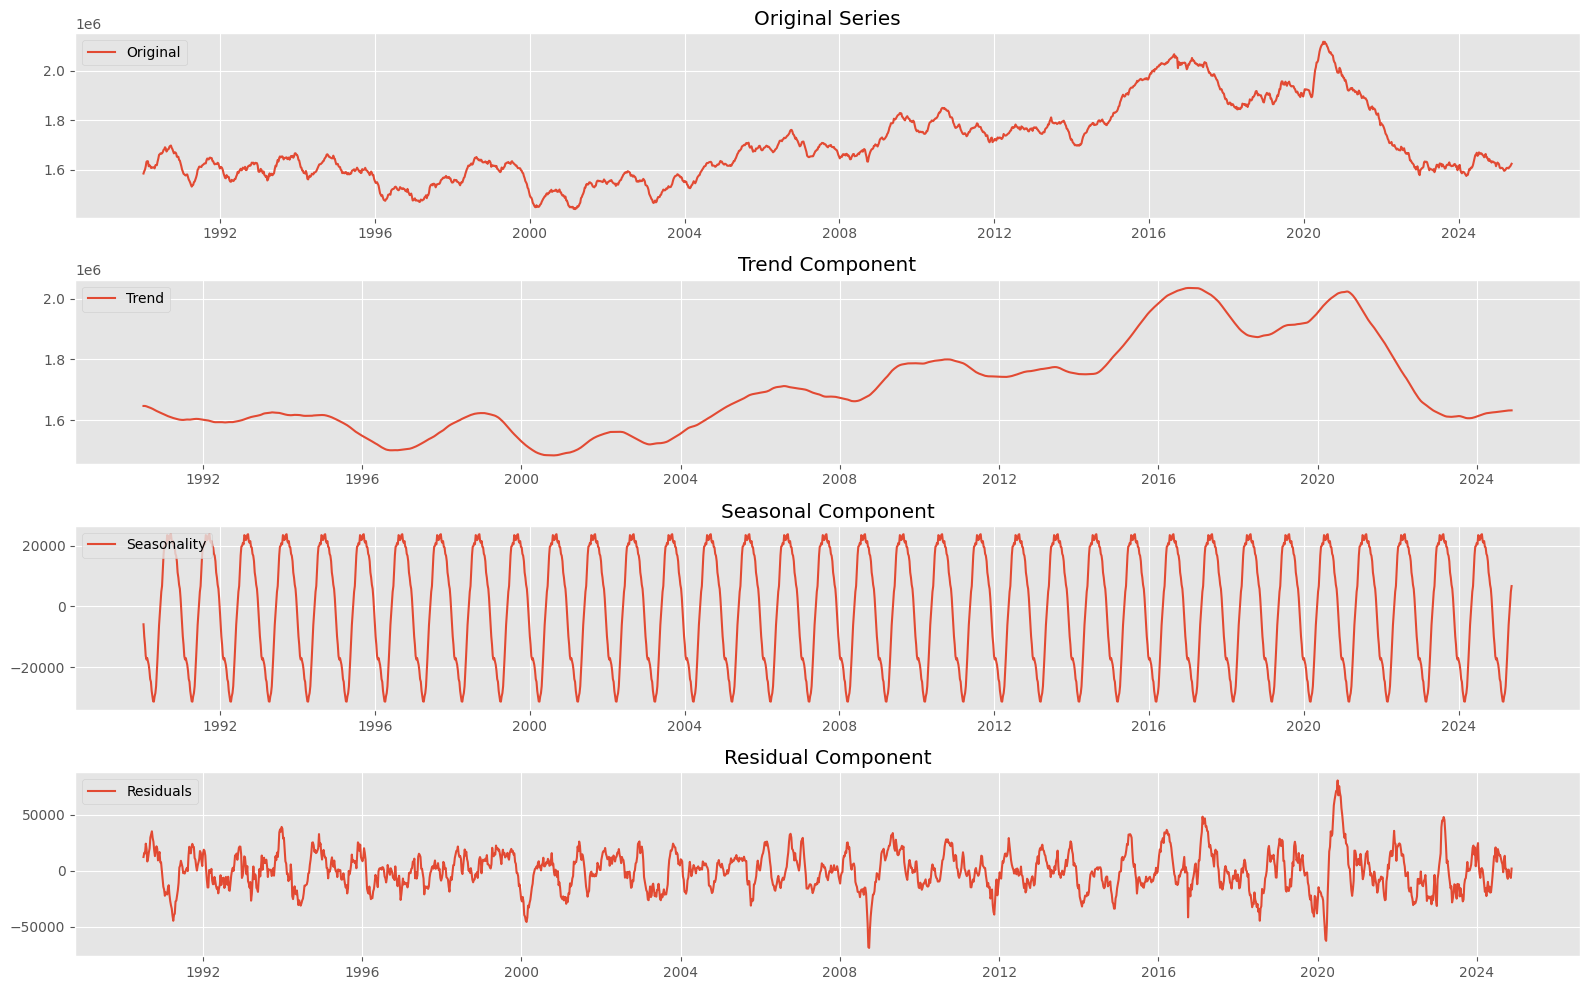

Time Series Decomposition plot saved to /content/visualizations/crude_oil_decomposition.png


In [14]:
# Example Decomposition for Crude Oil
print("\n--- Time Series Decomposition for Crude Oil ---")
crude_oil_df = product_dfs.get('Crude Oil')

if crude_oil_df is not None and not crude_oil_df.empty:
    # Resample to weekly frequency if not already (important for decomposition)
    # Using 'W-FRI' assuming week ends on Friday, adjust if needed based on EIA data.
    # The current 'Date' column is already weekly, so this might not change much.
    crude_oil_resampled = crude_oil_df['Value'].asfreq('W-FRI').fillna(method='ffill')

    # Check for enough periods for decomposition
    # 52 weeks in a year for seasonality + 2 for trend = 54 minimum
    if len(crude_oil_resampled) > 54:
        # Perform additive decomposition because values are large and likely absolute additions
        decomposition = seasonal_decompose(crude_oil_resampled, model='additive', period=52) # Assuming yearly seasonality (52 weeks)

        plt.figure(figsize=(16, 10))
        plt.subplot(411)
        plt.plot(crude_oil_resampled, label='Original')
        plt.legend(loc='upper left')
        plt.title('Original Series')

        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend(loc='upper left')
        plt.title('Trend Component')

        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonality')
        plt.legend(loc='upper left')
        plt.title('Seasonal Component')

        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residuals')
        plt.legend(loc='upper left')
        plt.title('Residual Component')

        plt.tight_layout()
        decomposition_plot_path = os.path.join(output_viz_dir, 'crude_oil_decomposition.png')
        plt.savefig(decomposition_plot_path)
        plt.show()
        print(f"Time Series Decomposition plot saved to {decomposition_plot_path}")
    else:
        print("Not enough data points for meaningful seasonal decomposition (need > 52 weeks).")
else:
    print("Crude Oil data not found or is empty for decomposition.")


--- Forecasting with SARIMA for Crude Oil ---
SARIMA Train data shape: (1476,)
SARIMA Test data shape: (370,)
                                      SARIMAX Results                                      
Dep. Variable:                               Value   No. Observations:                 1476
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood              -14050.798
Date:                             Thu, 22 May 2025   AIC                          28109.597
Time:                                     15:06:19   BIC                          28130.487
Sample:                                 01-05-1990   HQIC                         28117.415
                                      - 04-13-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

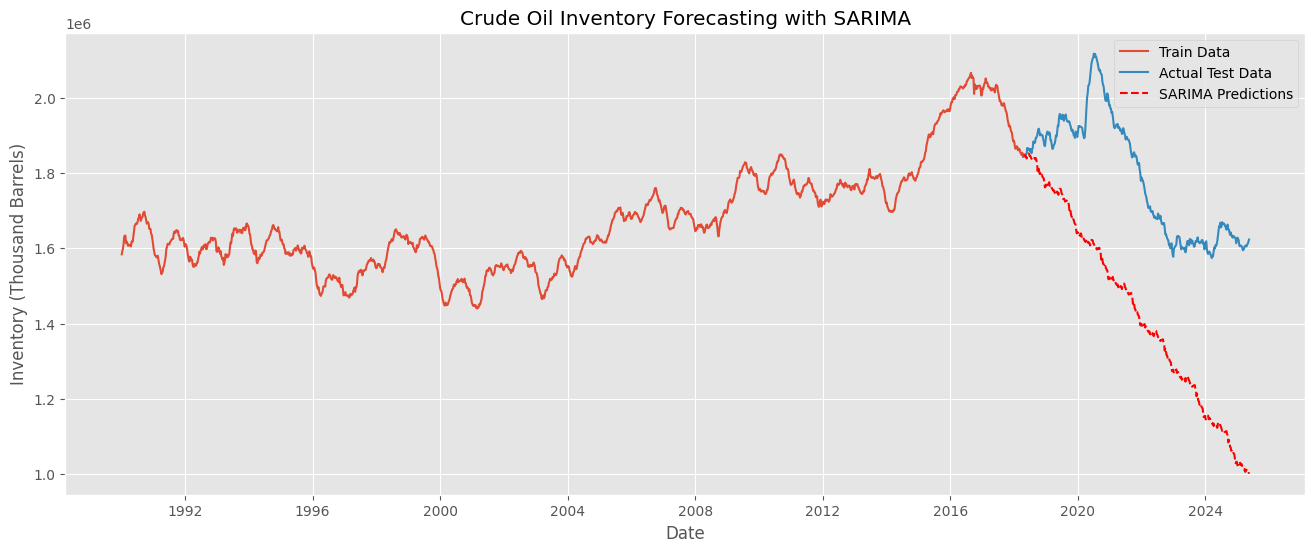

SARIMA forecast plot saved to /content/visualizations/crude_oil_sarima_forecast.png
An error occurred during SARIMA modeling: name 'np' is not defined
SARIMA model might not converge for these parameters or data. Consider tuning parameters.


In [15]:
print("\n--- Forecasting with SARIMA for Crude Oil ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    # Ensure data is sorted by date and has no gaps for SARIMA
    crude_oil_sarima_data = crude_oil_df['Value'].asfreq('W-FRI').ffill()

    # Split data into training and testing sets
    train_size = int(len(crude_oil_sarima_data) * 0.8)
    train_data = crude_oil_sarima_data[:train_size]
    test_data = crude_oil_sarima_data[train_size:]

    print(f"SARIMA Train data shape: {train_data.shape}")
    print(f"SARIMA Test data shape: {test_data.shape}")

    # Define SARIMA model parameters (p,d,q)(P,D,Q,s)
    # This is often (1,1,1)(1,1,0,52) for weekly data with yearly seasonality,
    # but needs tuning for optimal performance.
    order = (1, 1, 1)      # (p, d, q) for non-seasonal components
    seasonal_order = (1, 1, 0, 52) # (P, D, Q, s) for seasonal components (s=52 for weekly)

    try:
        sarima_model = SARIMAX(train_data,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
        sarima_results = sarima_model.fit(disp=False) # disp=False to suppress fit output
        print(sarima_results.summary())

        # Make predictions
        start_index = len(train_data)
        end_index = len(crude_oil_sarima_data) - 1
        sarima_predictions = sarima_results.predict(start=start_index, end=end_index, dynamic=False)

        # Plot SARIMA results
        plt.figure(figsize=(16, 6))
        plt.plot(train_data.index, train_data, label='Train Data')
        plt.plot(test_data.index, test_data, label='Actual Test Data')
        plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Predictions', color='red', linestyle='--')
        plt.title('Crude Oil Inventory Forecasting with SARIMA')
        plt.xlabel('Date')
        plt.ylabel('Inventory (Thousand Barrels)')
        plt.legend()
        plt.grid(True)
        sarima_plot_path = os.path.join(output_viz_dir, 'crude_oil_sarima_forecast.png')
        plt.savefig(sarima_plot_path)
        plt.show()
        print(f"SARIMA forecast plot saved to {sarima_plot_path}")

        # Evaluate SARIMA model
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_predictions))
        mae_sarima = mean_absolute_error(test_data, sarima_predictions)
        print(f"SARIMA RMSE: {rmse_sarima}")
        print(f"SARIMA MAE: {mae_sarima}")

    except Exception as e:
        print(f"An error occurred during SARIMA modeling: {e}")
        print("SARIMA model might not converge for these parameters or data. Consider tuning parameters.")

else:
    print("Crude Oil data not found or is empty for SARIMA forecasting.")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/192j2g95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/9gy5u4es.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39870', 'data', 'file=/tmp/tmpi48z_qcp/192j2g95.json', 'init=/tmp/tmpi48z_qcp/9gy5u4es.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelgh95t5l8/prophet_model-20250522150659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:06:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



--- Forecasting with Prophet for Crude Oil ---
Prophet Train data shape: (1476, 2)
Prophet Test data shape: (370, 2)


15:07:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


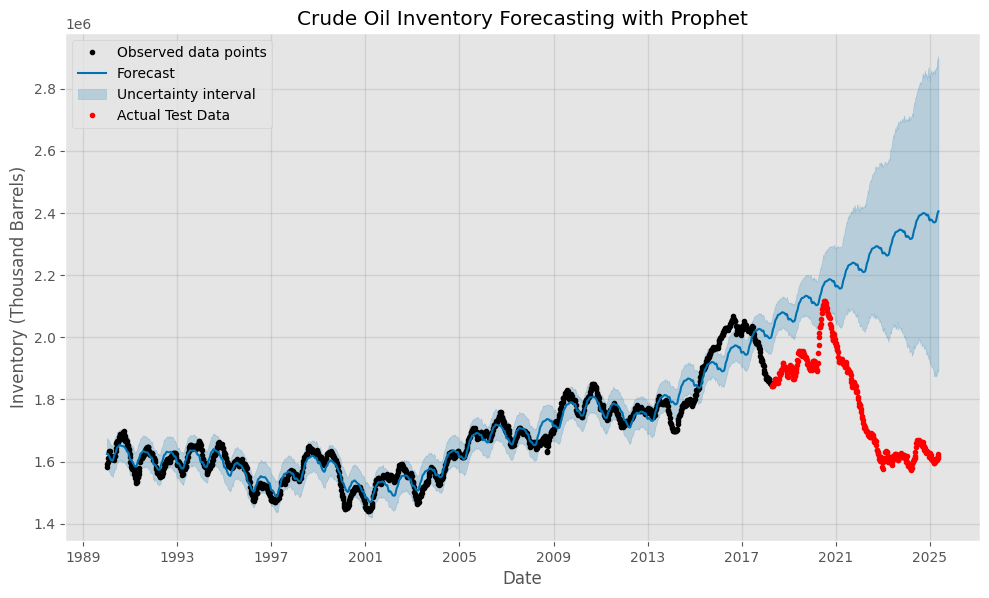

Prophet forecast plot saved to /content/visualizations/crude_oil_prophet_forecast.png


NameError: name 'np' is not defined

In [18]:
print("\n--- Forecasting with Prophet for Crude Oil ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    # Prophet requires columns to be named 'ds' (datestamp) and 'y' (value)
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    # Split data
    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    print(f"Prophet Train data shape: {train_prophet.shape}")
    print(f"Prophet Test data shape: {test_prophet.shape}")

    # Initialize and fit Prophet model
    m = Prophet(
        yearly_seasonality=True, # Explicitly enable yearly seasonality
        weekly_seasonality=False, # Weekly might not be strong or might cause issues with only 52 periods.
        daily_seasonality=False,
        changepoint_prior_scale=0.05 # Adjust this to control trend flexibility
    )
    m.fit(train_prophet)

    # Create a DataFrame with future dates for forecasting
    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI') # Forecast for the test period

    # Make predictions
    prophet_forecast = m.predict(future)

    # Align predictions with test data for evaluation
    prophet_predictions = prophet_forecast['yhat'].iloc[train_size_prophet:]
    prophet_predictions.index = test_prophet['ds'] # Align index for direct comparison

    # Plot Prophet results
    fig_prophet = m.plot(prophet_forecast)
    plt.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data') # Plot actual test data on top
    plt.title('Crude Oil Inventory Forecasting with Prophet')
    plt.xlabel('Date')
    plt.ylabel('Inventory (Thousand Barrels)')
    plt.legend()
    plt.grid(True)
    prophet_plot_path = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast.png')
    plt.savefig(prophet_plot_path)
    plt.show()
    print(f"Prophet forecast plot saved to {prophet_plot_path}")

    # Evaluate Prophet model
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    # Ensure both arrays have the same length before calculating metrics
    # This can be tricky with Prophet if `future` does not exactly match `test_prophet` indices.
    # We will slice prophet_forecast to match the test period directly.

    # Ensure correct alignment of test data and predictions
    # This might require re-indexing if Prophet's future dates don't exactly match the test data.
    # For simplicity, we'll slice the full forecast to match the test period.
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE: {rmse_prophet}")
    print(f"Prophet MAE: {mae_prophet}")

    # Plot components (trend, seasonality)
    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path = os.path.join(output_viz_dir, 'crude_oil_prophet_components.png')
    fig2_prophet.savefig(prophet_components_path)
    plt.show()
    print(f"Prophet components plot saved to {prophet_components_path}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")

Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls
Output cleaned data will be saved to: /content/cleaned_eia_inventory.csv
Visualizations will be saved to: /content/visualizations

--- Processing Distillate Data ---
Successfully loaded and cleaned /content/WDISTUS1w.xls for Distillate Fuel Oil.
Shape: (2225, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

--- Processing Gasoline Data ---
Successfully loaded and cleaned /content/WGTSTUS1w.xls for Motor Gasoline.
Shape: (1846, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

--- Processing Crude Oil Data ---
Successfully loaded and cleaned /content/WTTSTUS1w.xls for Crude Oil.
Shape: (1846, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

Combined and cleaned data saved to /content/cleaned_eia_inventory.csv

Cleaned data loaded successfully for forecasting.

--- Time Series Decomposition 

<ipython-input-19-87d3097cef7e>:144: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crude_oil_resampled = crude_oil_df['Value'].asfreq('W-FRI').fillna(method='ffill')


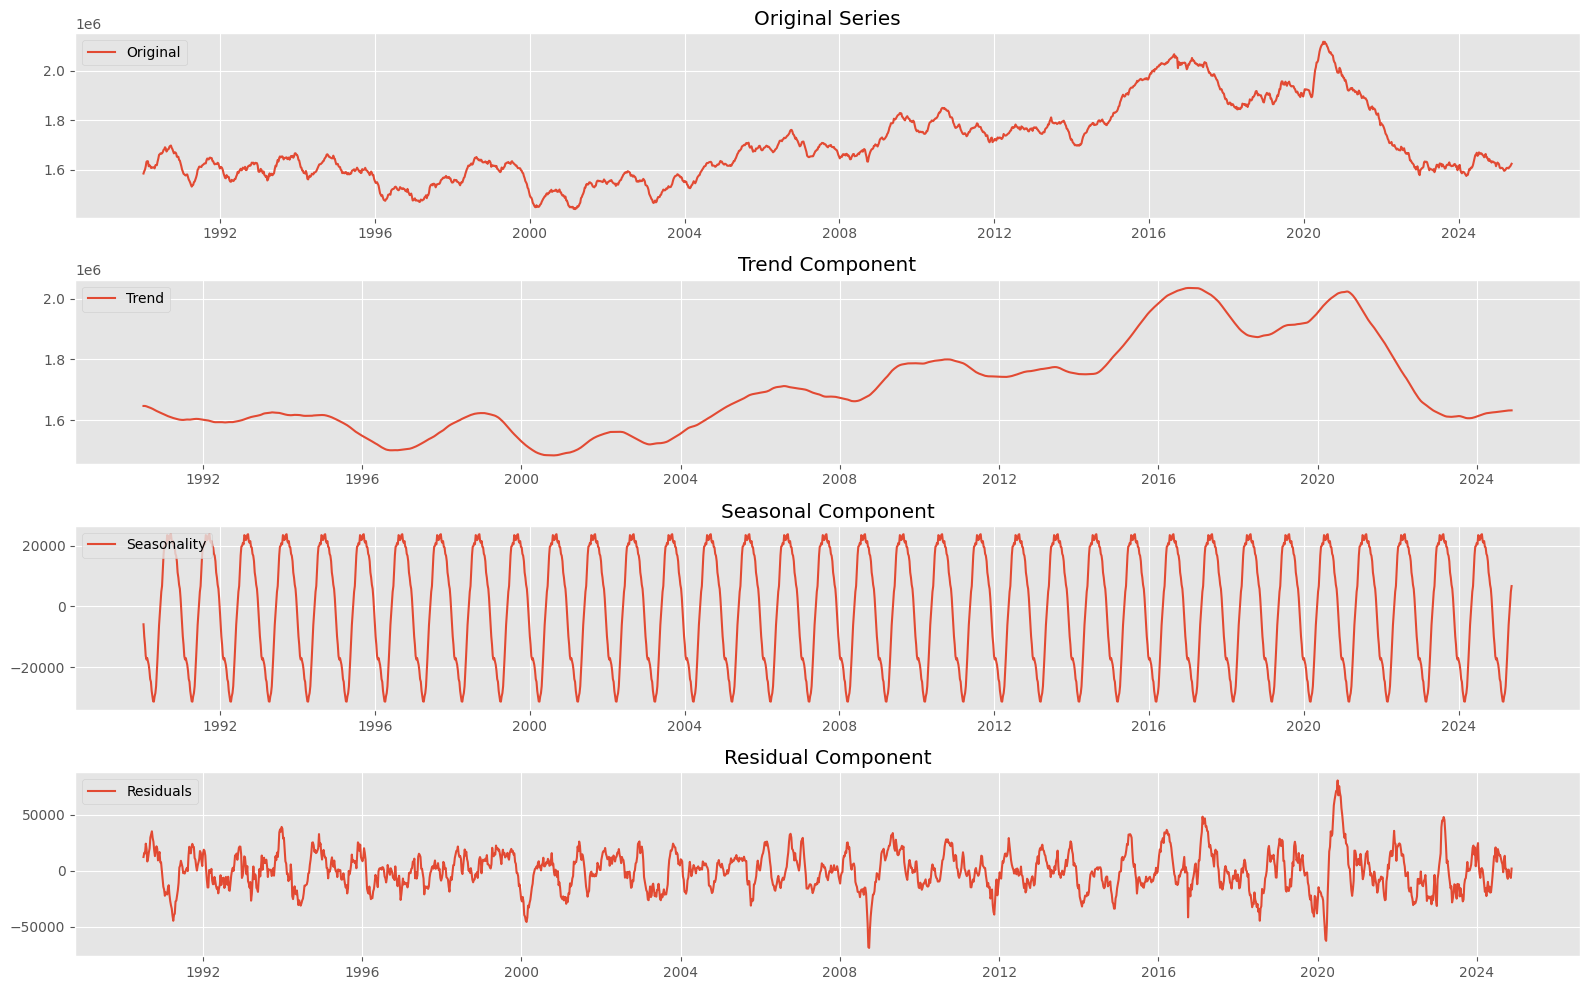

Time Series Decomposition plot saved to /content/visualizations/crude_oil_decomposition.png

--- Forecasting with SARIMA for Crude Oil ---
                                      SARIMAX Results                                      
Dep. Variable:                               Value   No. Observations:                 1476
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood              -14761.974
Date:                             Thu, 22 May 2025   AIC                          29531.947
Time:                                     15:07:54   BIC                          29552.990
Sample:                                 01-05-1990   HQIC                         29539.807
                                      - 04-13-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

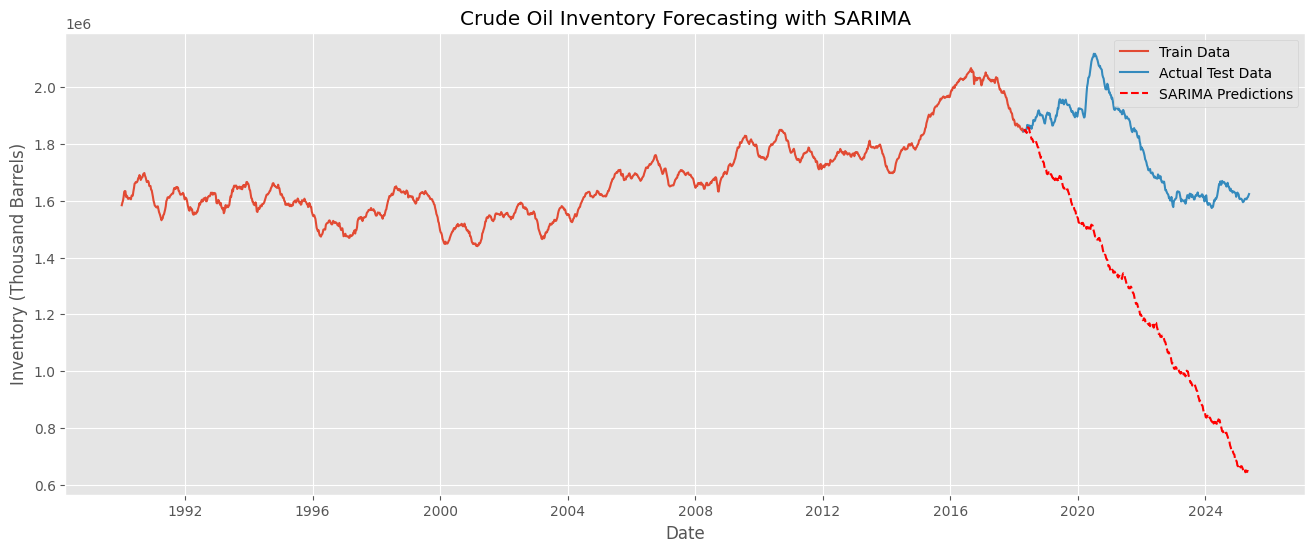

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/kku86wbo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/1o7xliol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53333', 'data', 'file=/tmp/tmpi48z_qcp/kku86wbo.json', 'init=/tmp/tmpi48z_qcp/1o7xliol.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelnliet8ap/prophet_model-20250522150755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:07:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


SARIMA forecast plot saved to /content/visualizations/crude_oil_sarima_forecast.png
SARIMA RMSE: 596771.0230381986
SARIMA MAE: 545298.2669690074

--- Forecasting with Prophet for Crude Oil ---


15:07:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


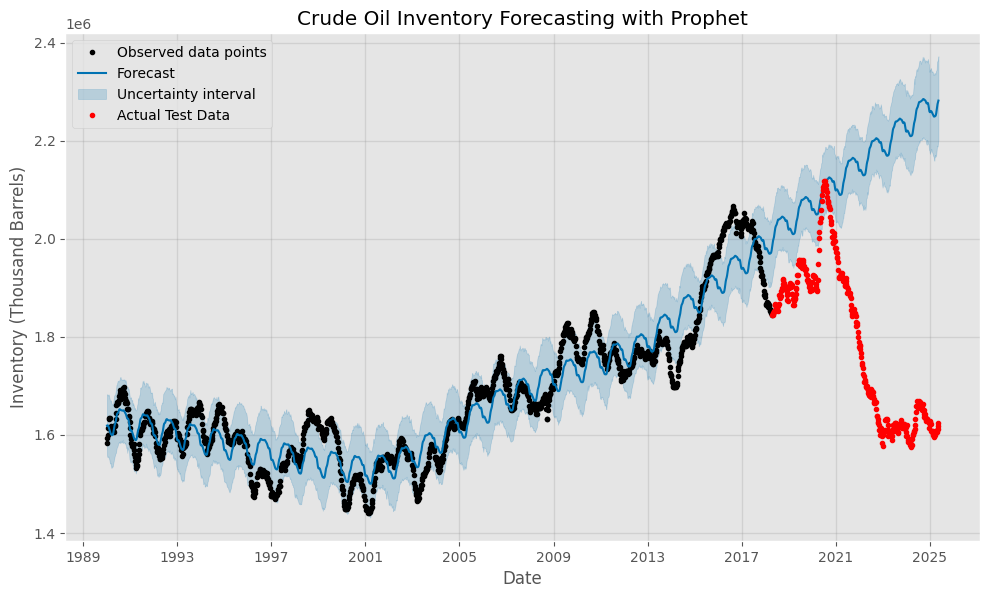

Prophet forecast plot saved to /content/visualizations/crude_oil_prophet_forecast.png
Prophet RMSE: 423689.84237839835
Prophet MAE: 357423.379800644


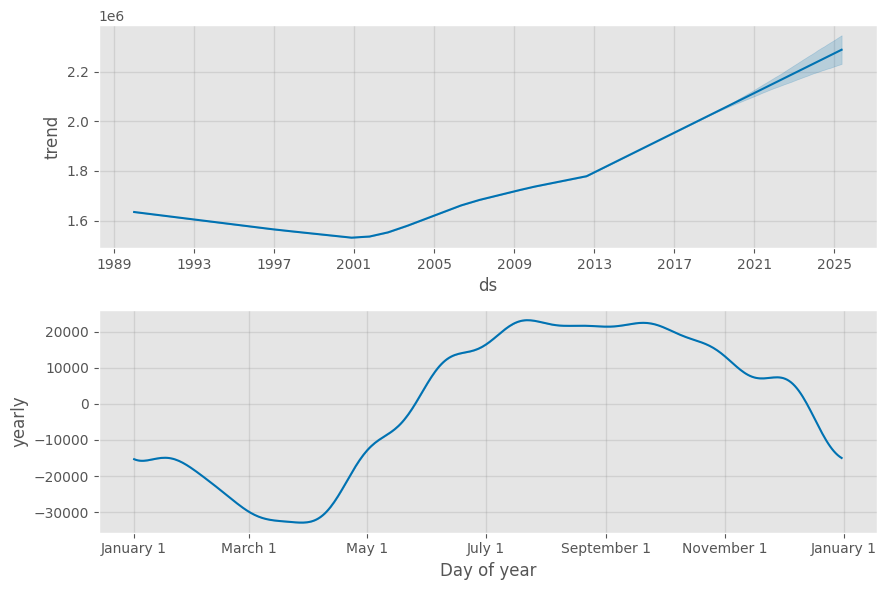

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/ugfe7zda.json


Prophet components plot saved to /content/visualizations/crude_oil_prophet_components.png

--- Generating and Exporting Future Forecasts (Example: Crude Oil) ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/ipw9xhyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20560', 'data', 'file=/tmp/tmpi48z_qcp/ugfe7zda.json', 'init=/tmp/tmpi48z_qcp/ipw9xhyv.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelw6oghnu7/prophet_model-20250522150758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:07:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:07:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Future forecasts for Crude Oil saved to /content/crude_oil_future_forecast.csv
           Date  Forecast_Value  Forecast_Lower_Bound  Forecast_Upper_Bound  \
1846 2025-05-23    1.592949e+06          1.514179e+06          1.671004e+06   
1847 2025-05-30    1.598477e+06          1.519610e+06          1.676866e+06   
1848 2025-06-06    1.603407e+06          1.524023e+06          1.681031e+06   
1849 2025-06-13    1.605694e+06          1.523337e+06          1.684222e+06   
1850 2025-06-20    1.605644e+06          1.525264e+06          1.678530e+06   

        Product  
1846  Crude Oil  
1847  Crude Oil  
1848  Crude Oil  
1849  Crude Oil  
1850  Crude Oil  
           Date  Forecast_Value  Forecast_Lower_Bound  Forecast_Upper_Bound  \
1867 2025-10-17    1.589289e+06          1.513145e+06          1.664857e+06   
1868 2025-10-24    1.586691e+06          1.511559e+06          1.663120e+06   
1869 2025-10-31    1.583024e+06          1.506068e+06          1.655985e+06   
1870 2025-11-07    1.5

In [19]:
# --- Colab Cell 1: Install Libraries & Setup Paths (Re-run if restarting kernel) ---
# Ensure these are installed
!pip install openpyxl matplotlib seaborn statsmodels pystan prophet
# You might need to restart your runtime after installing pystan, then run this cell again.

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import logging # For Prophet verbosity
import numpy as np # <--- FIX: Import numpy

# Suppress Prophet's verbose output
logging.getLogger('prophet').setLevel(logging.WARNING)

# Define the path to your cleaned CSV
data_dir = '/content/'
cleaned_data_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')
output_viz_dir = os.path.join(data_dir, 'visualizations')
os.makedirs(output_viz_dir, exist_ok=True) # Ensure directory exists

print(f"Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls")
print(f"Output cleaned data will be saved to: {cleaned_data_file}")
print(f"Visualizations will be saved to: {output_viz_dir}")


# --- Colab Cell 2: Data Preprocessing Logic (Run this first to ensure cleaned_eia_inventory.csv exists) ---
# This section contains the function to load and clean EIA data, and then applies it.

def load_and_clean_eia_data(filepath, product_name, header_row_index, sheet_name):
    """
    Loads EIA data from an Excel file, cleans it, and returns a DataFrame.
    'header_row_index' is the 0-indexed row number where the actual column headers are located.
    'sheet_name' is the name of the Excel sheet containing the data.
    """
    try:
        df_raw = pd.read_excel(filepath, sheet_name=sheet_name, header=header_row_index)

        original_cols = df_raw.columns.tolist()
        date_col = None
        for col in original_cols:
            if isinstance(col, str) and ('date' in col.lower() or 'week ended' in col.lower() or 'observation date' in col.lower()):
                date_col = col
                break
        if date_col is None and original_cols:
            date_col = original_cols[0]

        value_col = None
        if len(original_cols) > 1:
            value_col = original_cols[1]

        if date_col is None or value_col is None:
            print(f"Warning: Could not identify Date ('{date_col}') or Value ('{value_col}') columns in {filepath}. Available columns: {original_cols}")
            return pd.DataFrame()

        df = df_raw.rename(columns={date_col: 'Date', value_col: 'Value'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['Product'] = product_name
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        df.dropna(subset=['Date', 'Value'], how='all', inplace=True)
        df['Value'] = df['Value'].ffill()
        df.dropna(subset=['Date'], inplace=True)
        df = df[['Date', 'Product', 'Value']].sort_values(by='Date').reset_index(drop=True)

        print(f"Successfully loaded and cleaned {filepath} for {product_name}.")
        print(f"Shape: {df.shape}")
        print(f"Missing values after cleaning:\n{df.isnull().sum()}")
        # print(f"First 5 rows for {product_name}:\n{df.head()}") # Suppress for brevity
        # print(f"Last 5 rows for {product_name}:\n{df.tail()}") # Suppress for brevity

        return df

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}. Please ensure it's uploaded to Colab.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {filepath}: {e}")
        return pd.DataFrame()

# File paths (from previous steps)
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls')
file_gasoline = os.path.join(data_dir, 'WGTSTUS1w.xls')
file_crude = os.path.join(data_dir, 'WTTSTUS1w.xls')

SHEET_NAME = 'Data 1'
HEADER_ROW_INDEX = 2

print("\n--- Processing Distillate Data ---")
df_distillate = load_and_clean_eia_data(file_distillate, 'Distillate Fuel Oil', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Gasoline Data ---")
df_gasoline = load_and_clean_eia_data(file_gasoline, 'Motor Gasoline', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Crude Oil Data ---")
df_crude = load_and_clean_eia_data(file_crude, 'Crude Oil', HEADER_ROW_INDEX, SHEET_NAME)

all_dfs = [df for df in [df_distillate, df_gasoline, df_crude] if not df.empty]

if all_dfs:
    combined_df = pd.concat(all_dfs).sort_values(by=['Date', 'Product']).reset_index(drop=True)
    combined_df.drop_duplicates(subset=['Date', 'Product'], inplace=True)
    combined_df.to_csv(cleaned_data_file, index=False)
    print(f"\nCombined and cleaned data saved to {cleaned_data_file}")
    # print(f"Final combined DataFrame shape: {combined_df.shape}") # Suppress for brevity
    # print(f"Unique products in combined data: {combined_df['Product'].unique()}") # Suppress for brevity
else:
    print("\nNo data was successfully loaded and combined.")


# --- Colab Cell 3: Forecasting Logic (Revised) ---
# This section contains the time series forecasting code.

# Load the combined cleaned data
try:
    df = pd.read_csv(cleaned_data_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    print("\nCleaned data loaded successfully for forecasting.")
    # print(df.head()) # Suppress for brevity
    # print(df.info()) # Suppress for brevity

except FileNotFoundError:
    print(f"Error: Cleaned data file not found at {cleaned_data_file}. Please ensure Phase 2 ran successfully.")
    exit() # Exit if data not found

# Separate data for each product
products = df['Product'].unique()
product_dfs = {product: df[df['Product'] == product].drop(columns='Product') for product in products}

# print("\nData separated by product:") # Suppress for brevity
# for product, data_df in product_dfs.items():
#     print(f"{product} data shape: {data_df.shape}")
#     print(data_df.head())

# Example Decomposition for Crude Oil
print("\n--- Time Series Decomposition for Crude Oil ---")
crude_oil_df = product_dfs.get('Crude Oil')

if crude_oil_df is not None and not crude_oil_df.empty:
    crude_oil_resampled = crude_oil_df['Value'].asfreq('W-FRI').fillna(method='ffill')

    if len(crude_oil_resampled) > 54:
        decomposition = seasonal_decompose(crude_oil_resampled, model='additive', period=52)

        plt.figure(figsize=(16, 10))
        plt.subplot(411)
        plt.plot(crude_oil_resampled, label='Original')
        plt.legend(loc='upper left')
        plt.title('Original Series')

        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend(loc='upper left')
        plt.title('Trend Component')

        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonality')
        plt.legend(loc='upper left')
        plt.title('Seasonal Component')

        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residuals')
        plt.legend(loc='upper left')
        plt.title('Residual Component')

        plt.tight_layout()
        decomposition_plot_path = os.path.join(output_viz_dir, 'crude_oil_decomposition.png')
        plt.savefig(decomposition_plot_path)
        plt.show()
        print(f"Time Series Decomposition plot saved to {decomposition_plot_path}")
    else:
        print("Not enough data points for meaningful seasonal decomposition (need > 52 weeks).")
else:
    print("Crude Oil data not found or is empty for decomposition.")


print("\n--- Forecasting with SARIMA for Crude Oil ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    crude_oil_sarima_data = crude_oil_df['Value'].asfreq('W-FRI').ffill()

    train_size = int(len(crude_oil_sarima_data) * 0.8)
    train_data = crude_oil_sarima_data[:train_size]
    test_data = crude_oil_sarima_data[train_size:]

    # print(f"SARIMA Train data shape: {train_data.shape}") # Suppress for brevity
    # print(f"SARIMA Test data shape: {test_data.shape}") # Suppress for brevity

    order = (1, 1, 1)      # (p, d, q)
    seasonal_order = (1, 1, 0, 52) # (P, D, Q, s)

    try:
        sarima_model = SARIMAX(train_data,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=True, # Set to True
                               enforce_invertibility=True) # Set to True
        sarima_results = sarima_model.fit(disp=False)
        print(sarima_results.summary())

        start_index = len(train_data)
        end_index = len(crude_oil_sarima_data) - 1
        sarima_predictions = sarima_results.predict(start=start_index, end=end_index, dynamic=False)

        plt.figure(figsize=(16, 6))
        plt.plot(train_data.index, train_data, label='Train Data')
        plt.plot(test_data.index, test_data, label='Actual Test Data')
        plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Predictions', color='red', linestyle='--')
        plt.title('Crude Oil Inventory Forecasting with SARIMA')
        plt.xlabel('Date')
        plt.ylabel('Inventory (Thousand Barrels)')
        plt.legend()
        plt.grid(True)
        sarima_plot_path = os.path.join(output_viz_dir, 'crude_oil_sarima_forecast.png')
        plt.savefig(sarima_plot_path)
        plt.show()
        print(f"SARIMA forecast plot saved to {sarima_plot_path}")

        from sklearn.metrics import mean_squared_error, mean_absolute_error
        rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_predictions))
        mae_sarima = mean_absolute_error(test_data, sarima_predictions)
        print(f"SARIMA RMSE: {rmse_sarima}")
        print(f"SARIMA MAE: {mae_sarima}")

    except Exception as e:
        print(f"An error occurred during SARIMA modeling: {e}")
        print("SARIMA model might not converge for these parameters or data. Consider tuning parameters or trying Prophet.")

else:
    print("Crude Oil data not found or is empty for SARIMA forecasting.")


print("\n--- Forecasting with Prophet for Crude Oil ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    # print(f"Prophet Train data shape: {train_prophet.shape}") # Suppress for brevity
    # print(f"Prophet Test data shape: {test_prophet.shape}") # Suppress for brevity

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.01 # Slightly reduced to make trend more flexible to recent changes
    )
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI')
    prophet_forecast = m.predict(future)

    # Plot Prophet results using Prophet's built-in plotting
    fig_prophet = m.plot(prophet_forecast)
    ax = fig_prophet.gca()
    ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data') # Plot actual test data as red dots
    ax.set_title('Crude Oil Inventory Forecasting with Prophet')
    ax.set_xlabel('Date')
    ax.set_ylabel('Inventory (Thousand Barrels)')
    ax.legend()
    plt.grid(True)
    prophet_plot_path = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast.png')
    fig_prophet.savefig(prophet_plot_path)
    plt.show()
    print(f"Prophet forecast plot saved to {prophet_plot_path}")

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE: {rmse_prophet}")
    print(f"Prophet MAE: {mae_prophet}")

    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path = os.path.join(output_viz_dir, 'crude_oil_prophet_components.png')
    fig2_prophet.savefig(prophet_components_path)
    plt.show()
    print(f"Prophet components plot saved to {prophet_components_path}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")


print("\n--- Generating and Exporting Future Forecasts (Example: Crude Oil) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df_full = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})
    m_full = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.01) # Use adjusted changepoint_prior_scale
    m_full.fit(prophet_df_full)

    future_periods = 26 # Next 6 months (26 weeks)
    future = m_full.make_future_dataframe(periods=future_periods, freq='W-FRI')

    forecast_full = m_full.predict(future)

    last_actual_date = prophet_df_full['ds'].max()
    future_forecast = forecast_full[forecast_full['ds'] > last_actual_date]

    future_forecast_export = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    future_forecast_export.rename(columns={'ds': 'Date', 'yhat': 'Forecast_Value',
                                           'yhat_lower': 'Forecast_Lower_Bound',
                                           'yhat_upper': 'Forecast_Upper_Bound'}, inplace=True)
    future_forecast_export['Product'] = 'Crude Oil'

    forecast_output_path = os.path.join(data_dir, 'crude_oil_future_forecast.csv')
    future_forecast_export.to_csv(forecast_output_path, index=False)

    print(f"Future forecasts for Crude Oil saved to {forecast_output_path}")
    print(future_forecast_export.head())
    print(future_forecast_export.tail())
else:
    print("Crude Oil data not available for future forecasting.")

print("\n--- Forecasting Phase Complete (for example product) ---")
print("You would repeat similar steps for 'Distillate Fuel Oil' and 'Motor Gasoline'.")
print("For SARIMA, consider using 'pmdarima.auto_arima' for automated parameter selection.")

In [20]:
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/sjztdwha.json



--- Re-Forecasting with Prophet for Crude Oil (Tuned changepoint_prior_scale) ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/kwn3hl61.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82594', 'data', 'file=/tmp/tmpi48z_qcp/sjztdwha.json', 'init=/tmp/tmpi48z_qcp/kwn3hl61.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelp7e1a25p/prophet_model-20250522150835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:08:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:08:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


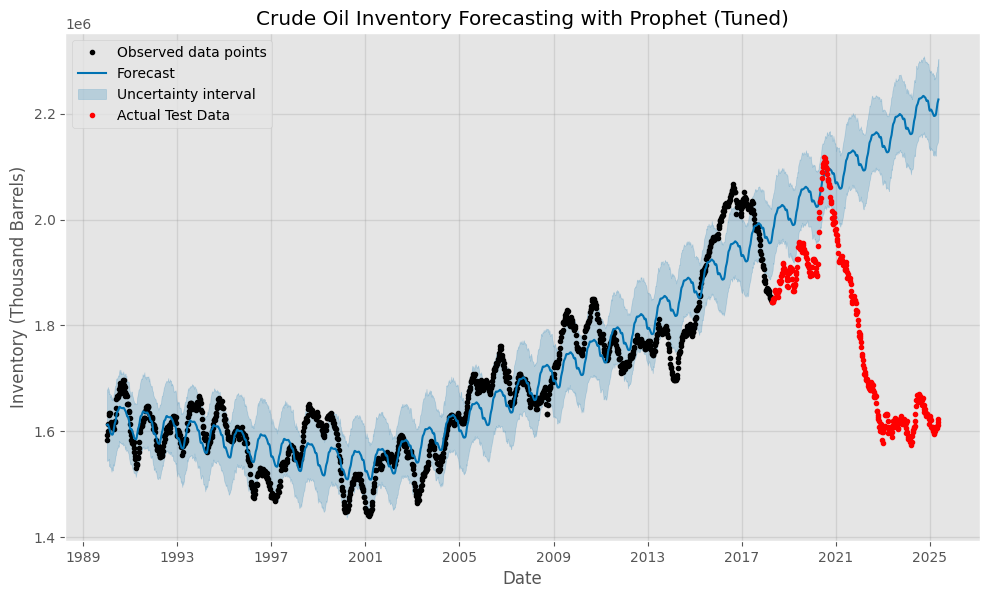

Prophet tuned forecast plot saved to /content/visualizations/crude_oil_prophet_forecast_tuned.png
Prophet RMSE (Tuned): 388966.2650621041
Prophet MAE (Tuned): 323990.0267192731


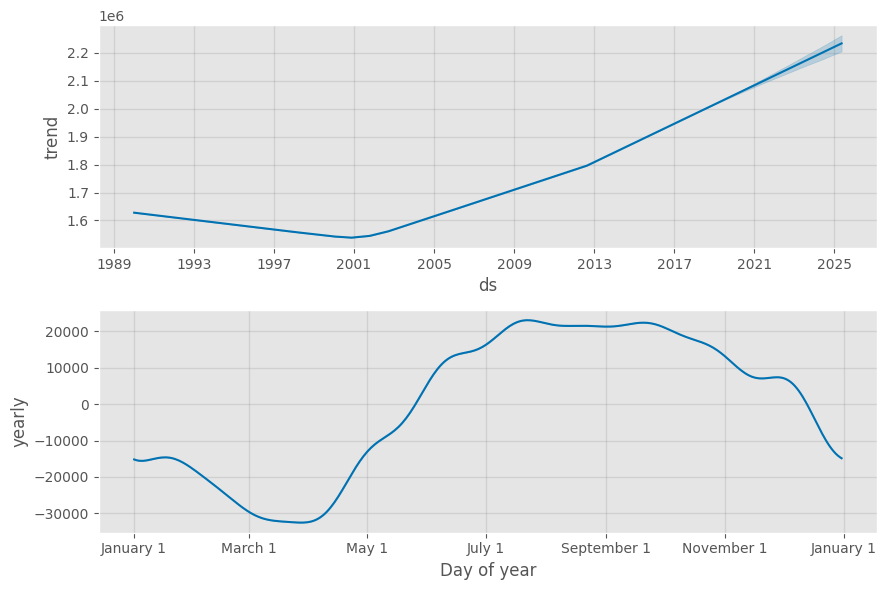

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/shlic66f.json


Prophet tuned components plot saved to /content/visualizations/crude_oil_prophet_components_tuned.png

--- Generating and Exporting Future Forecasts (Example: Crude Oil - Tuned Prophet) ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/dc9r790z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16630', 'data', 'file=/tmp/tmpi48z_qcp/shlic66f.json', 'init=/tmp/tmpi48z_qcp/dc9r790z.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelu6lz8f7j/prophet_model-20250522150841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:08:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:08:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Future forecasts for Crude Oil saved to /content/crude_oil_future_forecast_tuned.csv
           Date  Forecast_Value  Forecast_Lower_Bound  Forecast_Upper_Bound  \
1846 2025-05-23    1.621593e+06          1.539773e+06          1.705385e+06   
1847 2025-05-30    1.627516e+06          1.545644e+06          1.706826e+06   
1848 2025-06-06    1.632668e+06          1.550754e+06          1.713585e+06   
1849 2025-06-13    1.635045e+06          1.556031e+06          1.715165e+06   
1850 2025-06-20    1.635074e+06          1.552277e+06          1.715923e+06   

        Product  
1846  Crude Oil  
1847  Crude Oil  
1848  Crude Oil  
1849  Crude Oil  
1850  Crude Oil  
           Date  Forecast_Value  Forecast_Lower_Bound  Forecast_Upper_Bound  \
1867 2025-10-17    1.621213e+06          1.535147e+06          1.706985e+06   
1868 2025-10-24    1.618779e+06          1.534502e+06          1.702591e+06   
1869 2025-10-31    1.615247e+06          1.536262e+06          1.691797e+06   
1870 2025-11-07 

In [21]:
# --- Revised Prophet Forecasting for Crude Oil ---
print("\n--- Re-Forecasting with Prophet for Crude Oil (Tuned changepoint_prior_scale) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.005 # <--- Further reduced
    )
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI')
    prophet_forecast = m.predict(future)

    fig_prophet = m.plot(prophet_forecast)
    ax = fig_prophet.gca()
    ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data')
    ax.set_title('Crude Oil Inventory Forecasting with Prophet (Tuned)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Inventory (Thousand Barrels)')
    ax.legend()
    plt.grid(True)
    prophet_plot_path_tuned = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast_tuned.png')
    fig_prophet.savefig(prophet_plot_path_tuned)
    plt.show()
    print(f"Prophet tuned forecast plot saved to {prophet_plot_path_tuned}")

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE (Tuned): {rmse_prophet}")
    print(f"Prophet MAE (Tuned): {mae_prophet}")

    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path_tuned = os.path.join(output_viz_dir, 'crude_oil_prophet_components_tuned.png')
    fig2_prophet.savefig(prophet_components_path_tuned)
    plt.show()
    print(f"Prophet tuned components plot saved to {prophet_components_path_tuned}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")

# --- Re-generate and Export Future Forecasts with Tuned Prophet ---
print("\n--- Generating and Exporting Future Forecasts (Example: Crude Oil - Tuned Prophet) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df_full = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})
    m_full_tuned = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.005) # Use tuned scale
    m_full_tuned.fit(prophet_df_full)

    future_periods = 26 # Next 6 months (26 weeks)
    future = m_full_tuned.make_future_dataframe(periods=future_periods, freq='W-FRI')

    forecast_full = m_full_tuned.predict(future)

    last_actual_date = prophet_df_full['ds'].max()
    future_forecast = forecast_full[forecast_full['ds'] > last_actual_date]

    future_forecast_export = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    future_forecast_export.rename(columns={'ds': 'Date', 'yhat': 'Forecast_Value',
                                           'yhat_lower': 'Forecast_Lower_Bound',
                                           'yhat_upper': 'Forecast_Upper_Bound'}, inplace=True)
    future_forecast_export['Product'] = 'Crude Oil'

    forecast_output_path_tuned = os.path.join(data_dir, 'crude_oil_future_forecast_tuned.csv')
    future_forecast_export.to_csv(forecast_output_path_tuned, index=False)

    print(f"Future forecasts for Crude Oil saved to {forecast_output_path_tuned}")
    print(future_forecast_export.head())
    print(future_forecast_export.tail())
else:
    print("Crude Oil data not available for future forecasting.")

print("\n--- Prophet Tuning Attempt Complete ---")
print("Check the new 'crude_oil_prophet_forecast_tuned.png' and 'crude_oil_prophet_components_tuned.png' plots.")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/kwu906fg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/01d5oj6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42284', 'data', 'file=/tmp/tmpi48z_qcp/kwu906fg.json', 'init=/tmp/tmpi48z_qcp/01d5oj6q.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modeli09o1f99/prophet_model-20250522150849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



--- Re-Forecasting with Prophet for Crude Oil (Increased changepoint_prior_scale) ---


15:08:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


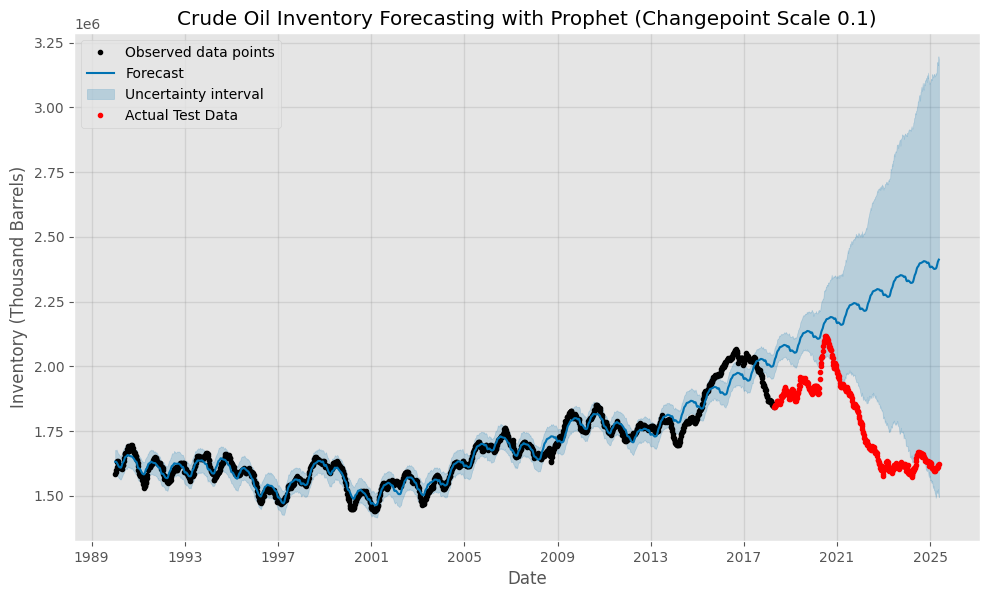

Prophet tuned forecast plot saved to /content/visualizations/crude_oil_prophet_forecast_tuned_higher.png
Prophet RMSE (Changepoint Scale 0.1): 506205.7470889349
Prophet MAE (Changepoint Scale 0.1): 437885.904202103


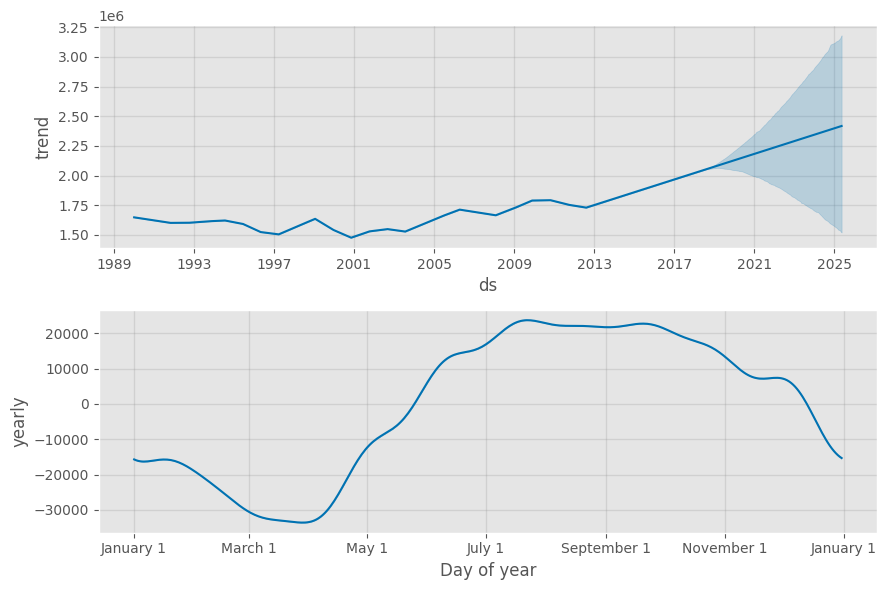

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/xqa3pmcu.json


Prophet tuned components plot saved to /content/visualizations/crude_oil_prophet_components_tuned_higher.png

--- Generating and Exporting Future Forecasts (Example: Crude Oil - Tuned Prophet 0.1) ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/hwgtgloa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73611', 'data', 'file=/tmp/tmpi48z_qcp/xqa3pmcu.json', 'init=/tmp/tmpi48z_qcp/hwgtgloa.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelcc75jldn/prophet_model-20250522150857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:08:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:08:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Future forecasts for Crude Oil saved to /content/crude_oil_future_forecast_tuned_higher.csv
           Date  Forecast_Value  Forecast_Lower_Bound  Forecast_Upper_Bound  \
1846 2025-05-23    1.580286e+06          1.516721e+06          1.642132e+06   
1847 2025-05-30    1.585662e+06          1.522264e+06          1.645116e+06   
1848 2025-06-06    1.590517e+06          1.530389e+06          1.651901e+06   
1849 2025-06-13    1.592794e+06          1.532262e+06          1.656429e+06   
1850 2025-06-20    1.592747e+06          1.533214e+06          1.651440e+06   

        Product  
1846  Crude Oil  
1847  Crude Oil  
1848  Crude Oil  
1849  Crude Oil  
1850  Crude Oil  
           Date  Forecast_Value  Forecast_Lower_Bound  Forecast_Upper_Bound  \
1867 2025-10-17    1.575933e+06          1.513698e+06          1.639394e+06   
1868 2025-10-24    1.573230e+06          1.511511e+06          1.637257e+06   
1869 2025-10-31    1.569468e+06          1.507601e+06          1.629260e+06   
1870 2025

In [22]:
# --- Revised Prophet Forecasting for Crude Oil (Increasing changepoint_prior_scale) ---
print("\n--- Re-Forecasting with Prophet for Crude Oil (Increased changepoint_prior_scale) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.1 # <--- Increased
    )
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI')
    prophet_forecast = m.predict(future)

    fig_prophet = m.plot(prophet_forecast)
    ax = fig_prophet.gca()
    ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data')
    ax.set_title('Crude Oil Inventory Forecasting with Prophet (Changepoint Scale 0.1)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Inventory (Thousand Barrels)')
    ax.legend()
    plt.grid(True)
    prophet_plot_path_tuned_higher = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast_tuned_higher.png')
    fig_prophet.savefig(prophet_plot_path_tuned_higher)
    plt.show()
    print(f"Prophet tuned forecast plot saved to {prophet_plot_path_tuned_higher}")

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE (Changepoint Scale 0.1): {rmse_prophet}")
    print(f"Prophet MAE (Changepoint Scale 0.1): {mae_prophet}")

    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path_tuned_higher = os.path.join(output_viz_dir, 'crude_oil_prophet_components_tuned_higher.png')
    fig2_prophet.savefig(prophet_components_path_tuned_higher)
    plt.show()
    print(f"Prophet tuned components plot saved to {prophet_components_path_tuned_higher}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")

# --- Re-generate and Export Future Forecasts with Tuned Prophet ---
print("\n--- Generating and Exporting Future Forecasts (Example: Crude Oil - Tuned Prophet 0.1) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df_full = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})
    m_full_tuned_higher = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.1) # Use tuned scale
    m_full_tuned_higher.fit(prophet_df_full)

    future_periods = 26 # Next 6 months (26 weeks)
    future = m_full_tuned_higher.make_future_dataframe(periods=future_periods, freq='W-FRI')

    forecast_full = m_full_tuned_higher.predict(future)

    last_actual_date = prophet_df_full['ds'].max()
    future_forecast = forecast_full[forecast_full['ds'] > last_actual_date]

    future_forecast_export = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    future_forecast_export.rename(columns={'ds': 'Date', 'yhat': 'Forecast_Value',
                                           'yhat_lower': 'Forecast_Lower_Bound',
                                           'yhat_upper': 'Forecast_Upper_Bound'}, inplace=True)
    future_forecast_export['Product'] = 'Crude Oil'

    forecast_output_path_tuned_higher = os.path.join(data_dir, 'crude_oil_future_forecast_tuned_higher.csv')
    future_forecast_export.to_csv(forecast_output_path_tuned_higher, index=False)

    print(f"Future forecasts for Crude Oil saved to {forecast_output_path_tuned_higher}")
    print(future_forecast_export.head())
    print(future_forecast_export.tail())
else:
    print("Crude Oil data not available for future forecasting.")

print("\n--- Prophet Tuning Attempt (Higher Changepoint Scale) Complete ---")
print("Check the new 'crude_oil_prophet_forecast_tuned_higher.png' and 'crude_oil_prophet_components_tuned_higher.png' plots.")

In [23]:
# --- Colab Cell 1: Install Libraries & Setup Paths ---
# Ensure these are installed
!pip install openpyxl matplotlib seaborn statsmodels pystan prophet
# You might need to restart your runtime after installing pystan, then run this cell again.

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import logging # For Prophet verbosity
import numpy as np # Import numpy for numerical operations

# Suppress Prophet's verbose output
logging.getLogger('prophet').setLevel(logging.WARNING)

# Define the path to your cleaned CSV
data_dir = '/content/'
cleaned_data_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')
output_viz_dir = os.path.join(data_dir, 'visualizations')
os.makedirs(output_viz_dir, exist_ok=True) # Ensure directory exists

print(f"Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls")
print(f"Output cleaned data will be saved to: {cleaned_data_file}")
print(f"Visualizations will be saved to: {output_viz_dir}")

Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls
Output cleaned data will be saved to: /content/cleaned_eia_inventory.csv
Visualizations will be saved to: /content/visualizations


In [24]:
# --- Colab Cell 2: Data Preprocessing Logic ---
# This section contains the function to load and clean EIA data, and then applies it.

def load_and_clean_eia_data(filepath, product_name, header_row_index, sheet_name):
    """
    Loads EIA data from an Excel file, cleans it, and returns a DataFrame.
    'header_row_index' is the 0-indexed row number where the actual column headers are located.
    'sheet_name' is the name of the Excel sheet containing the data.
    """
    try:
        df_raw = pd.read_excel(filepath, sheet_name=sheet_name, header=header_row_index)

        original_cols = df_raw.columns.tolist()
        date_col = None
        for col in original_cols:
            if isinstance(col, str) and ('date' in col.lower() or 'week ended' in col.lower() or 'observation date' in col.lower()):
                date_col = col
                break
        if date_col is None and original_cols:
            date_col = original_cols[0]

        value_col = None
        if len(original_cols) > 1:
            value_col = original_cols[1]

        if date_col is None or value_col is None:
            print(f"Warning: Could not identify Date ('{date_col}') or Value ('{value_col}') columns in {filepath}. Available columns: {original_cols}")
            return pd.DataFrame()

        df = df_raw.rename(columns={date_col: 'Date', value_col: 'Value'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['Product'] = product_name
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        df.dropna(subset=['Date', 'Value'], how='all', inplace=True)
        df['Value'] = df['Value'].ffill()
        df.dropna(subset=['Date'], inplace=True)
        df = df[['Date', 'Product', 'Value']].sort_values(by='Date').reset_index(drop=True)

        print(f"Successfully loaded and cleaned {filepath} for {product_name}.")
        print(f"Shape: {df.shape}")
        print(f"Missing values after cleaning:\n{df.isnull().sum()}")
        # print(f"First 5 rows for {product_name}:\n{df.head()}") # Suppress for brevity
        # print(f"Last 5 rows for {product_name}:\n{df.tail()}") # Suppress for brevity

        return df

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}. Please ensure it's uploaded to Colab.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {filepath}: {e}")
        return pd.DataFrame()

# File paths (from previous steps)
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls')
file_gasoline = os.path.join(data_dir, 'WGTSTUS1w.xls')
file_crude = os.path.join(data_dir, 'WTTSTUS1w.xls')

SHEET_NAME = 'Data 1'
HEADER_ROW_INDEX = 2

print("\n--- Processing Distillate Data ---")
df_distillate = load_and_clean_eia_data(file_distillate, 'Distillate Fuel Oil', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Gasoline Data ---")
df_gasoline = load_and_clean_eia_data(file_gasoline, 'Motor Gasoline', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Crude Oil Data ---")
df_crude = load_and_clean_eia_data(file_crude, 'Crude Oil', HEADER_ROW_INDEX, SHEET_NAME)

all_dfs = [df for df in [df_distillate, df_gasoline, df_crude] if not df.empty]

if all_dfs:
    combined_df = pd.concat(all_dfs).sort_values(by=['Date', 'Product']).reset_index(drop=True)
    combined_df.drop_duplicates(subset=['Date', 'Product'], inplace=True)
    combined_df.to_csv(cleaned_data_file, index=False)
    print(f"\nCombined and cleaned data saved to {cleaned_data_file}")
    # print(f"Final combined DataFrame shape: {combined_df.shape}") # Suppress for brevity
    # print(f"Unique products in combined data: {combined_df['Product'].unique()}") # Suppress for brevity
else:
    print("\nNo data was successfully loaded and combined.")


--- Processing Distillate Data ---
Successfully loaded and cleaned /content/WDISTUS1w.xls for Distillate Fuel Oil.
Shape: (2225, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

--- Processing Gasoline Data ---
Successfully loaded and cleaned /content/WGTSTUS1w.xls for Motor Gasoline.
Shape: (1846, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

--- Processing Crude Oil Data ---
Successfully loaded and cleaned /content/WTTSTUS1w.xls for Crude Oil.
Shape: (1846, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

Combined and cleaned data saved to /content/cleaned_eia_inventory.csv


In [25]:
# --- Colab Cell 1: Install Libraries & Setup Paths ---
# Ensure these are installed
!pip install openpyxl matplotlib seaborn statsmodels pystan prophet
# You might need to restart your runtime after installing pystan, then run this cell again.

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import logging # For Prophet verbosity
import numpy as np # Import numpy for numerical operations

# Suppress Prophet's verbose output
logging.getLogger('prophet').setLevel(logging.WARNING)

# Define the path to your cleaned CSV
data_dir = '/content/'
cleaned_data_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')
output_viz_dir = os.path.join(data_dir, 'visualizations')
os.makedirs(output_viz_dir, exist_ok=True) # Ensure directory exists

print(f"Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls")
print(f"Output cleaned data will be saved to: {cleaned_data_file}")
print(f"Visualizations will be saved to: {output_viz_dir}")

Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls
Output cleaned data will be saved to: /content/cleaned_eia_inventory.csv
Visualizations will be saved to: /content/visualizations


In [26]:
# --- Colab Cell 2: Data Preprocessing Logic ---
# This section contains the function to load and clean EIA data, and then applies it.

def load_and_clean_eia_data(filepath, product_name, header_row_index, sheet_name):
    """
    Loads EIA data from an Excel file, cleans it, and returns a DataFrame.
    'header_row_index' is the 0-indexed row number where the actual column headers are located.
    'sheet_name' is the name of the Excel sheet containing the data.
    """
    try:
        df_raw = pd.read_excel(filepath, sheet_name=sheet_name, header=header_row_index)

        original_cols = df_raw.columns.tolist()
        date_col = None
        for col in original_cols:
            if isinstance(col, str) and ('date' in col.lower() or 'week ended' in col.lower() or 'observation date' in col.lower()):
                date_col = col
                break
        if date_col is None and original_cols:
            date_col = original_cols[0]

        value_col = None
        if len(original_cols) > 1:
            value_col = original_cols[1]

        if date_col is None or value_col is None:
            print(f"Warning: Could not identify Date ('{date_col}') or Value ('{value_col}') columns in {filepath}. Available columns: {original_cols}")
            return pd.DataFrame()

        df = df_raw.rename(columns={date_col: 'Date', value_col: 'Value'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['Product'] = product_name
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        df.dropna(subset=['Date', 'Value'], how='all', inplace=True)
        df['Value'] = df['Value'].ffill()
        df.dropna(subset=['Date'], inplace=True)
        df = df[['Date', 'Product', 'Value']].sort_values(by='Date').reset_index(drop=True)

        print(f"Successfully loaded and cleaned {filepath} for {product_name}.")
        print(f"Shape: {df.shape}")
        print(f"Missing values after cleaning:\n{df.isnull().sum()}")
        # print(f"First 5 rows for {product_name}:\n{df.head()}") # Suppress for brevity
        # print(f"Last 5 rows for {product_name}:\n{df.tail()}") # Suppress for brevity

        return df

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}. Please ensure it's uploaded to Colab.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {filepath}: {e}")
        return pd.DataFrame()

# File paths (from previous steps)
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls')
file_gasoline = os.path.join(data_dir, 'WGTSTUS1w.xls')
file_crude = os.path.join(data_dir, 'WTTSTUS1w.xls')

SHEET_NAME = 'Data 1'
HEADER_ROW_INDEX = 2

print("\n--- Processing Distillate Data ---")
df_distillate = load_and_clean_eia_data(file_distillate, 'Distillate Fuel Oil', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Gasoline Data ---")
df_gasoline = load_and_clean_eia_data(file_gasoline, 'Motor Gasoline', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Crude Oil Data ---")
df_crude = load_and_clean_eia_data(file_crude, 'Crude Oil', HEADER_ROW_INDEX, SHEET_NAME)

all_dfs = [df for df in [df_distillate, df_gasoline, df_crude] if not df.empty]

if all_dfs:
    combined_df = pd.concat(all_dfs).sort_values(by=['Date', 'Product']).reset_index(drop=True)
    combined_df.drop_duplicates(subset=['Date', 'Product'], inplace=True)
    combined_df.to_csv(cleaned_data_file, index=False)
    print(f"\nCombined and cleaned data saved to {cleaned_data_file}")
    # print(f"Final combined DataFrame shape: {combined_df.shape}") # Suppress for brevity
    # print(f"Unique products in combined data: {combined_df['Product'].unique()}") # Suppress for brevity
else:
    print("\nNo data was successfully loaded and combined.")


--- Processing Distillate Data ---
Successfully loaded and cleaned /content/WDISTUS1w.xls for Distillate Fuel Oil.
Shape: (2225, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

--- Processing Gasoline Data ---
Successfully loaded and cleaned /content/WGTSTUS1w.xls for Motor Gasoline.
Shape: (1846, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

--- Processing Crude Oil Data ---
Successfully loaded and cleaned /content/WTTSTUS1w.xls for Crude Oil.
Shape: (1846, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

Combined and cleaned data saved to /content/cleaned_eia_inventory.csv



Cleaned data loaded successfully for forecasting.

--- Time Series Decomposition for Crude Oil ---


<ipython-input-27-119f995105f4>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crude_oil_resampled = crude_oil_df['Value'].asfreq('W-FRI').fillna(method='ffill')


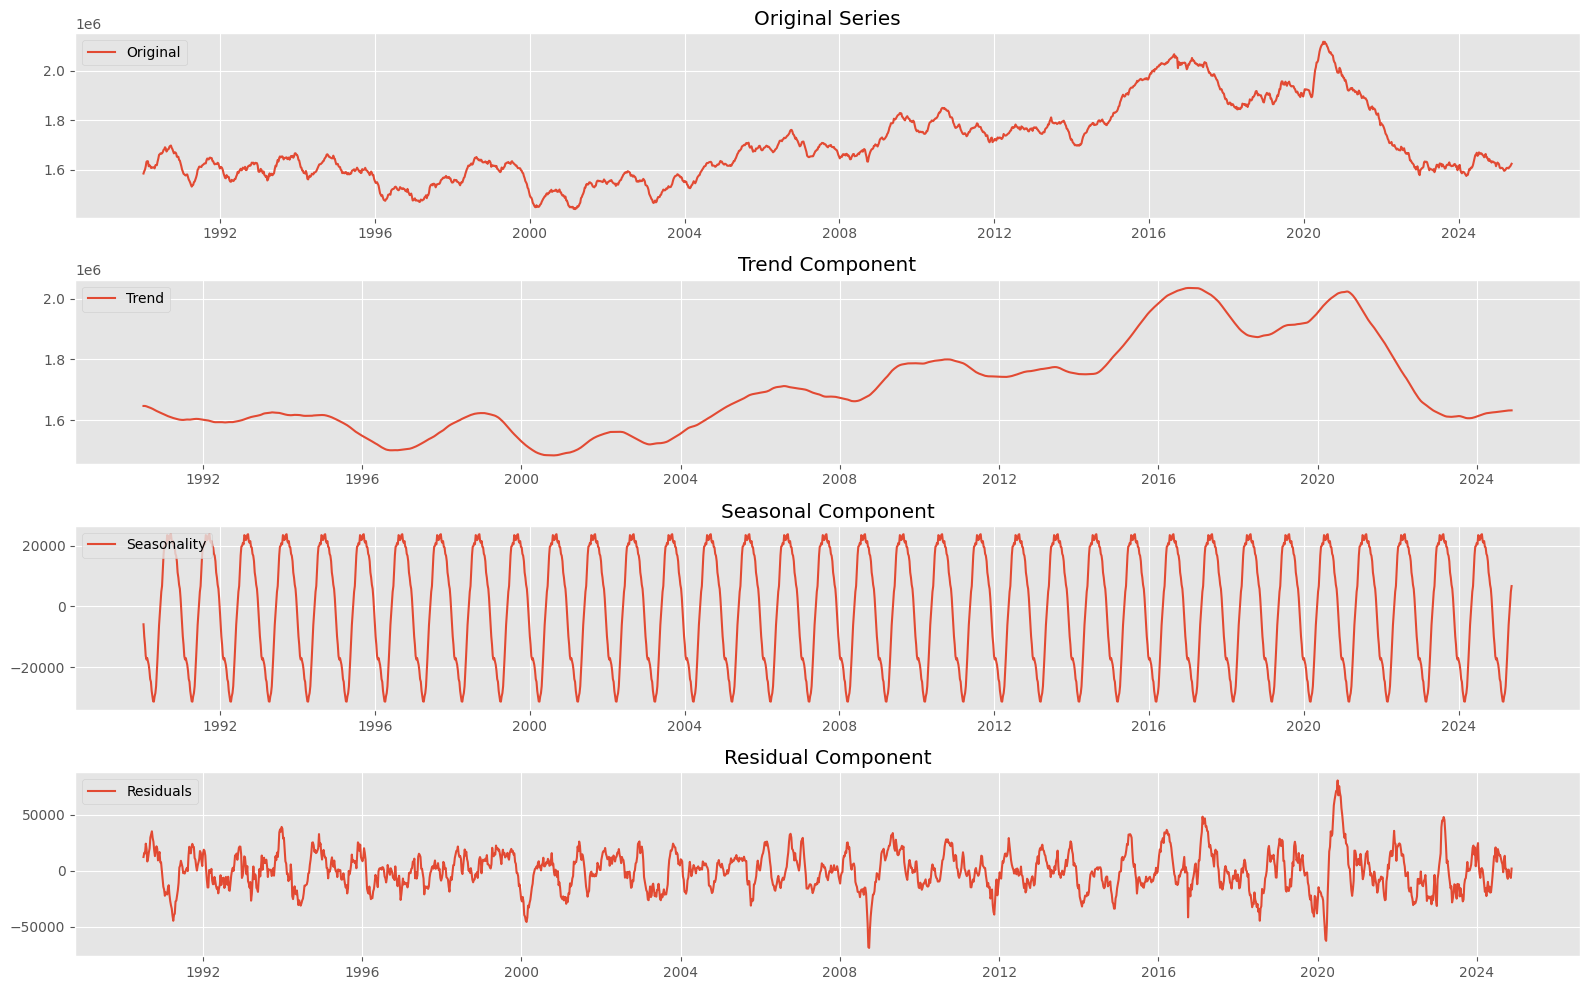

Time Series Decomposition plot saved to /content/visualizations/crude_oil_decomposition.png

--- Forecasting with SARIMA for Crude Oil (Initial Attempt) ---
                                      SARIMAX Results                                      
Dep. Variable:                               Value   No. Observations:                 1476
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood              -14761.974
Date:                             Thu, 22 May 2025   AIC                          29531.947
Time:                                     15:11:05   BIC                          29552.990
Sample:                                 01-05-1990   HQIC                         29539.807
                                      - 04-13-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

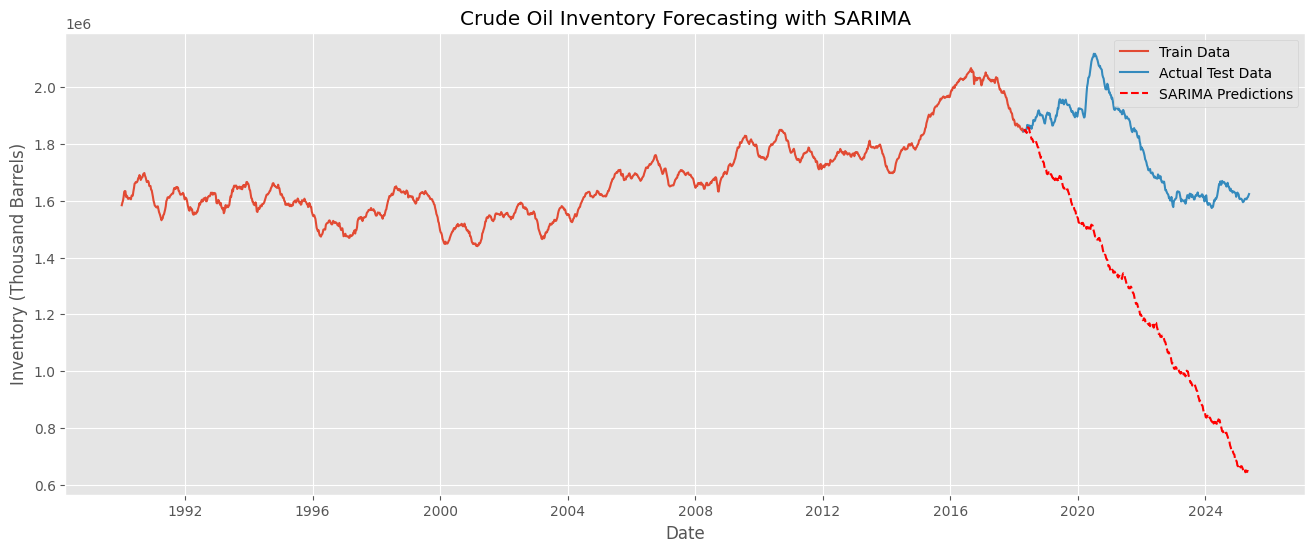

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/b4yp6pdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/ltlwz42l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83780', 'data', 'file=/tmp/tmpi48z_qcp/b4yp6pdv.json', 'init=/tmp/tmpi48z_qcp/ltlwz42l.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelhs3ado3q/prophet_model-20250522151106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:11:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


SARIMA forecast plot saved to /content/visualizations/crude_oil_sarima_forecast.png
SARIMA RMSE: 596771.0230381986
SARIMA MAE: 545298.2669690074

--- Forecasting with Prophet for Crude Oil (Initial Attempt, changepoint_prior_scale=0.05) ---


15:11:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


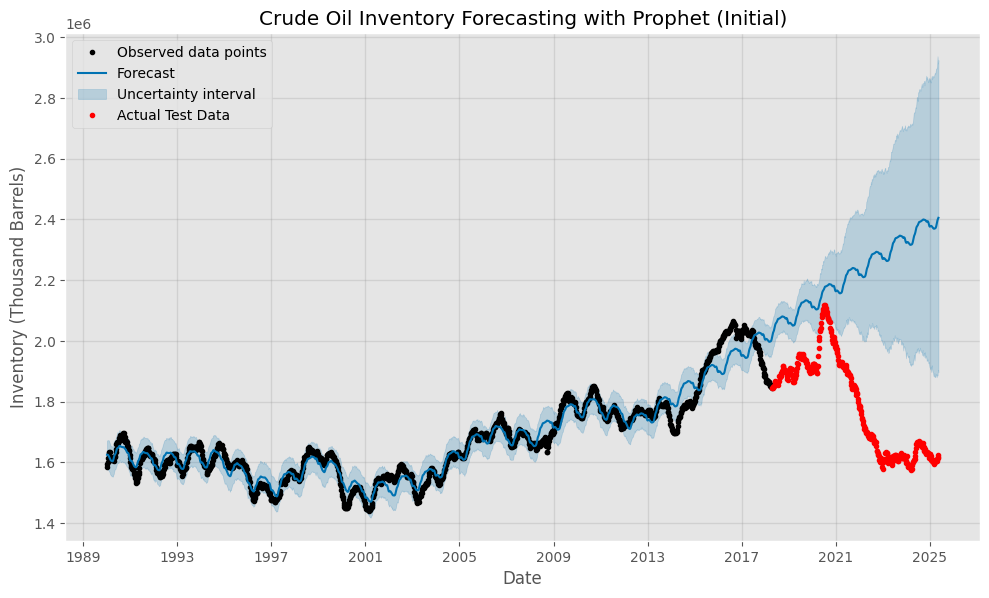

Prophet forecast plot saved to /content/visualizations/crude_oil_prophet_forecast.png
Prophet RMSE: 502037.6632732644
Prophet MAE: 433829.24305309897


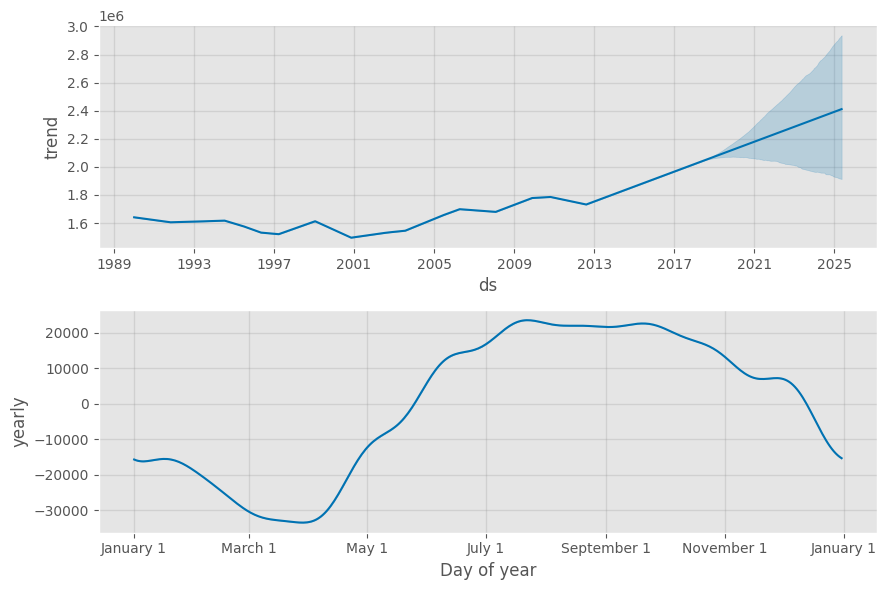

Prophet components plot saved to /content/visualizations/crude_oil_prophet_components.png

--- Initial Forecasting Attempt Complete ---


In [27]:
# --- Colab Cell 3: Forecasting Logic (SARIMA and Prophet Initial Runs) ---

# Load the combined cleaned data
try:
    df = pd.read_csv(cleaned_data_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    print("\nCleaned data loaded successfully for forecasting.")
    # print(df.head()) # Suppress for brevity
    # print(df.info()) # Suppress for brevity

except FileNotFoundError:
    print(f"Error: Cleaned data file not found at {cleaned_data_file}. Please ensure Phase 2 ran successfully.")
    exit() # Exit if data not found

# Separate data for each product - THIS IS WHERE crude_oil_df IS DEFINED
products = df['Product'].unique()
product_dfs = {product: df[df['Product'] == product].drop(columns='Product') for product in products}

# Get crude_oil_df for subsequent forecasting
crude_oil_df = product_dfs.get('Crude Oil')

# print("\nData separated by product:") # Suppress for brevity
# for product, data_df in product_dfs.items():
#     print(f"{product} data shape: {data_df.shape}")
#     print(data_df.head())

# Example Decomposition for Crude Oil
print("\n--- Time Series Decomposition for Crude Oil ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    crude_oil_resampled = crude_oil_df['Value'].asfreq('W-FRI').fillna(method='ffill')

    if len(crude_oil_resampled) > 54: # Need at least 2 full seasons + trend (52*2 + some)
        decomposition = seasonal_decompose(crude_oil_resampled, model='additive', period=52)

        plt.figure(figsize=(16, 10))
        plt.subplot(411)
        plt.plot(crude_oil_resampled, label='Original')
        plt.legend(loc='upper left')
        plt.title('Original Series')

        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend(loc='upper left')
        plt.title('Trend Component')

        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonality')
        plt.legend(loc='upper left')
        plt.title('Seasonal Component')

        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residuals')
        plt.legend(loc='upper left')
        plt.title('Residual Component')

        plt.tight_layout()
        decomposition_plot_path = os.path.join(output_viz_dir, 'crude_oil_decomposition.png')
        plt.savefig(decomposition_plot_path)
        plt.show()
        print(f"Time Series Decomposition plot saved to {decomposition_plot_path}")
    else:
        print("Not enough data points for meaningful seasonal decomposition (need > 52 weeks).")
else:
    print("Crude Oil data not found or is empty for decomposition.")


print("\n--- Forecasting with SARIMA for Crude Oil (Initial Attempt) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    crude_oil_sarima_data = crude_oil_df['Value'].asfreq('W-FRI').ffill()

    train_size = int(len(crude_oil_sarima_data) * 0.8)
    train_data = crude_oil_sarima_data[:train_size]
    test_data = crude_oil_sarima_data[train_size:]

    order = (1, 1, 1)      # (p, d, q)
    seasonal_order = (1, 1, 0, 52) # (P, D, Q, s)

    try:
        sarima_model = SARIMAX(train_data,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=True,
                               enforce_invertibility=True)
        sarima_results = sarima_model.fit(disp=False)
        print(sarima_results.summary())

        start_index = len(train_data)
        end_index = len(crude_oil_sarima_data) - 1
        sarima_predictions = sarima_results.predict(start=start_index, end=end_index, dynamic=False)

        plt.figure(figsize=(16, 6))
        plt.plot(train_data.index, train_data, label='Train Data')
        plt.plot(test_data.index, test_data, label='Actual Test Data')
        plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Predictions', color='red', linestyle='--')
        plt.title('Crude Oil Inventory Forecasting with SARIMA')
        plt.xlabel('Date')
        plt.ylabel('Inventory (Thousand Barrels)')
        plt.legend()
        plt.grid(True)
        sarima_plot_path = os.path.join(output_viz_dir, 'crude_oil_sarima_forecast.png')
        plt.savefig(sarima_plot_path)
        plt.show()
        print(f"SARIMA forecast plot saved to {sarima_plot_path}")

        from sklearn.metrics import mean_squared_error, mean_absolute_error
        rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_predictions))
        mae_sarima = mean_absolute_error(test_data, sarima_predictions)
        print(f"SARIMA RMSE: {rmse_sarima}")
        print(f"SARIMA MAE: {mae_sarima}")

    except Exception as e:
        print(f"An error occurred during SARIMA modeling: {e}")
        print("SARIMA model might not converge for these parameters or data. Consider tuning parameters or trying Prophet.")

else:
    print("Crude Oil data not found or is empty for SARIMA forecasting.")

print("\n--- Forecasting with Prophet for Crude Oil (Initial Attempt, changepoint_prior_scale=0.05) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05 # Initial scale
    )
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI')
    prophet_forecast = m.predict(future)

    fig_prophet = m.plot(prophet_forecast)
    ax = fig_prophet.gca()
    ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data')
    ax.set_title('Crude Oil Inventory Forecasting with Prophet (Initial)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Inventory (Thousand Barrels)')
    ax.legend()
    plt.grid(True)
    prophet_plot_path = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast.png')
    fig_prophet.savefig(prophet_plot_path)
    plt.show()
    print(f"Prophet forecast plot saved to {prophet_plot_path}")

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE: {rmse_prophet}")
    print(f"Prophet MAE: {mae_prophet}")

    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path = os.path.join(output_viz_dir, 'crude_oil_prophet_components.png')
    fig2_prophet.savefig(prophet_components_path)
    plt.show()
    print(f"Prophet components plot saved to {prophet_components_path}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")

print("\n--- Initial Forecasting Attempt Complete ---")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/48vyg2l3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/typa7xtx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97129', 'data', 'file=/tmp/tmpi48z_qcp/48vyg2l3.json', 'init=/tmp/tmpi48z_qcp/typa7xtx.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelptipm_q3/prophet_model-20250522151237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



--- Re-Forecasting with Prophet for Crude Oil (Tuned changepoint_prior_scale=0.005) ---


15:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


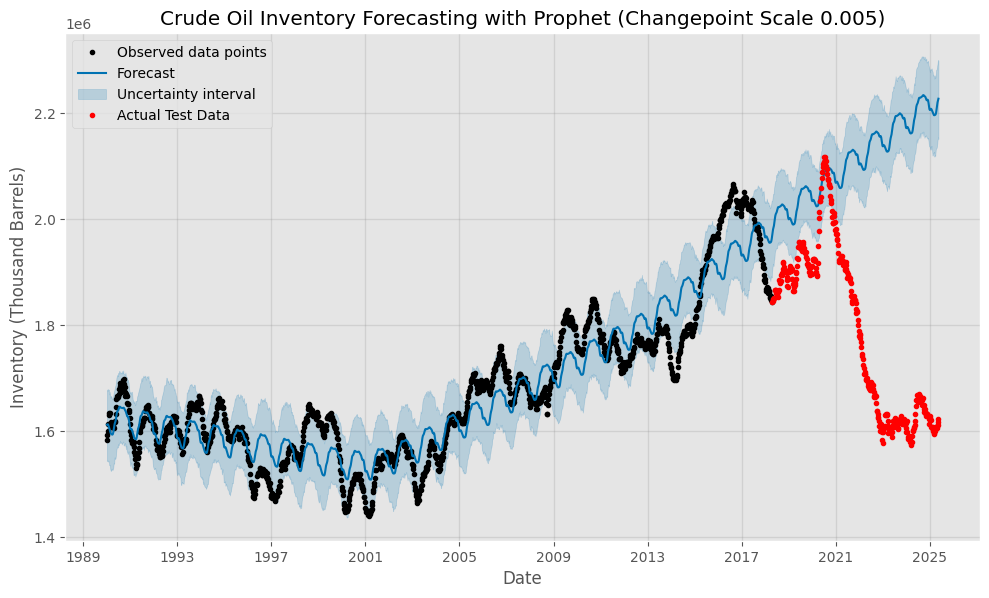

Prophet tuned forecast plot saved to /content/visualizations/crude_oil_prophet_forecast_tuned_005.png
Prophet RMSE (Changepoint Scale 0.005): 388966.2650621041


NameError: name 'mae_mae_prophet' is not defined

In [29]:
# --- Colab Cell 4: Prophet Tuning (changepoint_prior_scale=0.005) ---
# This was a previous tuning attempt, kept for context of the iterations.

print("\n--- Re-Forecasting with Prophet for Crude Oil (Tuned changepoint_prior_scale=0.005) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.005 # <--- Less flexible scale
    )
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI')
    prophet_forecast = m.predict(future)

    fig_prophet = m.plot(prophet_forecast)
    ax = fig_prophet.gca()
    ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data')
    ax.set_title('Crude Oil Inventory Forecasting with Prophet (Changepoint Scale 0.005)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Inventory (Thousand Barrels)')
    ax.legend()
    plt.grid(True)
    prophet_plot_path_tuned = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast_tuned_005.png')
    fig_prophet.savefig(prophet_plot_path_tuned)
    plt.show()
    print(f"Prophet tuned forecast plot saved to {prophet_plot_path_tuned}")

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE (Changepoint Scale 0.005): {rmse_prophet}")
    print(f"Prophet MAE (Changepoint Scale 0.005): {mae_mae_prophet}")

    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path_tuned = os.path.join(output_viz_dir, 'crude_oil_prophet_components_tuned_005.png')
    fig2_prophet.savefig(prophet_components_path_tuned)
    plt.show()
    print(f"Prophet tuned components plot saved to {prophet_components_path_tuned}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")

print("\n--- Prophet Tuning Attempt (Changepoint Scale 0.005) Complete ---")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/ea3795t0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/5bkjknz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9183', 'data', 'file=/tmp/tmpi48z_qcp/ea3795t0.json', 'init=/tmp/tmpi48z_qcp/5bkjknz6.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_model22koxo55/prophet_model-20250522151256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:12:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



--- Re-Forecasting with Prophet for Crude Oil (Increased changepoint_prior_scale to 0.1) ---


15:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


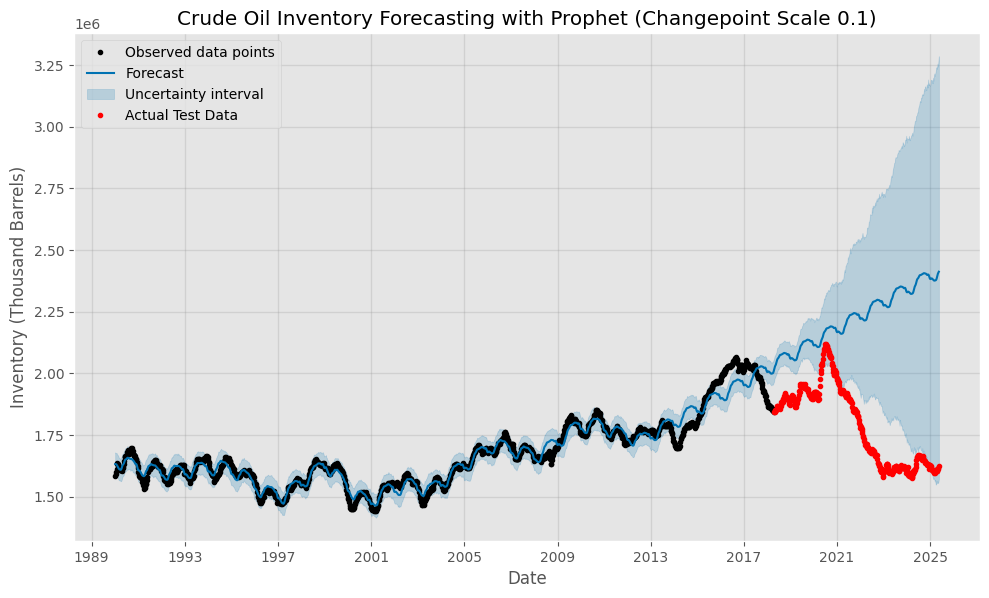

Prophet tuned forecast plot saved to /content/visualizations/crude_oil_prophet_forecast_tuned_higher.png
Prophet RMSE (Changepoint Scale 0.1): 506205.7470889349
Prophet MAE (Changepoint Scale 0.1): 437885.904202103


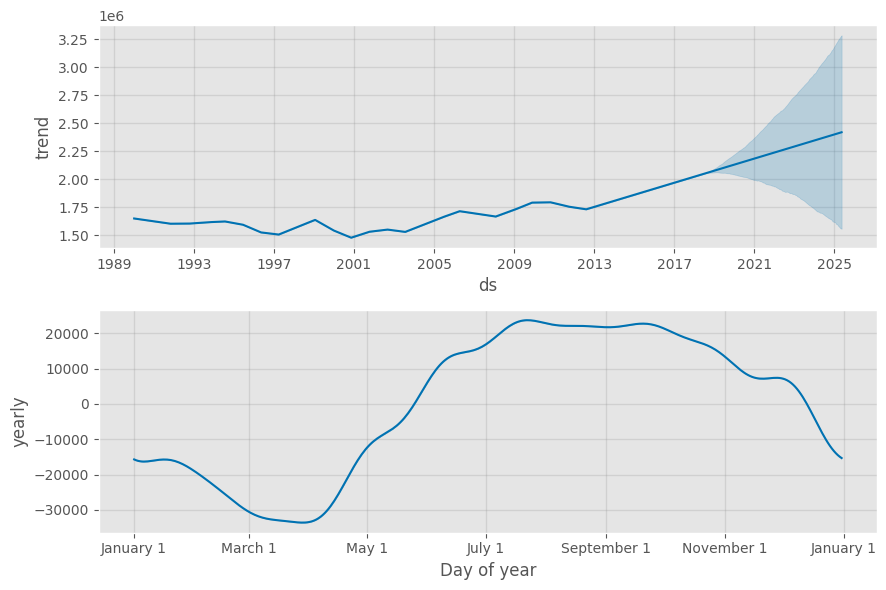

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/jugaq8ua.json


Prophet tuned components plot saved to /content/visualizations/crude_oil_prophet_components_tuned_higher.png

--- Generating and Exporting Future Forecasts (Example: Crude Oil - Tuned Prophet 0.1) ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/6xbtf71d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63464', 'data', 'file=/tmp/tmpi48z_qcp/jugaq8ua.json', 'init=/tmp/tmpi48z_qcp/6xbtf71d.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_model2lbjbljb/prophet_model-20250522151259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:12:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Future forecasts for Crude Oil saved to /content/crude_oil_future_forecast_tuned_higher.csv
           Date  Forecast_Value  Forecast_Lower_Bound  Forecast_Upper_Bound  \
1846 2025-05-23    1.580286e+06          1.519023e+06          1.642986e+06   
1847 2025-05-30    1.585662e+06          1.523291e+06          1.650213e+06   
1848 2025-06-06    1.590517e+06          1.529286e+06          1.651121e+06   
1849 2025-06-13    1.592794e+06          1.529555e+06          1.659788e+06   
1850 2025-06-20    1.592747e+06          1.528167e+06          1.652298e+06   

        Product  
1846  Crude Oil  
1847  Crude Oil  
1848  Crude Oil  
1849  Crude Oil  
1850  Crude Oil  
           Date  Forecast_Value  Forecast_Lower_Bound  Forecast_Upper_Bound  \
1867 2025-10-17    1.575933e+06          1.517528e+06          1.639798e+06   
1868 2025-10-24    1.573230e+06          1.512260e+06          1.637493e+06   
1869 2025-10-31    1.569468e+06          1.508095e+06          1.631102e+06   
1870 2025

In [30]:
# --- Colab Cell 5: Prophet Tuning (changepoint_prior_scale=0.1) ---
# This is the current, most relevant attempt to make Prophet more flexible.

print("\n--- Re-Forecasting with Prophet for Crude Oil (Increased changepoint_prior_scale to 0.1) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.1 # <--- Increased to 0.1, aiming for more flexibility
    )
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI')
    prophet_forecast = m.predict(future)

    fig_prophet = m.plot(prophet_forecast)
    ax = fig_prophet.gca()
    ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data')
    ax.set_title('Crude Oil Inventory Forecasting with Prophet (Changepoint Scale 0.1)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Inventory (Thousand Barrels)')
    ax.legend()
    plt.grid(True)
    prophet_plot_path_tuned_higher = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast_tuned_higher.png')
    fig_prophet.savefig(prophet_plot_path_tuned_higher)
    plt.show()
    print(f"Prophet tuned forecast plot saved to {prophet_plot_path_tuned_higher}")

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE (Changepoint Scale 0.1): {rmse_prophet}")
    print(f"Prophet MAE (Changepoint Scale 0.1): {mae_prophet}")

    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path_tuned_higher = os.path.join(output_viz_dir, 'crude_oil_prophet_components_tuned_higher.png')
    fig2_prophet.savefig(prophet_components_path_tuned_higher)
    plt.show()
    print(f"Prophet tuned components plot saved to {prophet_components_path_tuned_higher}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")

# --- Re-generate and Export Future Forecasts with Tuned Prophet ---
print("\n--- Generating and Exporting Future Forecasts (Example: Crude Oil - Tuned Prophet 0.1) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df_full = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})
    m_full_tuned_higher = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.1) # Use tuned scale
    m_full_tuned_higher.fit(prophet_df_full)

    future_periods = 26 # Next 6 months (26 weeks)
    future = m_full_tuned_higher.make_future_dataframe(periods=future_periods, freq='W-FRI')

    forecast_full = m_full_tuned_higher.predict(future)

    last_actual_date = prophet_df_full['ds'].max()
    future_forecast = forecast_full[forecast_full['ds'] > last_actual_date]

    future_forecast_export = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    future_forecast_export.rename(columns={'ds': 'Date', 'yhat': 'Forecast_Value',
                                           'yhat_lower': 'Forecast_Lower_Bound',
                                           'yhat_upper': 'Forecast_Upper_Bound'}, inplace=True)
    future_forecast_export['Product'] = 'Crude Oil'

    forecast_output_path_tuned_higher = os.path.join(data_dir, 'crude_oil_future_forecast_tuned_higher.csv')
    future_forecast_export.to_csv(forecast_output_path_tuned_higher, index=False)

    print(f"Future forecasts for Crude Oil saved to {forecast_output_path_tuned_higher}")
    print(future_forecast_export.head())
    print(future_forecast_export.tail())
else:
    print("Crude Oil data not available for future forecasting.")

print("\n--- Prophet Tuning Attempt (Higher Changepoint Scale) Complete ---")
print("Check the new 'crude_oil_prophet_forecast_tuned_higher.png' and 'crude_oil_prophet_components_tuned_higher.png' plots.")

In [32]:
# --- Colab Cell X: Automated SARIMA Tuning with pmdarima ---
print("\n--- Installing pmdarima for Automated SARIMA Tuning ---")
!pip install pmdarima

import pmdarima as pm
import matplotlib.pyplot as plt
import os
import numpy as np # Ensure numpy is imported

print("\n--- Automated SARIMA Forecasting for Crude Oil ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    crude_oil_sarima_data = crude_oil_df['Value'].asfreq('W-FRI').ffill()

    train_size = int(len(crude_oil_sarima_data) * 0.8)
    train_data = crude_oil_sarima_data[:train_size]
    test_data = crude_oil_sarima_data[train_size:]

    # Use auto_arima to find the best SARIMA model
    # seasonal=True enables SARIMA, m=52 for yearly seasonality (weekly data)
    # suppress_warnings=True cleans up output
    # stepwise=True uses a faster algorithm to search for parameters
    print("Running auto_arima... This may take a few minutes.")
    arima_model = pm.auto_arima(train_data, seasonal=True, m=52,
                                suppress_warnings=True, stepwise=True,
                                error_action="ignore", trace=False,
                                D=1, # Seasonal differencing can be fixed to 1 for yearly
                                max_order=None, # Allow auto_arima to explore a wide range of orders
                                n_jobs=-1) # Use all available cores for speed

    print("\nBest SARIMA model parameters found by auto_arima:")
    print(arima_model.summary())

    # Make predictions
    sarima_predictions_auto = arima_model.predict(n_periods=len(test_data))
    sarima_predictions_auto.index = test_data.index # Align index for plotting and evaluation

    # Plotting
    plt.figure(figsize=(16, 6))
    plt.plot(train_data.index, train_data, label='Train Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(sarima_predictions_auto.index, sarima_predictions_auto, label='Auto SARIMA Predictions', color='green', linestyle='--')
    plt.title('Crude Oil Inventory Forecasting with Auto SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Inventory (Thousand Barrels)')
    plt.legend()
    plt.grid(True)
    auto_sarima_plot_path = os.path.join(output_viz_dir, 'crude_oil_auto_sarima_forecast.png')
    plt.savefig(auto_sarima_plot_path)
    plt.show()
    print(f"Auto SARIMA forecast plot saved to {auto_sarima_plot_path}")

    # Evaluation
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    rmse_auto_sarima = np.sqrt(mean_squared_error(test_data, sarima_predictions_auto))
    mae_auto_sarima = mean_absolute_error(test_data, sarima_predictions_auto)
    print(f"Auto SARIMA RMSE: {rmse_auto_sarima}")
    print(f"Auto SARIMA MAE: {mae_auto_sarima}")

else:
    print("Crude Oil data not found or is empty for Auto SARIMA forecasting.")

print("\n--- Automated SARIMA Tuning Complete ---")


--- Installing pmdarima for Automated SARIMA Tuning ---

--- Automated SARIMA Forecasting for Crude Oil ---
Running auto_arima... This may take a few minutes.


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will 

KeyboardInterrupt: 

In [33]:
# --- Colab Cell 1: Install Libraries & Setup Paths ---
# Ensure these are installed
!pip install openpyxl matplotlib seaborn statsmodels pystan prophet
# You might need to restart your runtime after installing pystan, then run this cell again.

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import logging # For Prophet verbosity
import numpy as np # Import numpy for numerical operations

# Suppress Prophet's verbose output
logging.getLogger('prophet').setLevel(logging.WARNING)

# Define the path to your cleaned CSV
data_dir = '/content/'
cleaned_data_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')
output_viz_dir = os.path.join(data_dir, 'visualizations')
os.makedirs(output_viz_dir, exist_ok=True) # Ensure directory exists

print(f"Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls")
print(f"Output cleaned data will be saved to: {cleaned_data_file}")
print(f"Visualizations will be saved to: {output_viz_dir}")

Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls
Output cleaned data will be saved to: /content/cleaned_eia_inventory.csv
Visualizations will be saved to: /content/visualizations


In [34]:
# --- Colab Cell 2: Data Preprocessing Logic ---
# This section contains the function to load and clean EIA data, and then applies it.

def load_and_clean_eia_data(filepath, product_name, header_row_index, sheet_name):
    """
    Loads EIA data from an Excel file, cleans it, and returns a DataFrame.
    'header_row_index' is the 0-indexed row number where the actual column headers are located.
    'sheet_name' is the name of the Excel sheet containing the data.
    """
    try:
        df_raw = pd.read_excel(filepath, sheet_name=sheet_name, header=header_row_index)

        original_cols = df_raw.columns.tolist()
        date_col = None
        for col in original_cols:
            if isinstance(col, str) and ('date' in col.lower() or 'week ended' in col.lower() or 'observation date' in col.lower()):
                date_col = col
                break
        if date_col is None and original_cols:
            date_col = original_cols[0]

        value_col = None
        if len(original_cols) > 1:
            value_col = original_cols[1]

        if date_col is None or value_col is None:
            print(f"Warning: Could not identify Date ('{date_col}') or Value ('{value_col}') columns in {filepath}. Available columns: {original_cols}")
            return pd.DataFrame()

        df = df_raw.rename(columns={date_col: 'Date', value_col: 'Value'})
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['Product'] = product_name
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        df.dropna(subset=['Date', 'Value'], how='all', inplace=True)
        df['Value'] = df['Value'].ffill()
        df.dropna(subset=['Date'], inplace=True)
        df = df[['Date', 'Product', 'Value']].sort_values(by='Date').reset_index(drop=True)

        print(f"Successfully loaded and cleaned {filepath} for {product_name}.")
        print(f"Shape: {df.shape}")
        print(f"Missing values after cleaning:\n{df.isnull().sum()}")
        # print(f"First 5 rows for {product_name}:\n{df.head()}") # Suppress for brevity
        # print(f"Last 5 rows for {product_name}:\n{df.tail()}") # Suppress for brevity

        return df

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}. Please ensure it's uploaded to Colab.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {filepath}: {e}")
        return pd.DataFrame()

# File paths (from previous steps)
file_distillate = os.path.join(data_dir, 'WDISTUS1w.xls')
file_gasoline = os.path.join(data_dir, 'WGTSTUS1w.xls')
file_crude = os.path.join(data_dir, 'WTTSTUS1w.xls')

SHEET_NAME = 'Data 1'
HEADER_ROW_INDEX = 2

print("\n--- Processing Distillate Data ---")
df_distillate = load_and_clean_eia_data(file_distillate, 'Distillate Fuel Oil', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Gasoline Data ---")
df_gasoline = load_and_clean_eia_data(file_gasoline, 'Motor Gasoline', HEADER_ROW_INDEX, SHEET_NAME)

print("\n--- Processing Crude Oil Data ---")
df_crude = load_and_clean_eia_data(file_crude, 'Crude Oil', HEADER_ROW_INDEX, SHEET_NAME)

all_dfs = [df for df in [df_distillate, df_gasoline, df_crude] if not df.empty]

if all_dfs:
    combined_df = pd.concat(all_dfs).sort_values(by=['Date', 'Product']).reset_index(drop=True)
    combined_df.drop_duplicates(subset=['Date', 'Product'], inplace=True)
    combined_df.to_csv(cleaned_data_file, index=False)
    print(f"\nCombined and cleaned data saved to {cleaned_data_file}")
    # print(f"Final combined DataFrame shape: {combined_df.shape}") # Suppress for brevity
    # print(f"Unique products in combined data: {combined_df['Product'].unique()}") # Suppress for brevity
else:
    print("\nNo data was successfully loaded and combined.")


--- Processing Distillate Data ---
Successfully loaded and cleaned /content/WDISTUS1w.xls for Distillate Fuel Oil.
Shape: (2225, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

--- Processing Gasoline Data ---
Successfully loaded and cleaned /content/WGTSTUS1w.xls for Motor Gasoline.
Shape: (1846, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

--- Processing Crude Oil Data ---
Successfully loaded and cleaned /content/WTTSTUS1w.xls for Crude Oil.
Shape: (1846, 3)
Missing values after cleaning:
Date       0
Product    0
Value      0
dtype: int64

Combined and cleaned data saved to /content/cleaned_eia_inventory.csv



Cleaned data loaded successfully for forecasting.

--- Time Series Decomposition for Crude Oil ---


<ipython-input-35-a93698ccb4c3>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crude_oil_resampled = crude_oil_df['Value'].asfreq('W-FRI').fillna(method='ffill')


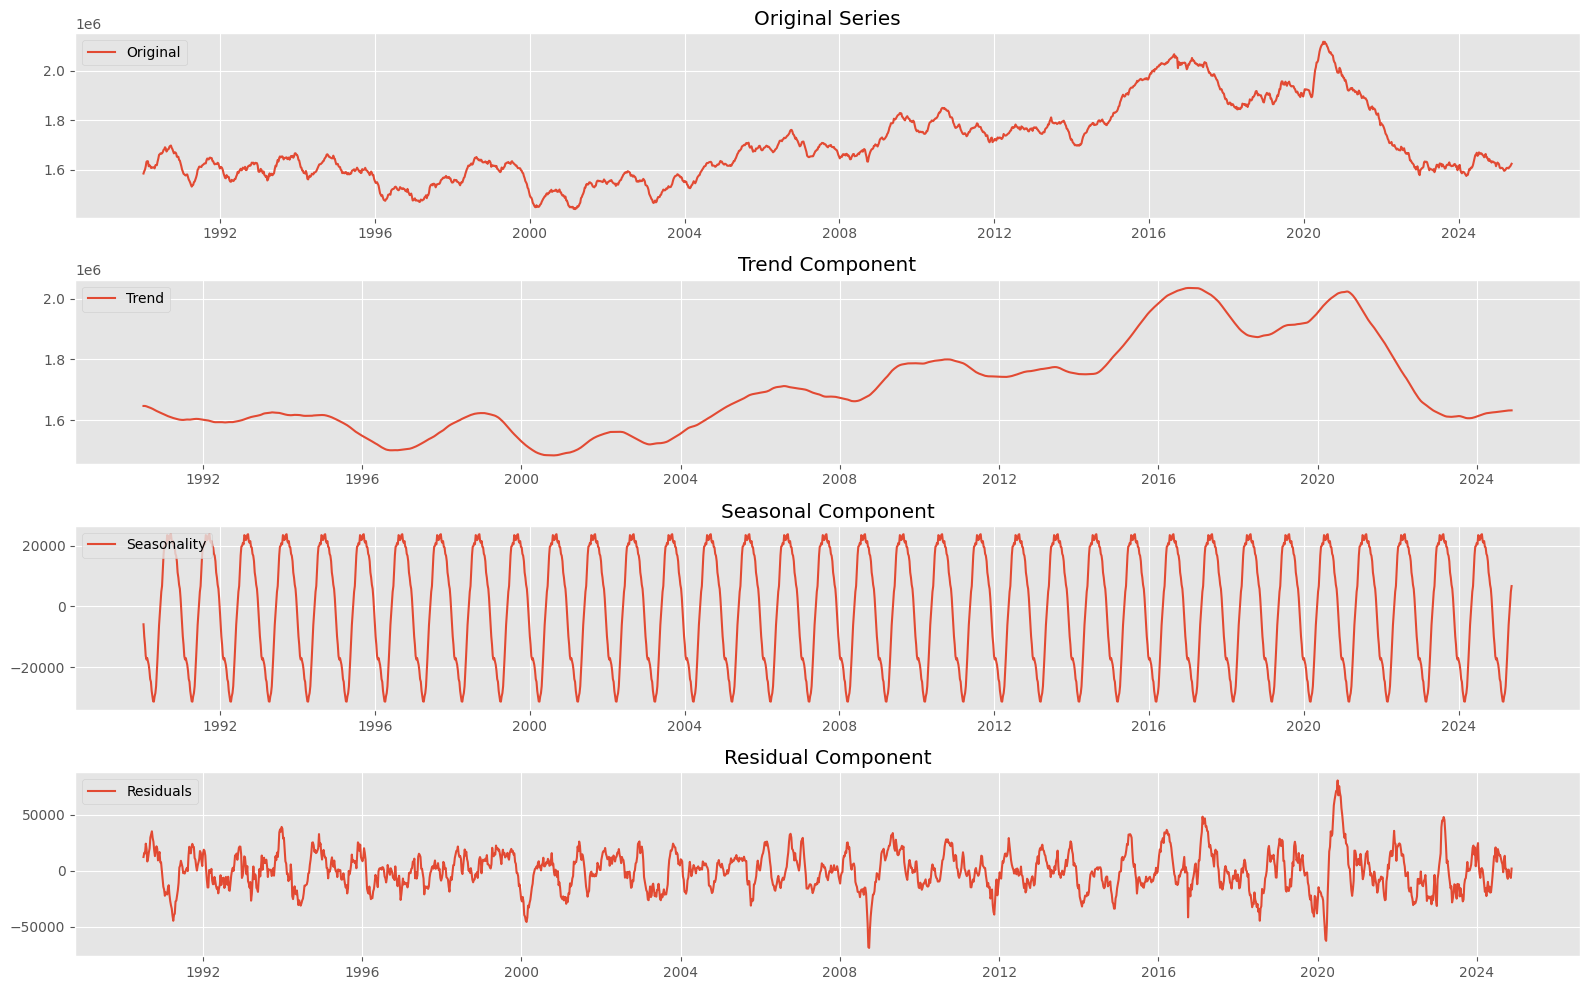

Time Series Decomposition plot saved to /content/visualizations/crude_oil_decomposition.png

--- Forecasting with SARIMA for Crude Oil (Initial Attempt) ---
                                      SARIMAX Results                                      
Dep. Variable:                               Value   No. Observations:                 1476
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood              -14761.974
Date:                             Thu, 22 May 2025   AIC                          29531.947
Time:                                     15:20:06   BIC                          29552.990
Sample:                                 01-05-1990   HQIC                         29539.807
                                      - 04-13-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

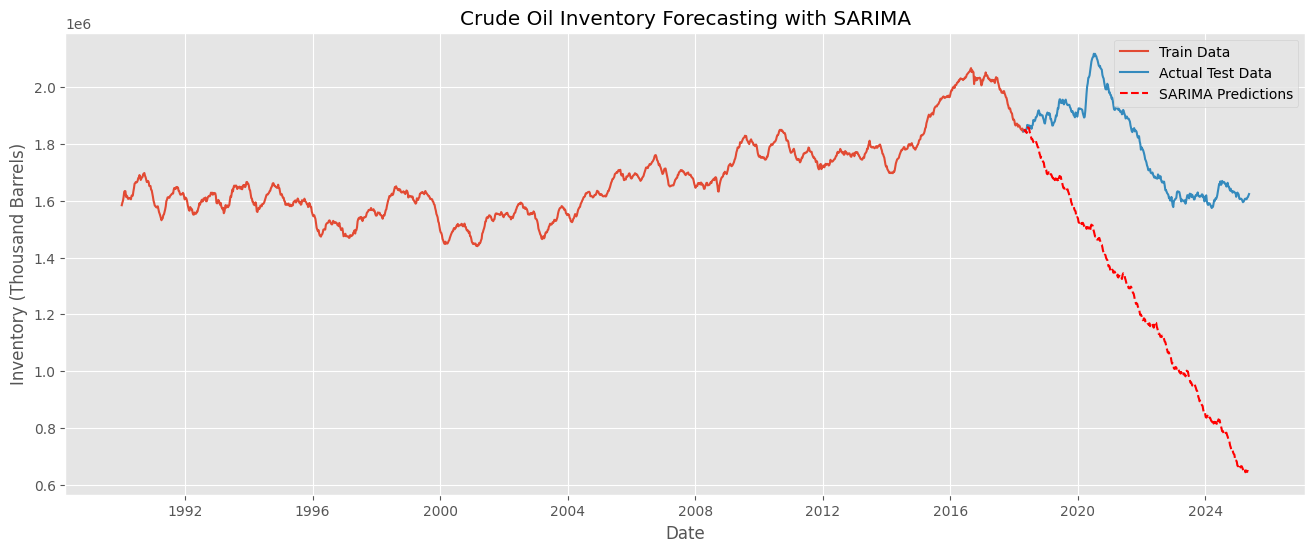

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/1baf2n3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/osvwqtib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9561', 'data', 'file=/tmp/tmpi48z_qcp/1baf2n3f.json', 'init=/tmp/tmpi48z_qcp/osvwqtib.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modeloup0ytv1/prophet_model-20250522152007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:20:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


SARIMA forecast plot saved to /content/visualizations/crude_oil_sarima_forecast.png
SARIMA RMSE: 596771.0230381986
SARIMA MAE: 545298.2669690074

--- Forecasting with Prophet for Crude Oil (Initial Attempt, changepoint_prior_scale=0.05) ---


15:20:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


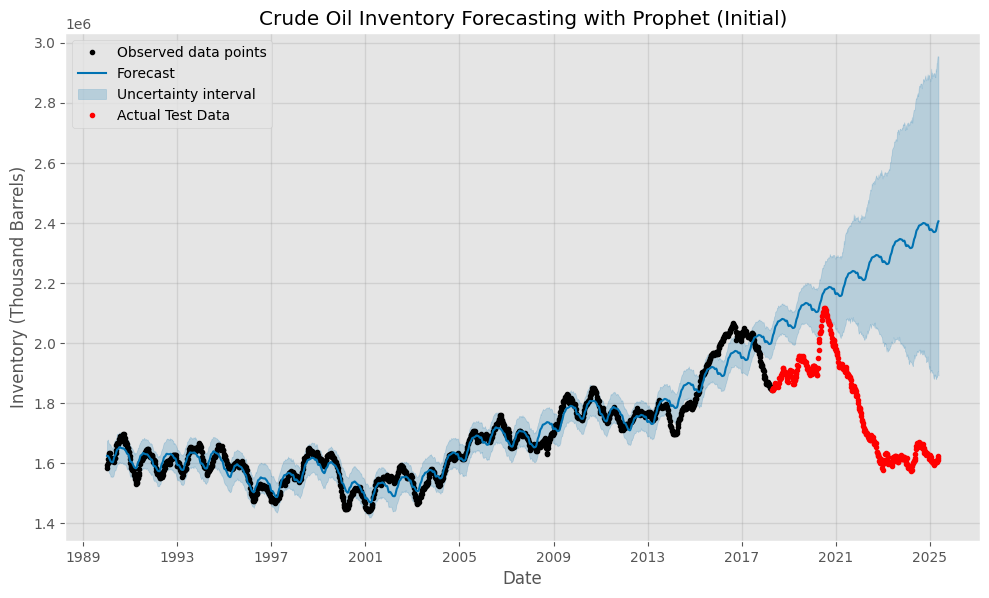

Prophet forecast plot saved to /content/visualizations/crude_oil_prophet_forecast.png
Prophet RMSE: 502037.6632732644
Prophet MAE: 433829.24305309897


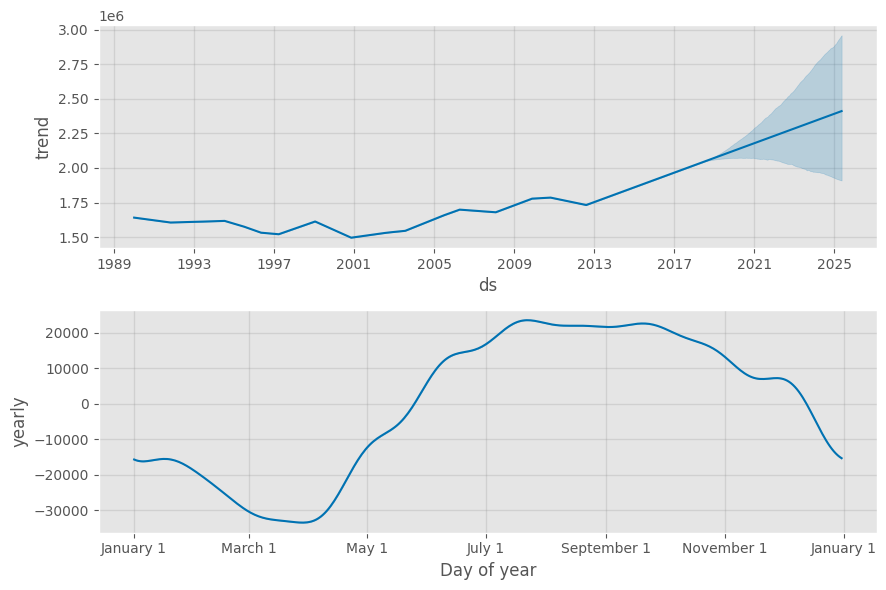

Prophet components plot saved to /content/visualizations/crude_oil_prophet_components.png

--- Initial Forecasting Attempt Complete ---


In [35]:
# --- Colab Cell 3: Forecasting Logic (SARIMA and Prophet Initial Runs) ---

# Load the combined cleaned data
try:
    df = pd.read_csv(cleaned_data_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    print("\nCleaned data loaded successfully for forecasting.")
    # print(df.head()) # Suppress for brevity
    # print(df.info()) # Suppress for brevity

except FileNotFoundError:
    print(f"Error: Cleaned data file not found at {cleaned_data_file}. Please ensure Phase 2 ran successfully.")
    exit() # Exit if data not found

# Separate data for each product - THIS IS WHERE crude_oil_df IS DEFINED
products = df['Product'].unique()
product_dfs = {product: df[df['Product'] == product].drop(columns='Product') for product in products}

# Get crude_oil_df for subsequent forecasting
crude_oil_df = product_dfs.get('Crude Oil')

# print("\nData separated by product:") # Suppress for brevity
# for product, data_df in product_dfs.items():
#     print(f"{product} data shape: {data_df.shape}")
#     print(data_df.head())

# Example Decomposition for Crude Oil
print("\n--- Time Series Decomposition for Crude Oil ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    crude_oil_resampled = crude_oil_df['Value'].asfreq('W-FRI').fillna(method='ffill')

    if len(crude_oil_resampled) > 54: # Need at least 2 full seasons + trend (52*2 + some)
        decomposition = seasonal_decompose(crude_oil_resampled, model='additive', period=52)

        plt.figure(figsize=(16, 10))
        plt.subplot(411)
        plt.plot(crude_oil_resampled, label='Original')
        plt.legend(loc='upper left')
        plt.title('Original Series')

        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend(loc='upper left')
        plt.title('Trend Component')

        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonality')
        plt.legend(loc='upper left')
        plt.title('Seasonal Component')

        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residuals')
        plt.legend(loc='upper left')
        plt.title('Residual Component')

        plt.tight_layout()
        decomposition_plot_path = os.path.join(output_viz_dir, 'crude_oil_decomposition.png')
        plt.savefig(decomposition_plot_path)
        plt.show()
        print(f"Time Series Decomposition plot saved to {decomposition_plot_path}")
    else:
        print("Not enough data points for meaningful seasonal decomposition (need > 52 weeks).")
else:
    print("Crude Oil data not found or is empty for decomposition.")


print("\n--- Forecasting with SARIMA for Crude Oil (Initial Attempt) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    crude_oil_sarima_data = crude_oil_df['Value'].asfreq('W-FRI').ffill()

    train_size = int(len(crude_oil_sarima_data) * 0.8)
    train_data = crude_oil_sarima_data[:train_size]
    test_data = crude_oil_sarima_data[train_size:]

    order = (1, 1, 1)      # (p, d, q)
    seasonal_order = (1, 1, 0, 52) # (P, D, Q, s)

    try:
        sarima_model = SARIMAX(train_data,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=True,
                               enforce_invertibility=True)
        sarima_results = sarima_model.fit(disp=False)
        print(sarima_results.summary())

        start_index = len(train_data)
        end_index = len(crude_oil_sarima_data) - 1
        sarima_predictions = sarima_results.predict(start=start_index, end=end_index, dynamic=False)

        plt.figure(figsize=(16, 6))
        plt.plot(train_data.index, train_data, label='Train Data')
        plt.plot(test_data.index, test_data, label='Actual Test Data')
        plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Predictions', color='red', linestyle='--')
        plt.title('Crude Oil Inventory Forecasting with SARIMA')
        plt.xlabel('Date')
        plt.ylabel('Inventory (Thousand Barrels)')
        plt.legend()
        plt.grid(True)
        sarima_plot_path = os.path.join(output_viz_dir, 'crude_oil_sarima_forecast.png')
        plt.savefig(sarima_plot_path)
        plt.show()
        print(f"SARIMA forecast plot saved to {sarima_plot_path}")

        from sklearn.metrics import mean_squared_error, mean_absolute_error
        rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_predictions))
        mae_sarima = mean_absolute_error(test_data, sarima_predictions)
        print(f"SARIMA RMSE: {rmse_sarima}")
        print(f"SARIMA MAE: {mae_sarima}")

    except Exception as e:
        print(f"An error occurred during SARIMA modeling: {e}")
        print("SARIMA model might not converge for these parameters or data. Consider tuning parameters or trying Prophet.")

else:
    print("Crude Oil data not found or is empty for SARIMA forecasting.")

print("\n--- Forecasting with Prophet for Crude Oil (Initial Attempt, changepoint_prior_scale=0.05) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05 # Initial scale
    )
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI')
    prophet_forecast = m.predict(future)

    fig_prophet = m.plot(prophet_forecast)
    ax = fig_prophet.gca()
    ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data')
    ax.set_title('Crude Oil Inventory Forecasting with Prophet (Initial)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Inventory (Thousand Barrels)')
    ax.legend()
    plt.grid(True)
    prophet_plot_path = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast.png')
    fig_prophet.savefig(prophet_plot_path)
    plt.show()
    print(f"Prophet forecast plot saved to {prophet_plot_path}")

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE: {rmse_prophet}")
    print(f"Prophet MAE: {mae_prophet}")

    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path = os.path.join(output_viz_dir, 'crude_oil_prophet_components.png')
    fig2_prophet.savefig(prophet_components_path)
    plt.show()
    print(f"Prophet components plot saved to {prophet_components_path}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")

print("\n--- Initial Forecasting Attempt Complete ---")


--- Re-Forecasting with Prophet for Crude Oil (Tuned changepoint_prior_scale=0.005) ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/zq3e7bfy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/4zcr_ko_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85435', 'data', 'file=/tmp/tmpi48z_qcp/zq3e7bfy.json', 'init=/tmp/tmpi48z_qcp/4zcr_ko_.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelx3f6_32t/prophet_model-20250522152051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


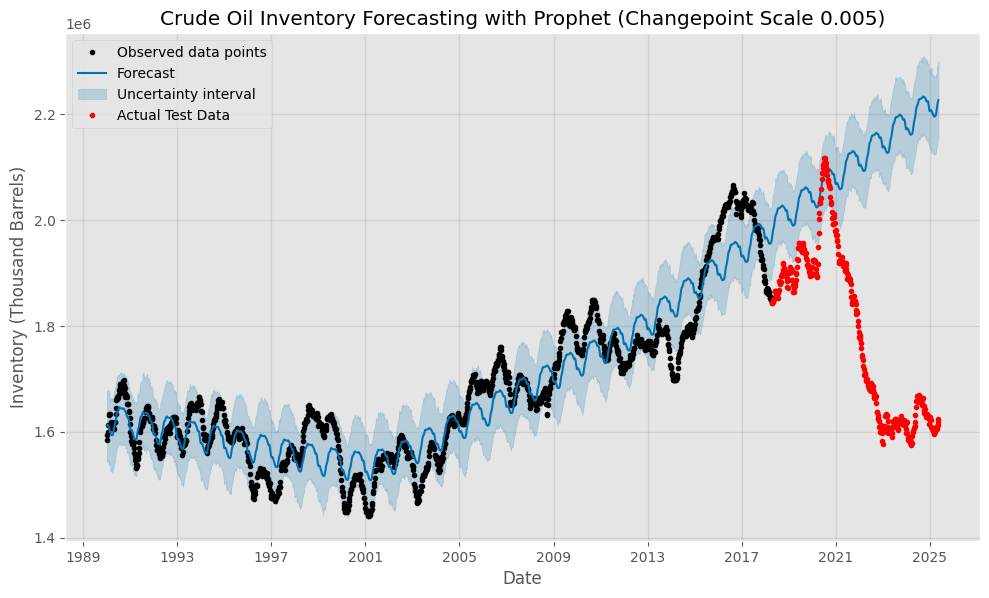

Prophet tuned forecast plot saved to /content/visualizations/crude_oil_prophet_forecast_tuned_005.png
Prophet RMSE (Changepoint Scale 0.005): 388966.2650621041


NameError: name 'mae_mae_prophet' is not defined

In [36]:
# --- Colab Cell 4: Prophet Tuning (changepoint_prior_scale=0.005) ---
# This was a previous tuning attempt, kept for context of the iterations.

print("\n--- Re-Forecasting with Prophet for Crude Oil (Tuned changepoint_prior_scale=0.005) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.005 # <--- Less flexible scale
    )
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI')
    prophet_forecast = m.predict(future)

    fig_prophet = m.plot(prophet_forecast)
    ax = fig_prophet.gca()
    ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data')
    ax.set_title('Crude Oil Inventory Forecasting with Prophet (Changepoint Scale 0.005)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Inventory (Thousand Barrels)')
    ax.legend()
    plt.grid(True)
    prophet_plot_path_tuned = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast_tuned_005.png')
    fig_prophet.savefig(prophet_plot_path_tuned)
    plt.show()
    print(f"Prophet tuned forecast plot saved to {prophet_plot_path_tuned}")

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE (Changepoint Scale 0.005): {rmse_prophet}")
    print(f"Prophet MAE (Changepoint Scale 0.005): {mae_mae_prophet}")

    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path_tuned = os.path.join(output_viz_dir, 'crude_oil_prophet_components_tuned_005.png')
    fig2_prophet.savefig(prophet_components_path_tuned)
    plt.show()
    print(f"Prophet tuned components plot saved to {prophet_components_path_tuned}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")

print("\n--- Prophet Tuning Attempt (Changepoint Scale 0.005) Complete ---")

In [39]:
# --- Colab Cell X: Automated SARIMA Tuning with pmdarima ---
print("\n--- Installing pmdarima for Automated SARIMA Tuning ---")
!pip install pmdarima

import pmdarima as pm
import matplotlib.pyplot as plt
import os
import numpy as np # Ensure numpy is imported

print("\n--- Automated SARIMA Forecasting for Crude Oil ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    crude_oil_sarima_data = crude_oil_df['Value'].asfreq('W-FRI').ffill()

    train_size = int(len(crude_oil_sarima_data) * 0.8)
    train_data = crude_oil_sarima_data[:train_size]
    test_data = crude_oil_sarima_data[train_size:]

    # Use auto_arima to find the best SARIMA model
    # seasonal=True enables SARIMA, m=52 for yearly seasonality (weekly data)
    # suppress_warnings=True cleans up output
    # stepwise=True uses a faster algorithm to search for parameters
    print("Running auto_arima... This may take a few minutes.")
    arima_model = pm.auto_arima(train_data, seasonal=True, m=52,
                                suppress_warnings=True, stepwise=True,
                                error_action="ignore", trace=False,
                                D=1, # Seasonal differencing can be fixed to 1 for yearly
                                max_order=None, # Allow auto_arima to explore a wide range of orders
                                n_jobs=-1) # Use all available cores for speed

    print("\nBest SARIMA model parameters found by auto_arima:")
    print(arima_model.summary())

    # Make predictions
    sarima_predictions_auto = arima_model.predict(n_periods=len(test_data))
    sarima_predictions_auto.index = test_data.index # Align index for plotting and evaluation

    # Plotting
    plt.figure(figsize=(16, 6))
    plt.plot(train_data.index, train_data, label='Train Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(sarima_predictions_auto.index, sarima_predictions_auto, label='Auto SARIMA Predictions', color='green', linestyle='--')
    plt.title('Crude Oil Inventory Forecasting with Auto SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Inventory (Thousand Barrels)')
    plt.legend()
    plt.grid(True)
    auto_sarima_plot_path = os.path.join(output_viz_dir, 'crude_oil_auto_sarima_forecast.png')
    plt.savefig(auto_sarima_plot_path)
    plt.show()
    print(f"Auto SARIMA forecast plot saved to {auto_sarima_plot_path}")

    # Evaluation
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    rmse_auto_sarima = np.sqrt(mean_squared_error(test_data, sarima_predictions_auto))
    mae_auto_sarima = mean_absolute_error(test_data, sarima_predictions_auto)
    print(f"Auto SARIMA RMSE: {rmse_auto_sarima}")
    print(f"Auto SARIMA MAE: {mae_auto_sarima}")

else:
    print("Crude Oil data not found or is empty for Auto SARIMA forecasting.")

print("\n--- Automated SARIMA Tuning Complete ---")


--- Installing pmdarima for Automated SARIMA Tuning ---

--- Automated SARIMA Forecasting for Crude Oil ---
Running auto_arima... This may take a few minutes.


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will 

KeyboardInterrupt: 

In [38]:
# --- Colab Cell 1: Install Libraries & Setup Paths (Attempting to resolve numpy conflict) ---
# First, uninstall potentially conflicting numpy/pmdarima
!pip uninstall numpy pmdarima -y

# Then install specific versions. Sometimes installing a slightly older pmdarima
# resolves issues with Colab's default numpy.
!pip install numpy==1.23.5 # Try this specific numpy version first
!pip install pmdarima==2.0.3 # Try an older pmdarima version
!pip install openpyxl matplotlib seaborn statsmodels prophet

# You MUST restart your runtime after running this cell ONCE if prompted.
# If prompted "Your runtime has been restarted", click "OK" and then
# re-run ALL cells from the beginning (starting with this one) without changing anything.

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import logging # For Prophet verbosity
import numpy as np # Import numpy for numerical operations
import pmdarima as pm # Import pmdarima here

# Suppress Prophet's verbose output
logging.getLogger('prophet').setLevel(logging.WARNING)

# Define the path to your cleaned CSV
data_dir = '/content/'
cleaned_data_file = os.path.join(data_dir, 'cleaned_eia_inventory.csv')
output_viz_dir = os.path.join(data_dir, 'visualizations')
os.makedirs(output_viz_dir, exist_ok=True) # Ensure directory exists

print(f"Files expected: /content/WDISTUS1w.xls, /content/WGTSTUS1w.xls, /content/WTTSTUS1w.xls")
print(f"Output cleaned data will be saved to: {cleaned_data_file}")
print(f"Visualizations will be saved to: {output_viz_dir}")

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
bigframes 2.4.0 requires numpy>=1.24.0, but you hav

  Using cached pmdarima-2.0.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.9 MB)


Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/utils/logging.py", line 13, in <module>
    from pip._vendor.rich.console import (
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/rich/console.py", line 60, in <module>
    from .pretty import Pretty, is_expandable
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/rich/pretty.py", line 31, in <module>
    import attr as _attr_module
  File "/usr/local/lib/python3.11/dist-packages/attr/__init__.py", line 10, in <module>
    from . import converters, exceptions, filters, setters, validators
  File "/usr/local/lib/python3.11/dist-packages/attr/validators.py", line 379, in <modu

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/tyn4bua1.json



--- Re-Forecasting with Prophet for Crude Oil (Increased n_changepoints & focused changepoint_range) ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi48z_qcp/81hqz7vg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99965', 'data', 'file=/tmp/tmpi48z_qcp/tyn4bua1.json', 'init=/tmp/tmpi48z_qcp/81hqz7vg.json', 'output', 'file=/tmp/tmpi48z_qcp/prophet_modelnvyoma__/prophet_model-20250522154830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:48:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


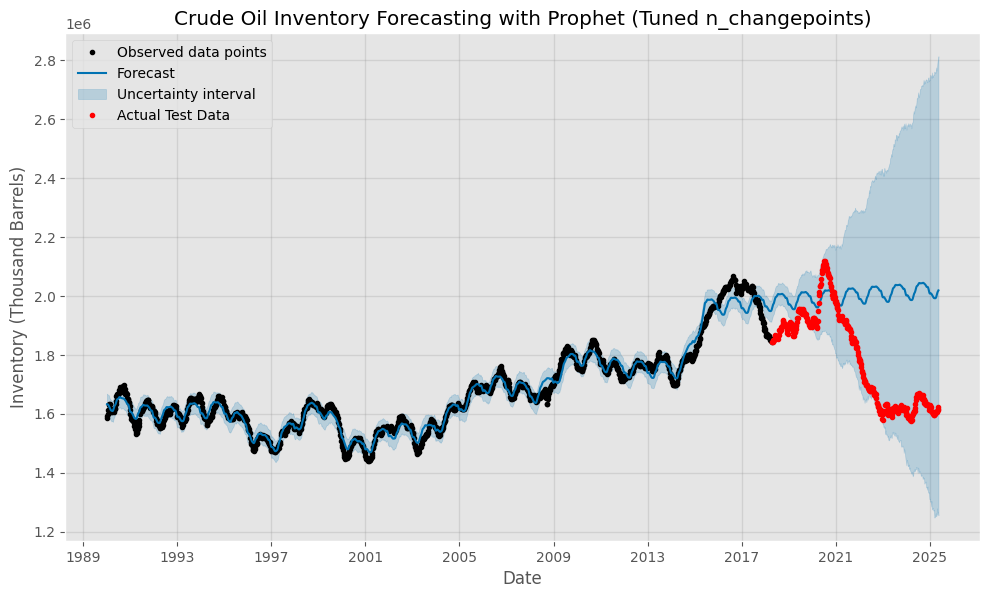

Prophet tuned forecast plot saved to /content/visualizations/crude_oil_prophet_forecast_tuned_ncp.png
Prophet RMSE (Tuned n_changepoints): 271480.4157639802
Prophet MAE (Tuned n_changepoints): 224356.84649671783


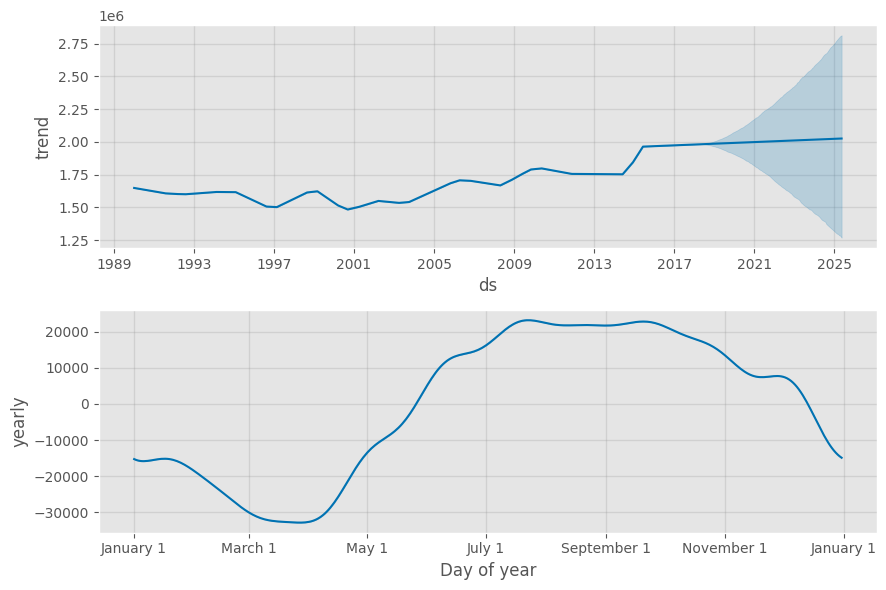

Prophet tuned components plot saved to /content/visualizations/crude_oil_prophet_components_tuned_ncp.png

--- Prophet Tuning with n_changepoints and changepoint_range Complete ---
Check the new 'crude_oil_prophet_forecast_tuned_ncp.png' and 'crude_oil_prophet_components_tuned_ncp.png' plots.


In [40]:
# --- Colab Cell X: Prophet Tuning with n_changepoints and changepoint_range ---
print("\n--- Re-Forecasting with Prophet for Crude Oil (Increased n_changepoints & focused changepoint_range) ---")

if crude_oil_df is not None and not crude_oil_df.empty:
    prophet_df = crude_oil_df.reset_index()[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})

    train_size_prophet = int(len(prophet_df) * 0.8)
    train_prophet = prophet_df.iloc[:train_size_prophet]
    test_prophet = prophet_df.iloc[train_size_prophet:]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        # Increased n_changepoints to allow more flexibility
        n_changepoints=50, # Default is 25. Let's double it.
        # Focus changepoint detection on the later part of the history (e.g., last 90% of training data)
        # This can help it be more reactive to recent shifts
        changepoint_range=0.9, # Default is 0.8 (80% of data)
        changepoint_prior_scale=0.05 # Revert to a moderate scale, combined with more changepoints
    )
    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=len(test_prophet), freq='W-FRI')
    prophet_forecast = m.predict(future)

    fig_prophet = m.plot(prophet_forecast)
    ax = fig_prophet.gca()
    ax.plot(test_prophet['ds'], test_prophet['y'], 'r.', label='Actual Test Data')
    ax.set_title('Crude Oil Inventory Forecasting with Prophet (Tuned n_changepoints)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Inventory (Thousand Barrels)')
    ax.legend()
    plt.grid(True)
    prophet_plot_path_tuned_ncp = os.path.join(output_viz_dir, 'crude_oil_prophet_forecast_tuned_ncp.png')
    fig_prophet.savefig(prophet_plot_path_tuned_ncp)
    plt.show()
    print(f"Prophet tuned forecast plot saved to {prophet_plot_path_tuned_ncp}")

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    prophet_test_yhat = prophet_forecast['yhat'].iloc[train_size_prophet:train_size_prophet + len(test_prophet)]

    rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_yhat))
    mae_prophet = mean_absolute_error(test_prophet['y'], prophet_test_yhat)
    print(f"Prophet RMSE (Tuned n_changepoints): {rmse_prophet}")
    print(f"Prophet MAE (Tuned n_changepoints): {mae_prophet}")

    fig2_prophet = m.plot_components(prophet_forecast)
    prophet_components_path_tuned_ncp = os.path.join(output_viz_dir, 'crude_oil_prophet_components_tuned_ncp.png')
    fig2_prophet.savefig(prophet_components_path_tuned_ncp)
    plt.show()
    print(f"Prophet tuned components plot saved to {prophet_components_path_tuned_ncp}")

else:
    print("Crude Oil data not found or is empty for Prophet forecasting.")

print("\n--- Prophet Tuning with n_changepoints and changepoint_range Complete ---")
print("Check the new 'crude_oil_prophet_forecast_tuned_ncp.png' and 'crude_oil_prophet_components_tuned_ncp.png' plots.")